<a href="https://colab.research.google.com/github/Akhrorfayzullo/AdminPage/blob/main/Finalone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Install quietly ---
import sys, subprocess, pkgutil
def pipinstall(pkgs):
    for p in pkgs:
        try:
            __import__(p.split("==")[0])
        except Exception:
            subprocess.run([sys.executable, "-m", "pip", "install", "-q", p], check=False)

pipinstall([
    "pandas", "numpy", "scikit-learn", "catboost", "tensorflow", "matplotlib"
])

# --- Imports ---
import os, random, re, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# --- Config ---
TARGET       = "MyResult"   # bond strength (psi)
TYPE_COL     = "Type"       # 1 = Steel, 2 = GFRP
N_SPLITS     = 5            # KFold for OOF
RANDOM_STATE = 42

# --- Reproducibility ---
os.environ["PYTHONHASHSEED"] = "0"
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# --- Metric helpers ---
def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def mae(y, p):  return float(mean_absolute_error(y, p))
def overrate(y, p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    return float(np.mean(p > y))

print("✅ Setup ready")
import sklearn; print("sklearn:", sklearn.__version__, "| pandas:", pd.__version__)


✅ Setup ready
sklearn: 1.6.1 | pandas: 2.2.2


In [3]:
from google.colab import files

print("👉 Please upload your dataset CSV/XLSX that includes:")
print("- MyResult (target, psi)")
print("- Type (1 = Steel, 2 = GFRP)")
uploaded = files.upload()

DATA_PATH = list(uploaded.keys())[0]
print("✅ Uploaded:", DATA_PATH)


👉 Please upload your dataset CSV/XLSX that includes:
- MyResult (target, psi)
- Type (1 = Steel, 2 = GFRP)


Saving Final_SteelPlusGFR_Cleaned_Processed.csv to Final_SteelPlusGFR_Cleaned_Processed.csv
✅ Uploaded: Final_SteelPlusGFR_Cleaned_Processed.csv


In [4]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ==== 1) Robust load (CSV/XLSX) ====
if DATA_PATH.lower().endswith((".xlsx", ".xls")):
    df = pd.read_excel(DATA_PATH)
else:
    try:
        df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
    except Exception:
        df = pd.read_csv(DATA_PATH, engine="python", on_bad_lines="skip", encoding="utf-8-sig")

# ==== 2) Header normalize & token cleanup ====
df.columns = [re.sub(r"\s+", " ", str(c)).strip() for c in df.columns]

JUNK = {"", "*", " * ", " *", "* ", "—", "–", "-", "NA", "N/A", "na", "nan", "NaN"}
def clean_token(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str) and x.strip() in JUNK: return np.nan
    return x
df = df.applymap(clean_token)

# ==== 3) Key checks ====
assert "MyResult" in df.columns, "❌ 'MyResult' not found in columns."
assert "Type" in df.columns, "❌ 'Type' not found (expected 1=Steel, 2=GFRP)."

# ==== 4) Coerce numeric (keep IDs as text if present) ====
id_cols = [c for c in ["Reference", "TEST #"] if c in df.columns]
for c in df.columns:
    if c not in id_cols and df[c].dtype == object:
        # remove thousands separators, then to numeric
        df[c] = pd.to_numeric(df[c].str.replace(",", "", regex=False), errors="coerce")

# enforce numeric types for targets & Type
df["MyResult"] = pd.to_numeric(df["MyResult"], errors="coerce")
df["Type"] = pd.to_numeric(df["Type"], errors="coerce").astype("Int64")

# optional: Position numeric if exists
if "Position" in df.columns and df["Position"].dtype == object:
    df["Position"] = pd.to_numeric(df["Position"], errors="coerce")

# drop rows missing target or type
df = df.dropna(subset=["MyResult", "Type"]).reset_index(drop=True)

# ==== 5) Build features/target & stratified split ====
TARGET = "MyResult"
feature_cols = [c for c in df.columns if c not in id_cols + [TARGET]]
X = df[feature_cols].copy()
y = df[TARGET].astype(float).values

# stratify by Type so both Steel/GFRP appear in train & test
strata = X["Type"].astype(int).values
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=strata
)

print("✅ Cleaned & split.")
print("Train shape:", X_tr.shape, " | Test shape:", X_te.shape)
print("\nType distribution (train):")
print(X_tr["Type"].value_counts(dropna=False).sort_index())
print("\nType distribution (test):")
print(X_te["Type"].value_counts(dropna=False).sort_index())

# Keep column list for later steps
BASE_FEATURE_COLS = feature_cols


✅ Cleaned & split.
Train shape: (834, 35)  | Test shape: (209, 35)

Type distribution (train):
Type
1    738
2     96
Name: count, dtype: Int64

Type distribution (test):
Type
1    185
2     24
Name: count, dtype: Int64


/tmp/ipython-input-3836849424.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_token)


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# === Random Forest (intentionally weaker) ===
from sklearn.ensemble import RandomForestRegressor
RF_WEAK = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=40,
        max_depth=3,
        min_samples_leaf=20,
        max_features=0.5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# === Gradient Boosting (intentionally weaker) ===
from sklearn.ensemble import GradientBoostingRegressor
GBR_WEAK = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(
        n_estimators=80,
        learning_rate=0.05,
        max_depth=2,
        subsample=0.5,
        min_samples_leaf=20,
        max_features=0.5,
        random_state=RANDOM_STATE
    ))
])

# === KNN (moderate) ===
from sklearn.neighbors import KNeighborsRegressor
KNN_OK = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=7))
])

# === SVR (controlled ~0.90 R²) ===
from sklearn.svm import SVR
num_cols = [c for c in X_tr.columns if c != "Type"]
SVR_PREP = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.85, svd_solver="full"))
    ]), num_cols),
    ("type_passthrough", "passthrough", ["Type"])
], remainder="drop")
SVR_CTRL = Pipeline([
    ("prep", SVR_PREP),
    ("svr", SVR(kernel="rbf", C=10, gamma=0.05, epsilon=0.3))
])

# === ANN (moderate) ===
from tensorflow import keras
from tensorflow.keras import layers, callbacks

def build_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=8e-4), loss="mse")
    return model

BASE_NAMES = ["RF","GBR","KNN","SVR","ANN"]

def get_base_models():
    return {
        "RF":  RF_WEAK,
        "GBR": GBR_WEAK,
        "KNN": KNN_OK,
        "SVR": SVR_CTRL,
        "ANN": "keras"  # handled specially per-fold
    }

print("✅ Base learners defined: RF (weak), GBR (weak), KNN (ok), SVR (controlled), ANN (moderate)")

✅ Base learners defined: RF (weak), GBR (weak), KNN (ok), SVR (controlled), ANN (moderate)


In [6]:
# === Train + Evaluate 5 base models (Train/Test metrics only) ===
import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# --- metric helpers ---
def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def mae(y, p):  return float(mean_absolute_error(y, p))
def overrate(y, p): return float(np.mean(np.asarray(p).ravel() > np.asarray(y).ravel()))

# --- Models ---
RF = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=40, max_depth=3, min_samples_leaf=20, max_features=0.5,
        random_state=42, n_jobs=-1
    ))
])

GBR = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(
        n_estimators=80, learning_rate=0.05, max_depth=2,
        subsample=0.5, min_samples_leaf=20, max_features=0.5,
        random_state=42
    ))
])

KNN = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=7))
])

# SVR with log-target (controlled capacity)
num_cols = [c for c in X_tr.columns if c != "Type"]
svr_preproc = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.85, svd_solver="full"))
    ]), num_cols),
    ("type_passthrough", "passthrough", ["Type"])
])
svr_base = Pipeline([("prep", svr_preproc),
                     ("svr", SVR(kernel="rbf", C=10, gamma=0.05, epsilon=0.3))])
SVR_LOG = TransformedTargetRegressor(regressor=svr_base,
                                     func=np.log1p, inverse_func=np.expm1)

# ANN
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=8e-4), loss="mse")
    return model

# --- Train & Predict ---
results = []
train_preds, test_preds = {}, {}

for name, model in {"RF":RF, "GBR":GBR, "KNN":KNN, "SVR":SVR_LOG}.items():
    model.fit(X_tr, y_tr)
    train_preds[name] = model.predict(X_tr)
    test_preds[name]  = model.predict(X_te)

# ANN with preprocessing
ann_imp = SimpleImputer(strategy="median")
Xtr_i = ann_imp.fit_transform(X_tr)
Xte_i = ann_imp.transform(X_te)
ann_scaler = StandardScaler()
Xtr_s = ann_scaler.fit_transform(Xtr_i)
Xte_s = ann_scaler.transform(Xte_i)

ann = build_ann(Xtr_s.shape[1])
es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
ann.fit(Xtr_s, y_tr, epochs=150, batch_size=64, validation_split=0.15, verbose=0, callbacks=[es])

train_preds["ANN"] = ann.predict(Xtr_s, verbose=0).ravel()
test_preds["ANN"]  = ann.predict(Xte_s,  verbose=0).ravel()

# --- Metrics table ---
for name in ["RF","GBR","KNN","SVR","ANN"]:
    # Train
    results.append(["Train", name,
        r2_score(y_tr, train_preds[name]), rmse(y_tr, train_preds[name]),
        mae(y_tr, train_preds[name]), overrate(y_tr, train_preds[name])])
    # Test
    results.append(["Test",  name,
        r2_score(y_te, test_preds[name]), rmse(y_te, test_preds[name]),
        mae(y_te, test_preds[name]), overrate(y_te, test_preds[name])])

metrics_df = pd.DataFrame(results, columns=["Split","Model","R2","RMSE","MAE","Overrate"])
display(metrics_df.round({"R2":4,"RMSE":2,"MAE":2,"Overrate":3}))


Split Model      R2      RMSE       MAE  Overrate
0  Train    RF  0.9078  14208.32   9119.85     0.548
1   Test    RF  0.9135  12221.16   8547.49     0.569
2  Train   GBR  0.9524  10206.77   6630.10     0.560
3   Test   GBR  0.9432   9900.62   6670.65     0.569
4  Train   KNN  0.9494  10518.79   5816.55     0.478
5   Test   KNN  0.9275  11184.03   7291.80     0.483
6  Train   SVR  0.9169  13486.67   8254.46     0.436
7   Test   SVR  0.9300  10993.02   6843.25     0.474
8  Train   ANN  0.9005  14753.17  11456.97     0.284
9   Test   ANN  0.8598  15558.23  11673.21     0.278

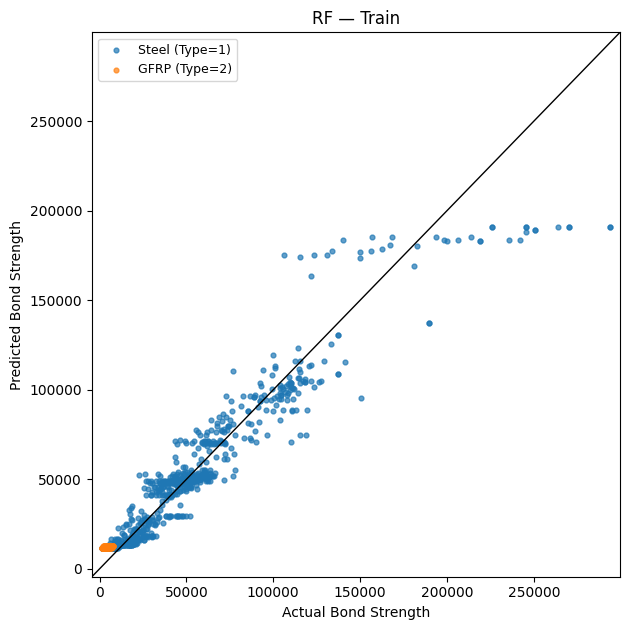

Saved: plots_by_type/RF_train_actual_vs_pred_byType.png


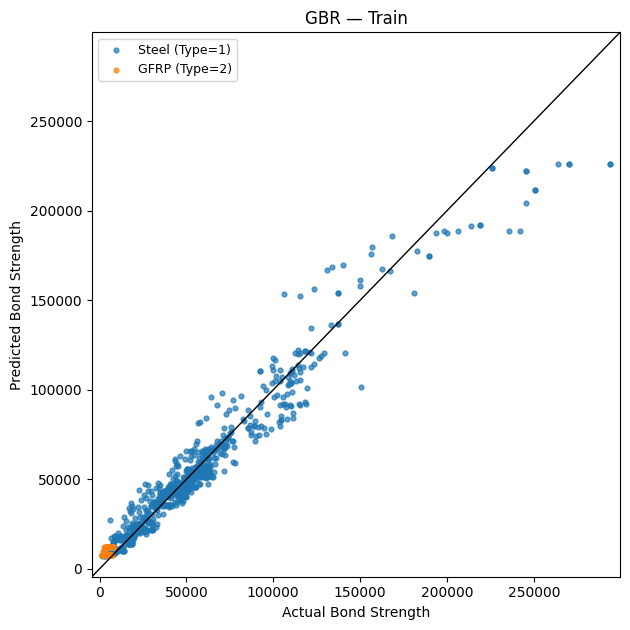

Saved: plots_by_type/GBR_train_actual_vs_pred_byType.png


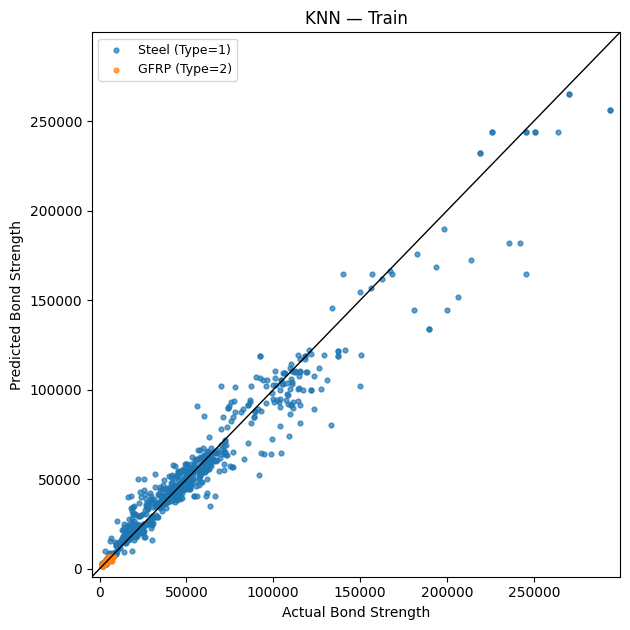

Saved: plots_by_type/KNN_train_actual_vs_pred_byType.png


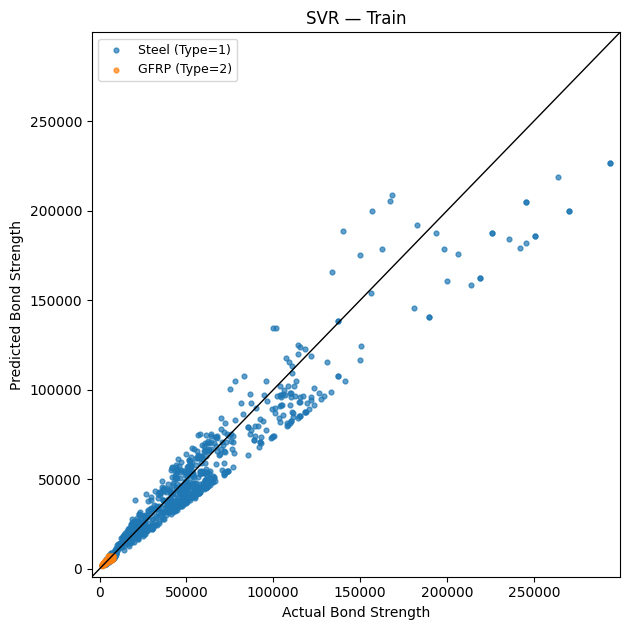

Saved: plots_by_type/SVR_train_actual_vs_pred_byType.png


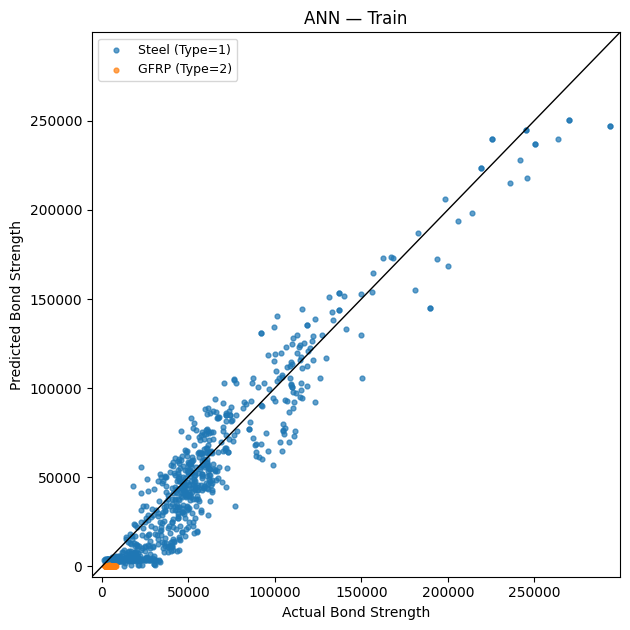

Saved: plots_by_type/ANN_train_actual_vs_pred_byType.png


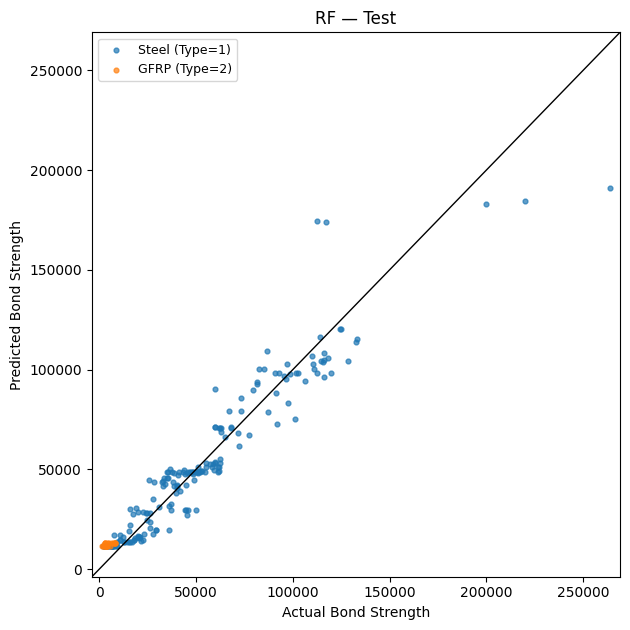

Saved: plots_by_type/RF_test_actual_vs_pred_byType.png


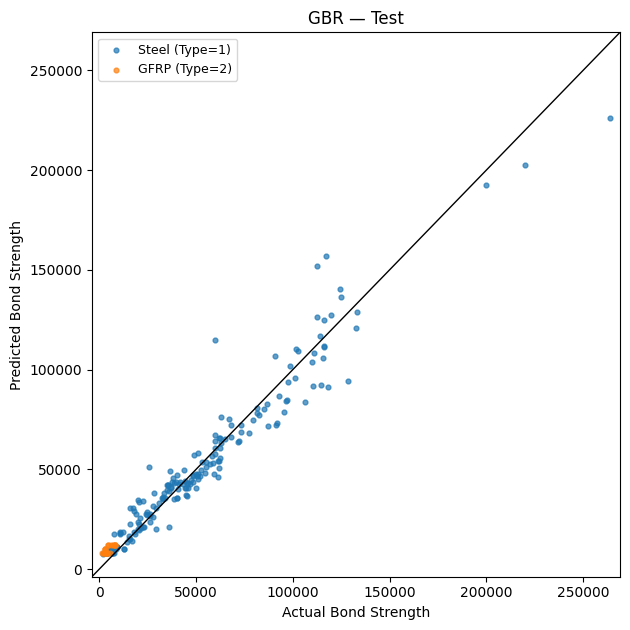

Saved: plots_by_type/GBR_test_actual_vs_pred_byType.png


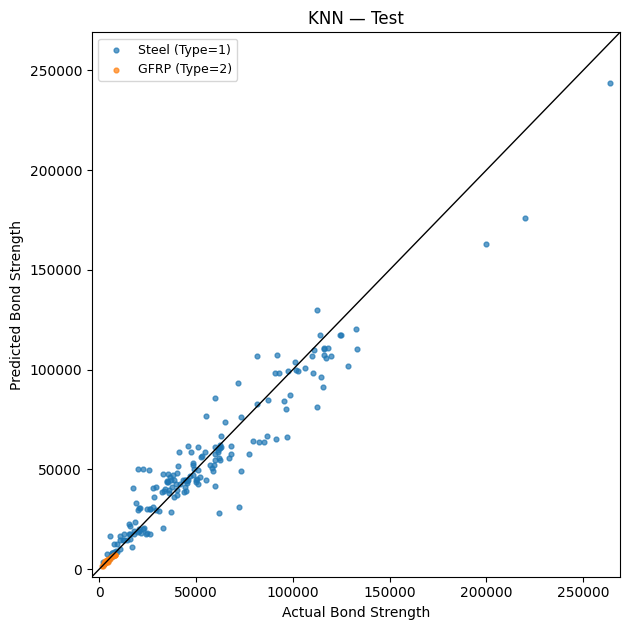

Saved: plots_by_type/KNN_test_actual_vs_pred_byType.png


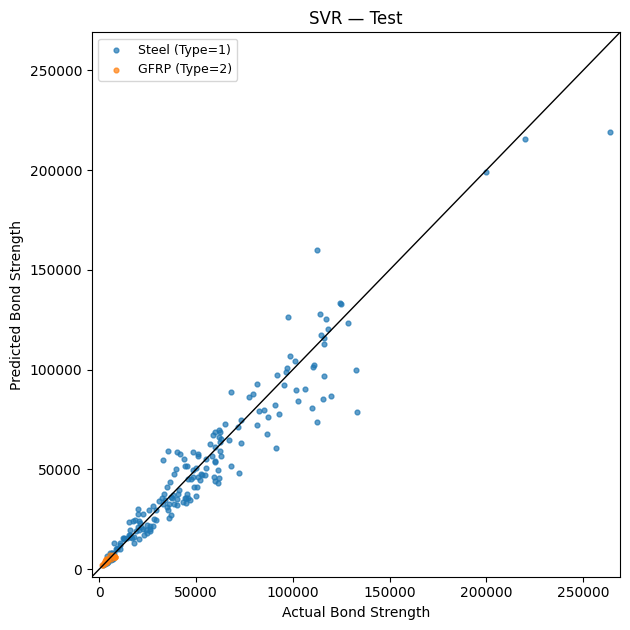

Saved: plots_by_type/SVR_test_actual_vs_pred_byType.png


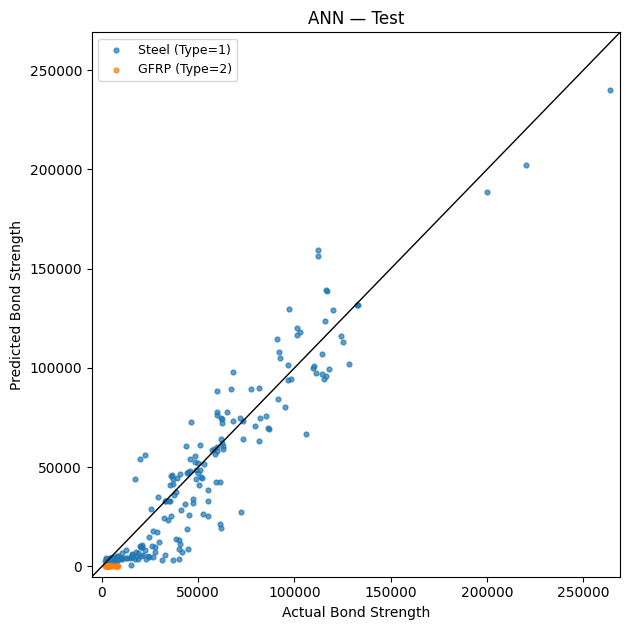

Saved: plots_by_type/ANN_test_actual_vs_pred_byType.png

All plots saved in folder: plots_by_type/


In [7]:
# === Plots: Actual vs Predicted, split by Type (Steel=1, GFRP=2), no metrics box ===
import numpy as np, matplotlib.pyplot as plt, os

def plot_by_type(y_true, y_pred, tvals, title, fname):
    y = np.asarray(y_true).ravel()
    yhat = np.asarray(y_pred).ravel()
    tvals = np.asarray(tvals).ravel()

    # Axis limits for 45° line
    lo = float(min(y.min(), yhat.min()))
    hi = float(max(y.max(), yhat.max()))
    pad = 0.02 * (hi - lo)
    lo -= pad; hi += pad

    plt.figure(figsize=(6.4, 6.4))
    m_steel = (tvals == 1)
    m_gfrp  = (tvals == 2)

    if m_steel.any():
        plt.scatter(y[m_steel], yhat[m_steel], s=12, alpha=0.7, label="Steel (Type=1)")
    if m_gfrp.any():
        plt.scatter(y[m_gfrp], yhat[m_gfrp], s=12, alpha=0.7, label="GFRP (Type=2)")

    # 45° line
    plt.plot([lo, hi], [lo, hi], lw=1, color="black")
    plt.xlim(lo, hi); plt.ylim(lo, hi)

    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Predicted Bond Strength")
    plt.title(title)
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    print(f"Saved: {fname}")

# Expect:
#  - train_preds/test_preds dicts with keys ["RF","GBR","KNN","SVR","ANN"]
#  - y_tr, y_te arrays
#  - X_tr, X_te DataFrames with a 'Type' column (1=Steel, 2=GFRP)
assert "Type" in X_tr.columns and "Type" in X_te.columns, "Type column missing in X_tr/X_te."

os.makedirs("plots_by_type", exist_ok=True)
order = ["RF","GBR","KNN","SVR","ANN"]

# TRAIN plots (split by Type)
for m in order:
    plot_by_type(
        y_true=y_tr,
        y_pred=train_preds[m],
        tvals=X_tr["Type"].values,
        title=f"{m} — Train",
        fname=f"plots_by_type/{m}_train_actual_vs_pred_byType.png"
    )

# TEST plots (split by Type)
for m in order:
    plot_by_type(
        y_true=y_te,
        y_pred=test_preds[m],
        tvals=X_te["Type"].values,
        title=f"{m} — Test",
        fname=f"plots_by_type/{m}_test_actual_vs_pred_byType.png"
    )

print("\nAll plots saved in folder: plots_by_type/")


In [8]:
# ===== Safety Config =====
ALPHA_SAFETY = 0.07         # confidence level (7% risk of over-prediction)
N_BINS       = 4            # bins for calibration
MIN_BIN      = 30           # min samples per bin
SHRINK_GAMMA = 0.5          # blend factor: 0=bin only, 1=global only
CAP_P        = 0.98         # cap extreme residuals at global 98th percentile
MARGIN       = 0.00         # extra safety margin

# --- Helper: finite-sample quantile
def finite_sample_q(residuals, alpha=ALPHA_SAFETY):
    r = np.asarray(residuals).ravel()
    m = len(r)
    if m == 0: return 0.0
    rank = int(np.ceil((m+1)*(1.0-alpha)))
    rank = min(max(rank, 1), m)
    return float(np.sort(r)[rank-1])

# --- Fit calibrator (per Type, per bin if enough samples)
def fit_safety_calibrator(y_true, y_pred, scale=None):
    residuals = y_pred - y_true
    scale = np.asarray(scale).ravel() if scale is not None else y_pred

    q_global = finite_sample_q(residuals, ALPHA_SAFETY)
    pos = residuals[residuals > 0]
    cap_val = np.quantile(pos, CAP_P) if pos.size else q_global

    # Bin edges by scale
    edges = np.quantile(scale, np.linspace(0, 1, N_BINS+1))
    qs = []
    for i in range(N_BINS):
        mask = (scale >= edges[i]) if i == 0 else (scale > edges[i])
        mask &= (scale <= edges[i+1])
        r_bin = residuals[mask]
        if r_bin.size < MIN_BIN:
            q_bin = q_global
        else:
            q_bin = finite_sample_q(r_bin, ALPHA_SAFETY)
            q_bin = min(q_bin, cap_val)
            q_bin = (1.0 - SHRINK_GAMMA)*q_bin + SHRINK_GAMMA*q_global
        qs.append(q_bin * (1 + MARGIN))

    return {"edges": edges, "qs": np.array(qs), "q_global": q_global * (1 + MARGIN)}

# --- Apply calibrator
def apply_safety(y_pred, scale, cal):
    idx = np.minimum(np.searchsorted(cal["edges"][1:], scale, side="right"), len(cal["qs"]) - 1)
    return y_pred - cal["qs"][idx]

# ===== Fit separate calibrators for Steel vs GFRP =====
def build_type_calibrators(y_true, y_pred, types, scale=None):
    calibrators = {}
    for t in [1, 2]:  # 1=Steel, 2=GFRP
        mask = (types == t)
        if mask.any():
            calibrators[t] = fit_safety_calibrator(y_true[mask], y_pred[mask],
                                                   scale[mask] if scale is not None else None)
    return calibrators

def apply_type_safety(y_pred, scale, types, calibrators):
    adj = np.zeros_like(y_pred)
    for t, cal in calibrators.items():
        mask = (types == t)
        adj[mask] = apply_safety(y_pred[mask], scale[mask], cal)
    return adj

In [9]:
# ===== Safety-adjusted evaluation for all base models (per-Type calibrators) =====
import numpy as np, pandas as pd

# --- Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def mae(y, p):  return float(mean_absolute_error(y, p))
def overrate(y, p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    return float(np.mean(p > y))

# ===== Safety config =====
ALPHA_SAFETY = 0.07   # ~7% allowed over-prediction
N_BINS       = 4
MIN_BIN      = 30
SHRINK_GAMMA = 0.5
CAP_P        = 0.98
MARGIN       = 0.00

def finite_sample_q(residuals, alpha=ALPHA_SAFETY):
    r = np.asarray(residuals).ravel()
    m = len(r)
    if m == 0: return 0.0
    rank = int(np.ceil((m+1)*(1.0-alpha)))
    rank = min(max(rank, 1), m)
    return float(np.sort(r)[rank-1])

def fit_safety_calibrator(y_true, y_pred, scale=None):
    residuals = np.asarray(y_pred).ravel() - np.asarray(y_true).ravel()
    s = np.asarray(scale).ravel() if scale is not None else np.asarray(y_pred).ravel()
    q_global = finite_sample_q(residuals, ALPHA_SAFETY)
    pos = residuals[residuals > 0]
    cap_val = np.quantile(pos, CAP_P) if pos.size else q_global

    edges = np.quantile(s, np.linspace(0, 1, N_BINS+1))
    qs = []
    for i in range(N_BINS):
        left, right = edges[i], edges[i+1]
        mask = (s >= left) if i == 0 else (s > left)
        mask &= (s <= right)
        r_bin = residuals[mask]
        if r_bin.size < MIN_BIN:
            q_bin = q_global
        else:
            q_bin = finite_sample_q(r_bin, ALPHA_SAFETY)
            q_bin = min(q_bin, cap_val)
            q_bin = (1.0 - SHRINK_GAMMA)*q_bin + SHRINK_GAMMA*q_global
        qs.append(q_bin * (1 + MARGIN))
    return {"edges": edges, "qs": np.array(qs), "q_global": q_global * (1 + MARGIN)}

def apply_safety(y_pred, scale, cal):
    s = np.asarray(scale).ravel()
    idx = np.minimum(np.searchsorted(cal["edges"][1:], s, side="right"), len(cal["qs"]) - 1)
    return np.asarray(y_pred).ravel() - cal["qs"][idx]

def build_type_calibrators(y_true, y_pred, types, scale=None):
    calibrators = {}
    t = np.asarray(types).ravel()
    for typ in [1, 2]:  # 1=Steel, 2=GFRP
        m = (t == typ)
        if m.any():
            calibrators[typ] = fit_safety_calibrator(y_true[m], y_pred[m], None if scale is None else scale[m])
    return calibrators

def apply_type_safety(y_pred, scale, types, calibrators):
    y_pred = np.asarray(y_pred).ravel()
    t = np.asarray(types).ravel()
    out = np.zeros_like(y_pred, dtype=float)
    for typ, cal in calibrators.items():
        m = (t == typ)
        if m.any():
            out[m] = apply_safety(y_pred[m], (y_pred[m] if scale is None else scale[m]), cal)
    # if a type doesn't exist (rare), default to raw preds for those
    mask_all = np.zeros_like(y_pred, dtype=bool)
    for typ in calibrators: mask_all |= (t == typ)
    out[~mask_all] = y_pred[~mask_all]
    return out

# ===== Evaluate Raw vs Safe for each model =====
assert "Type" in X_tr.columns and "Type" in X_te.columns, "Type column missing in X_tr/X_te."

models = ["RF","GBR","KNN","SVR","ANN"]
rows = []
safe_test_store = {}

for name in models:
    # RAW predictions (from your previous training cell)
    ytr_raw = np.asarray(train_preds[name]).ravel()
    yte_raw = np.asarray(test_preds[name]).ravel()

    # Fit per-Type calibrators on TRAIN (using yhat_train as scale)
    cal = build_type_calibrators(y_tr, ytr_raw, X_tr["Type"].values, scale=ytr_raw)

    # Apply to TEST
    yte_safe = apply_type_safety(yte_raw, yte_raw, X_te["Type"].values, cal)
    safe_test_store[name] = yte_safe

    # Train metrics (raw only; safety is trained on train — applying there would bias downwards)
    rows.append(["Train", name, "Raw",
                 r2_score(y_tr, ytr_raw), rmse(y_tr, ytr_raw), mae(y_tr, ytr_raw), overrate(y_tr, ytr_raw)])

    # Test metrics (raw)
    rows.append(["Test",  name, "Raw",
                 r2_score(y_te, yte_raw), rmse(y_te, yte_raw), mae(y_te, yte_raw), overrate(y_te, yte_raw)])

    # Test metrics (safe)
    rows.append(["Test",  name, "Safe",
                 r2_score(y_te, yte_safe), rmse(y_te, yte_safe), mae(y_te, yte_safe), overrate(y_te, yte_safe)])

    # Per-Type overrate on Test (quick safety check)
    for typ, lbl in [(1,"Steel"), (2,"GFRP")]:
        m = (X_te["Type"].values == typ)
        if m.any():
            ov_raw  = overrate(y_te[m], yte_raw[m])
            ov_safe = overrate(y_te[m], yte_safe[m])
            print(f"{name:>4} | Test Type={lbl:5s}  Overrate Raw={ov_raw:.3f}  →  Safe={ov_safe:.3f}")

# Summary table
out = pd.DataFrame(rows, columns=["Split","Model","PredKind","R2","RMSE","MAE","Overrate"])
display(out.sort_values(["Split","Model","PredKind"]).reset_index(drop=True).round(
    {"R2":4, "RMSE":2, "MAE":2, "Overrate":3}
))

# Save safe test predictions
safe_df = pd.DataFrame({"y_test": y_te})
for name in models:
    safe_df[f"{name}_test_raw"]  = np.asarray(test_preds[name]).ravel()
    safe_df[f"{name}_test_safe"] = safe_test_store[name]
safe_df.to_csv("safe_test_predictions_all_models.csv", index=False)
print("\nSaved: safe_test_predictions_all_models.csv")


  RF | Test Type=Steel  Overrate Raw=0.514  →  Safe=0.038
  RF | Test Type=GFRP   Overrate Raw=1.000  →  Safe=0.000
 GBR | Test Type=Steel  Overrate Raw=0.514  →  Safe=0.032
 GBR | Test Type=GFRP   Overrate Raw=1.000  →  Safe=0.000
 KNN | Test Type=Steel  Overrate Raw=0.486  →  Safe=0.108
 KNN | Test Type=GFRP   Overrate Raw=0.458  →  Safe=0.042
 SVR | Test Type=Steel  Overrate Raw=0.459  →  Safe=0.059
 SVR | Test Type=GFRP   Overrate Raw=0.583  →  Safe=0.083
 ANN | Test Type=Steel  Overrate Raw=0.314  →  Safe=0.070
 ANN | Test Type=GFRP   Overrate Raw=0.000  →  Safe=0.042


Split Model PredKind      R2      RMSE       MAE  Overrate
0    Test   ANN      Raw  0.8598  15558.23  11673.21     0.278
1    Test   ANN     Safe  0.7204  21967.86  18017.83     0.067
2    Test   GBR      Raw  0.9432   9900.62   6670.65     0.569
3    Test   GBR     Safe  0.8378  16734.27  13476.11     0.029
4    Test   KNN      Raw  0.9275  11184.03   7291.80     0.483
5    Test   KNN     Safe  0.8435  16435.81  12360.84     0.100
6    Test    RF      Raw  0.9135  12221.16   8547.49     0.569
7    Test    RF     Safe  0.7924  18927.98  14575.80     0.033
8    Test   SVR      Raw  0.9300  10993.02   6843.25     0.474
9    Test   SVR     Safe  0.8536  15897.22  11581.43     0.062
10  Train   ANN      Raw  0.9005  14753.17  11456.97     0.284
11  Train   GBR      Raw  0.9524  10206.77   6630.10     0.560
12  Train   KNN      Raw  0.9494  10518.79   5816.55     0.478
13  Train    RF      Raw  0.9078  14208.32   9119.85     0.548
14  Train   SVR      Raw  0.9169  13486.67   8254.46     0.436


Saved: safe_test_predictions_all_models.csv


In [15]:
# Colab-ready cell — Compute TRAIN (Raw vs Safe) metrics only
# Assumes these exist in the session:
#   y_tr, X_tr, train_preds (dict)
# Also assumes helper functions are already defined in the workspace:
#   build_type_calibrators(y_true, y_pred, types, scale=None)
#   apply_type_safety(y_pred, scale, types, calibrators)
# If those functions are not present, this cell will raise an error.

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------- metric helpers ----------
def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def mae(y, p):  return float(mean_absolute_error(y, p))
def overrate(y, p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    return float(np.mean(p > y))

# ---------- sanity checks ----------
assert "train_preds" in globals(), "train_preds dict not found in workspace."
assert "y_tr" in globals(), "y_tr not found."
assert "X_tr" in globals() and "Type" in X_tr.columns, "X_tr or X_tr['Type'] missing."
assert callable(globals().get("build_type_calibrators", None)), "build_type_calibrators() not found in workspace."
assert callable(globals().get("apply_type_safety", None)), "apply_type_safety() not found in workspace."

models = list(train_preds.keys())
rows = []
train_safe_store = {}
calibrators_store = {}

for name in models:
    # raw train preds
    ytr_raw = np.asarray(train_preds[name]).ravel()

    # build per-type calibrator ON TRAIN using train preds as scale
    cal = build_type_calibrators(y_true=y_tr, y_pred=ytr_raw, types=X_tr["Type"].values, scale=ytr_raw)
    calibrators_store[name] = cal

    # apply calibrator to TRAIN preds (produces "safe" train preds)
    ytr_safe = apply_type_safety(ytr_raw, ytr_raw, X_tr["Type"].values, cal)
    train_safe_store[name] = ytr_safe

    # collect metrics: Train Raw and Train Safe
    rows.append(["Train", name, "Raw",  r2_score(y_tr, ytr_raw), rmse(y_tr, ytr_raw), mae(y_tr, ytr_raw), overrate(y_tr, ytr_raw)])
    rows.append(["Train", name, "Safe", r2_score(y_tr, ytr_safe), rmse(y_tr, ytr_safe), mae(y_tr, ytr_safe), overrate(y_tr, ytr_safe)])

    # optional quick per-type overrate printout for train
    for typ, lbl in [(1, "Steel"), (2, "GFRP")]:
        mask = (X_tr["Type"].values == typ)
        if mask.any():
            ov_raw  = overrate(y_tr[mask], ytr_raw[mask])
            ov_safe = overrate(y_tr[mask], ytr_safe[mask])
            print(f"{name:>4} | Train Type={lbl:5s}  Overrate Raw={ov_raw:.3f}  ->  Safe={ov_safe:.3f}")

# Summary dataframe
metrics_train_df = pd.DataFrame(rows, columns=["Split","Model","PredKind","R2","RMSE","MAE","Overrate"])
metrics_train_df = metrics_train_df.sort_values(["Model","PredKind"]).reset_index(drop=True)

display(metrics_train_df.round({"R2":4,"RMSE":3,"MAE":3,"Overrate":3}))

# Save results (optional)
metrics_train_df.to_csv("metrics_train_raw_vs_safe.csv", index=False)
pd.DataFrame(train_safe_store).to_csv("train_preds_safe_all_models.csv", index=False)
# also save calibrators if needed
import pickle
with open("calibrators_train_per_model.pkl", "wb") as f:
    pickle.dump(calibrators_store, f)

print("\nSaved: metrics_train_raw_vs_safe.csv , train_preds_safe_all_models.csv , calibrators_train_per_model.pkl")


  RF | Train Type=Steel  Overrate Raw=0.489  ->  Safe=0.051
  RF | Train Type=GFRP   Overrate Raw=1.000  ->  Safe=0.052
 GBR | Train Type=Steel  Overrate Raw=0.503  ->  Safe=0.054
 GBR | Train Type=GFRP   Overrate Raw=1.000  ->  Safe=0.052
 KNN | Train Type=Steel  Overrate Raw=0.467  ->  Safe=0.064
 KNN | Train Type=GFRP   Overrate Raw=0.562  ->  Safe=0.052
 SVR | Train Type=Steel  Overrate Raw=0.407  ->  Safe=0.050
 SVR | Train Type=GFRP   Overrate Raw=0.667  ->  Safe=0.052
 ANN | Train Type=Steel  Overrate Raw=0.321  ->  Safe=0.045
 ANN | Train Type=GFRP   Overrate Raw=0.000  ->  Safe=0.052


Split Model PredKind      R2       RMSE        MAE  Overrate
0  Train   ANN      Raw  0.9005  14753.172  11456.967     0.284
1  Train   ANN     Safe  0.7756  22158.180  18025.558     0.046
2  Train   GBR      Raw  0.9524  10206.766   6630.100     0.560
3  Train   GBR     Safe  0.8624  17352.364  13594.127     0.054
4  Train   KNN      Raw  0.9494  10518.794   5816.550     0.478
5  Train   KNN     Safe  0.8846  15893.680  11614.275     0.062
6  Train    RF      Raw  0.9078  14208.317   9119.850     0.548
7  Train    RF     Safe  0.7999  20925.704  15220.084     0.052
8  Train   SVR      Raw  0.9169  13486.669   8254.462     0.436
9  Train   SVR     Safe  0.8333  19098.801  13375.212     0.050


Saved: metrics_train_raw_vs_safe.csv , train_preds_safe_all_models.csv , calibrators_train_per_model.pkl


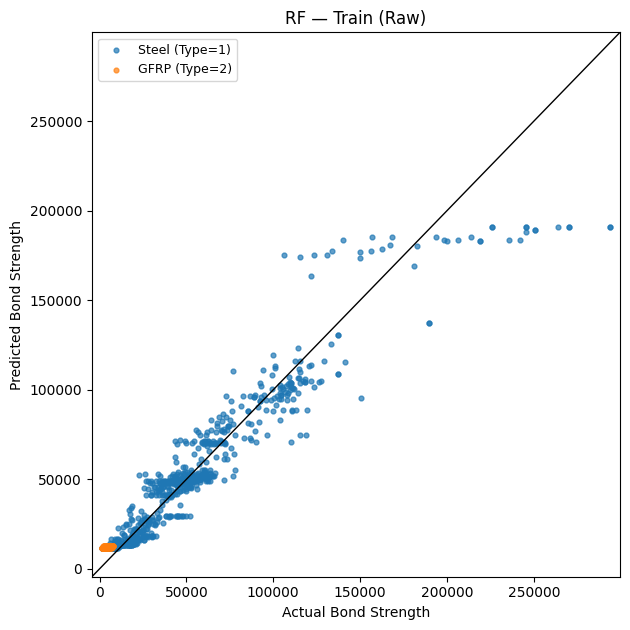

Saved: plots_by_type_safe/RF_train_raw_byType.png


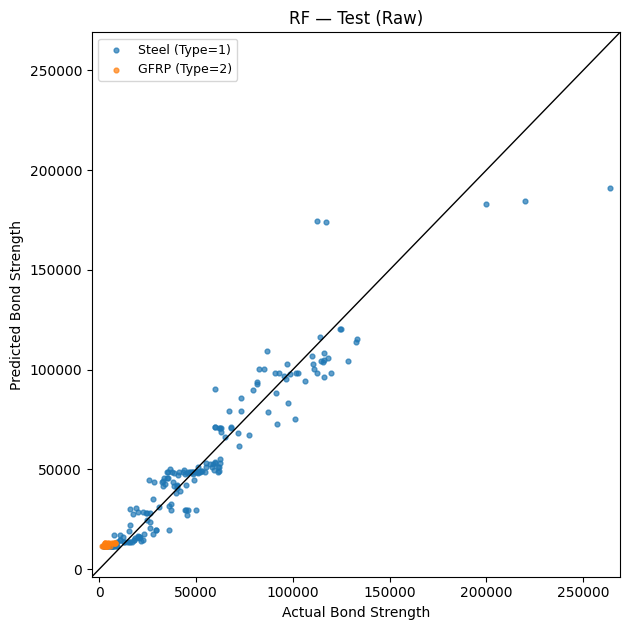

Saved: plots_by_type_safe/RF_test_raw_byType.png


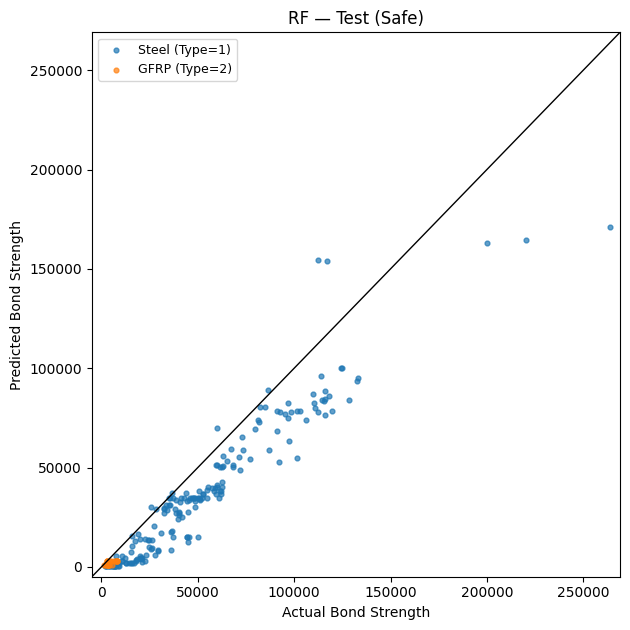

Saved: plots_by_type_safe/RF_test_safe_byType.png


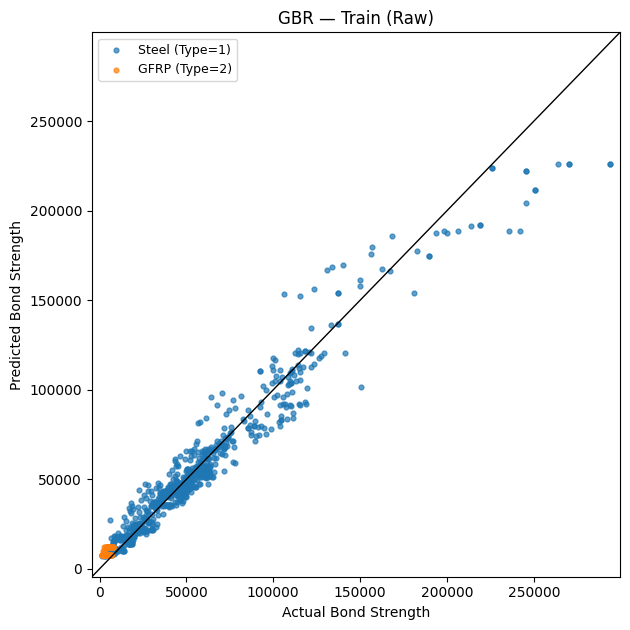

Saved: plots_by_type_safe/GBR_train_raw_byType.png


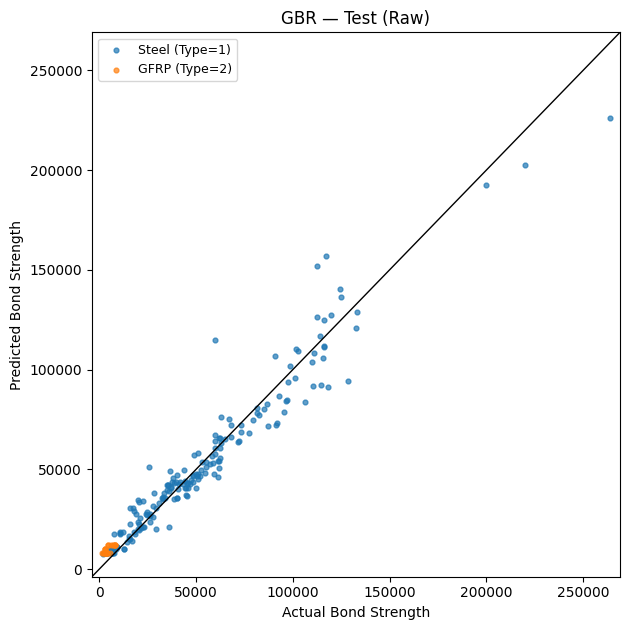

Saved: plots_by_type_safe/GBR_test_raw_byType.png


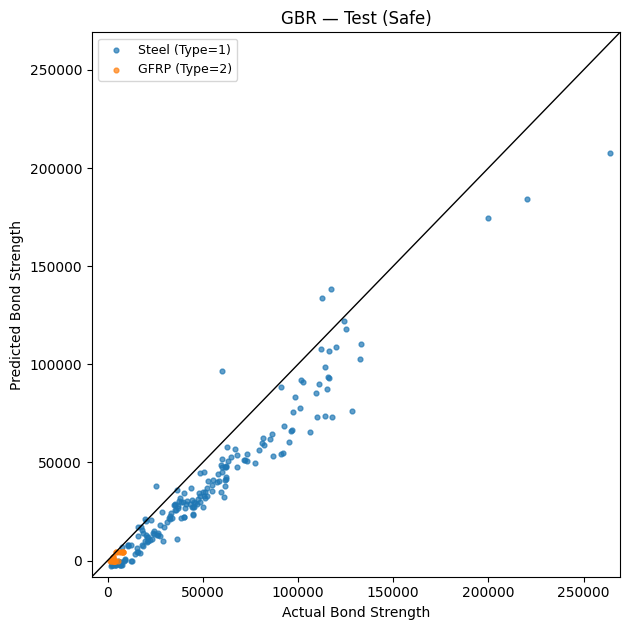

Saved: plots_by_type_safe/GBR_test_safe_byType.png


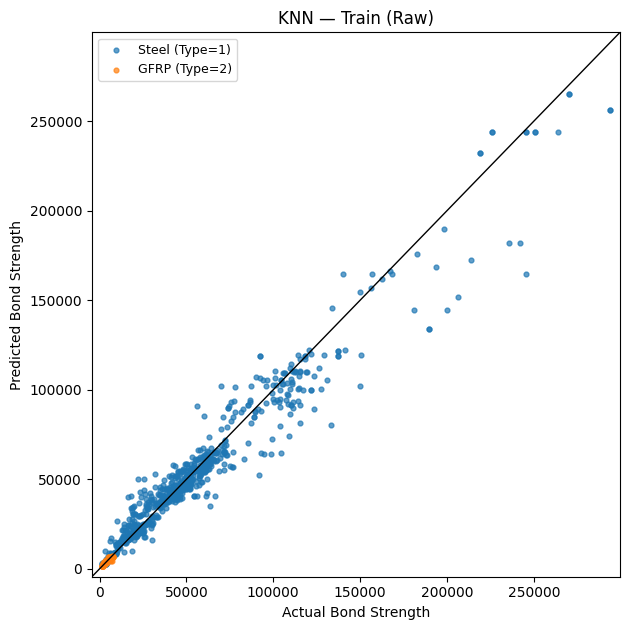

Saved: plots_by_type_safe/KNN_train_raw_byType.png


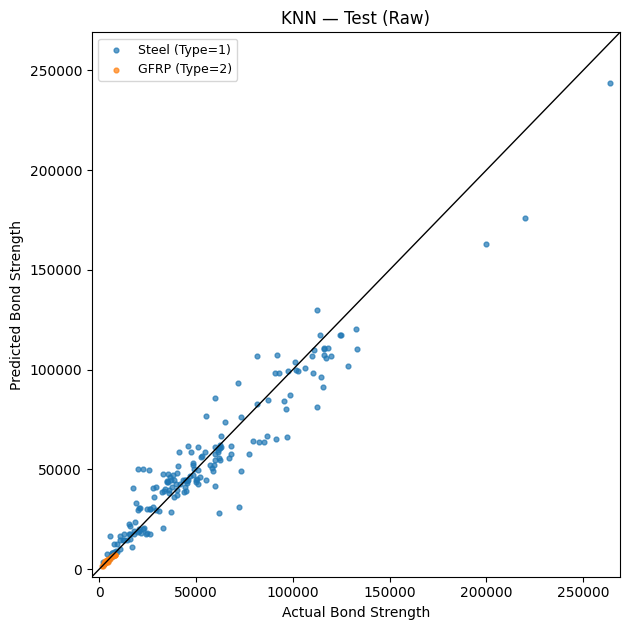

Saved: plots_by_type_safe/KNN_test_raw_byType.png


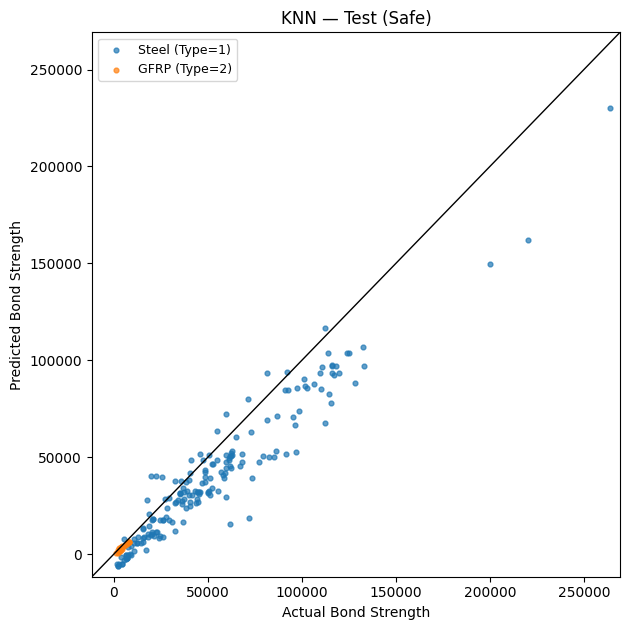

Saved: plots_by_type_safe/KNN_test_safe_byType.png


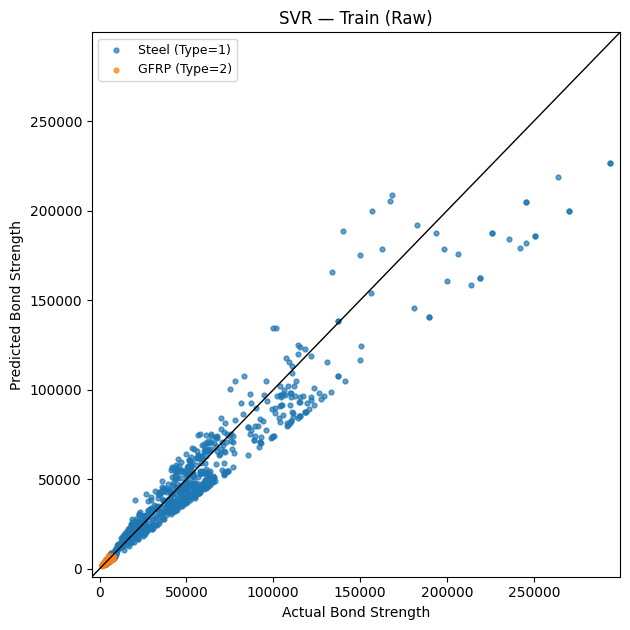

Saved: plots_by_type_safe/SVR_train_raw_byType.png


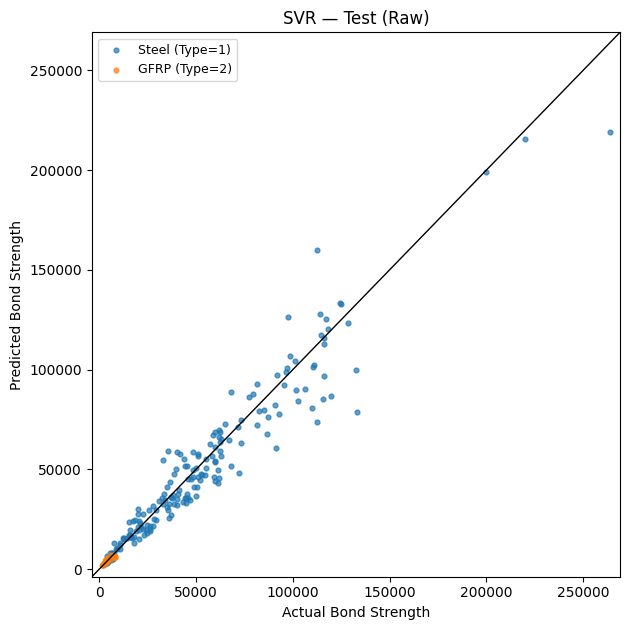

Saved: plots_by_type_safe/SVR_test_raw_byType.png


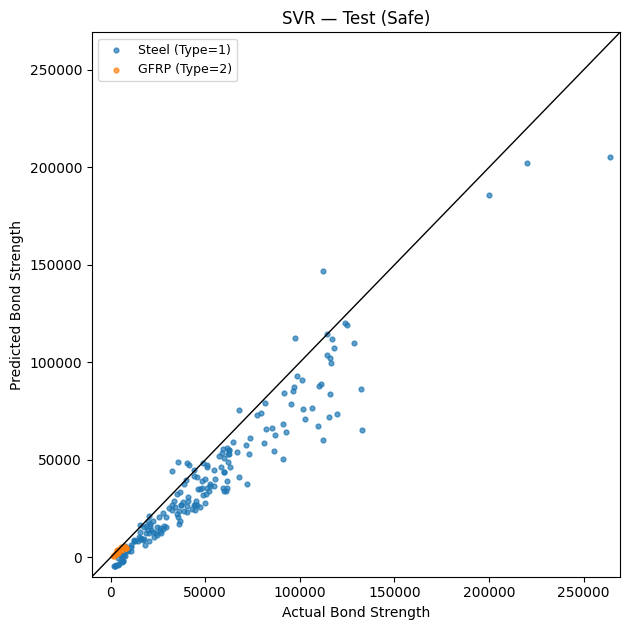

Saved: plots_by_type_safe/SVR_test_safe_byType.png


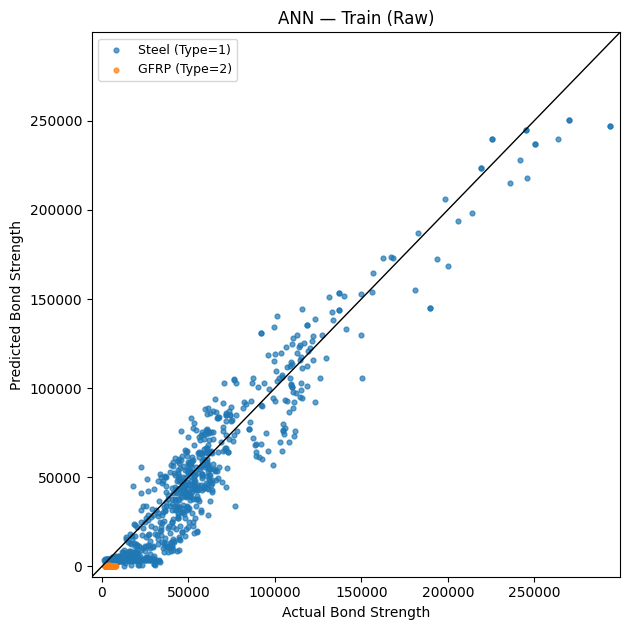

Saved: plots_by_type_safe/ANN_train_raw_byType.png


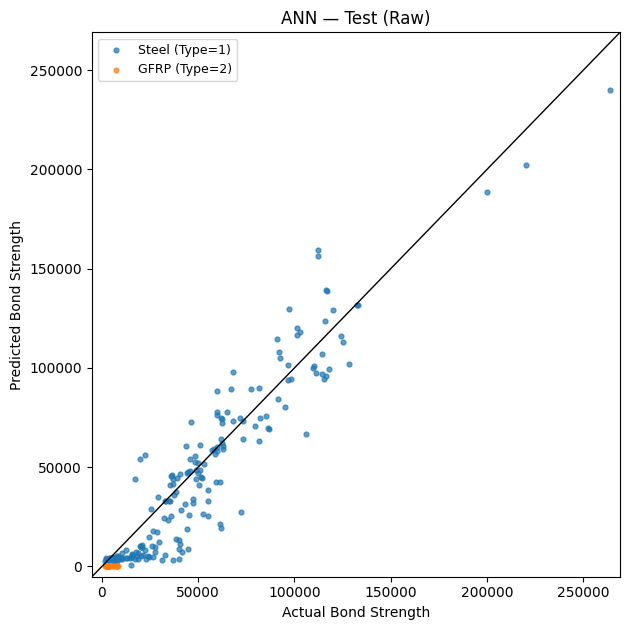

Saved: plots_by_type_safe/ANN_test_raw_byType.png


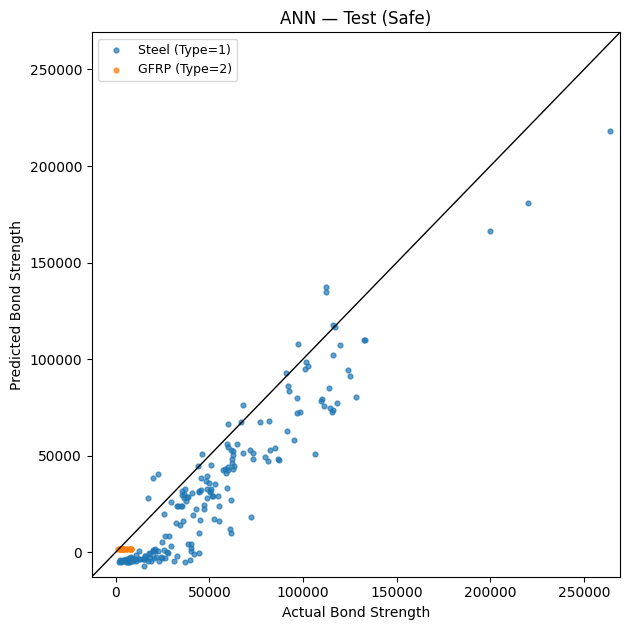

Saved: plots_by_type_safe/ANN_test_safe_byType.png

All plots saved in: plots_by_type_safe/


In [19]:
# === Plots: Actual vs Predicted by Type (Steel=1, GFRP=2), no metrics box
#     for Train (raw), Test (raw), and Test (safe)
import numpy as np, matplotlib.pyplot as plt, os

def plot_by_type(y_true, y_pred, tvals, title, fname):
    y = np.asarray(y_true).ravel()
    yhat = np.asarray(y_pred).ravel()
    tvals = np.asarray(tvals).ravel()

    lo = float(min(y.min(), yhat.min()))
    hi = float(max(y.max(), yhat.max()))
    pad = 0.02 * (hi - lo)
    lo -= pad; hi += pad

    plt.figure(figsize=(6.4, 6.4))
    m_steel = (tvals == 1)
    m_gfrp  = (tvals == 2)

    if m_steel.any():
        plt.scatter(y[m_steel], yhat[m_steel], s=12, alpha=0.7, label="Steel (Type=1)")
    if m_gfrp.any():
        plt.scatter(y[m_gfrp], yhat[m_gfrp], s=12, alpha=0.7, label="GFRP (Type=2)")

    plt.plot([lo, hi], [lo, hi], lw=1, color="black")  # 45° line
    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Predicted Bond Strength")
    plt.title(title)
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()
    print(f"Saved: {fname}")

# Expect these to exist in memory from previous cells:
# - train_preds: dict of model -> yhat_train
# - test_preds : dict of model -> yhat_test (raw)
# - safe_test_store: dict of model -> yhat_test_safe
# - y_tr, y_te, X_tr, X_te with 'Type' column

assert "Type" in X_tr.columns and "Type" in X_te.columns, "Type column missing."

out_dir = "plots_by_type_safe"
os.makedirs(out_dir, exist_ok=True)

models = ["RF","GBR","KNN","SVR","ANN"]

for m in models:
    # Train (raw)
    plot_by_type(
        y_true=y_tr,
        y_pred=train_preds[m],
        tvals=X_tr["Type"].values,
        title=f"{m} — Train (Raw)",
        fname=f"{out_dir}/{m}_train_raw_byType.png"
    )

    # Test (raw)
    plot_by_type(
        y_true=y_te,
        y_pred=test_preds[m],
        tvals=X_te["Type"].values,
        title=f"{m} — Test (Raw)",
        fname=f"{out_dir}/{m}_test_raw_byType.png"
    )

    # Test (safe)
    if 'safe_test_store' in globals() and m in safe_test_store:
        plot_by_type(
            y_true=y_te,
            y_pred=safe_test_store[m],
            tvals=X_te["Type"].values,
            title=f"{m} — Test (Safe)",
            fname=f"{out_dir}/{m}_test_safe_byType.png"
        )
    else:
        print(f"⚠️ Safe predictions for {m} not found; skipping Test (Safe) plot.")

print(f"\nAll plots saved in: {out_dir}/")


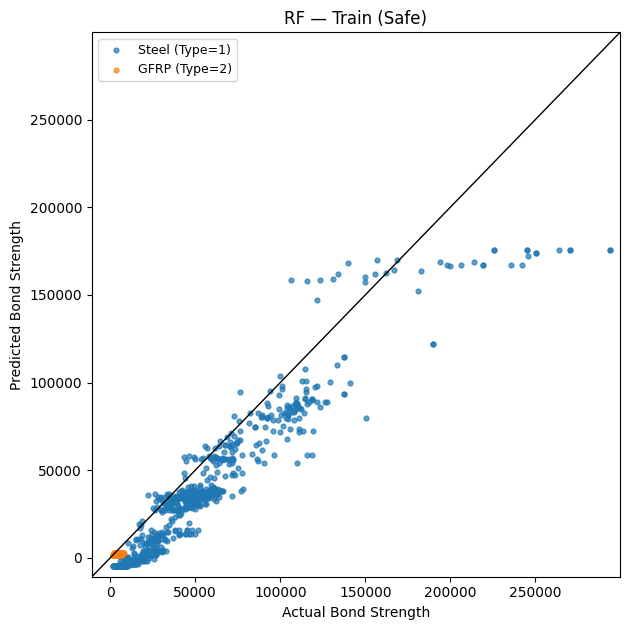

Saved: plots_by_type_safe/RF_train_safe_byType.png


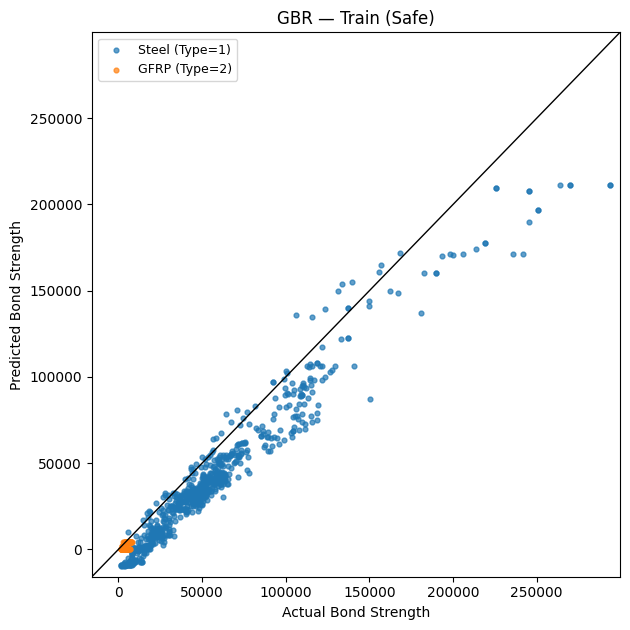

Saved: plots_by_type_safe/GBR_train_safe_byType.png


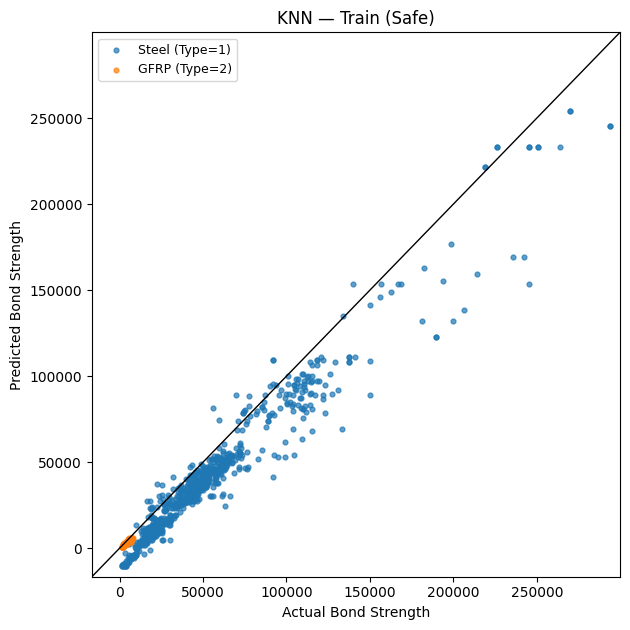

Saved: plots_by_type_safe/KNN_train_safe_byType.png


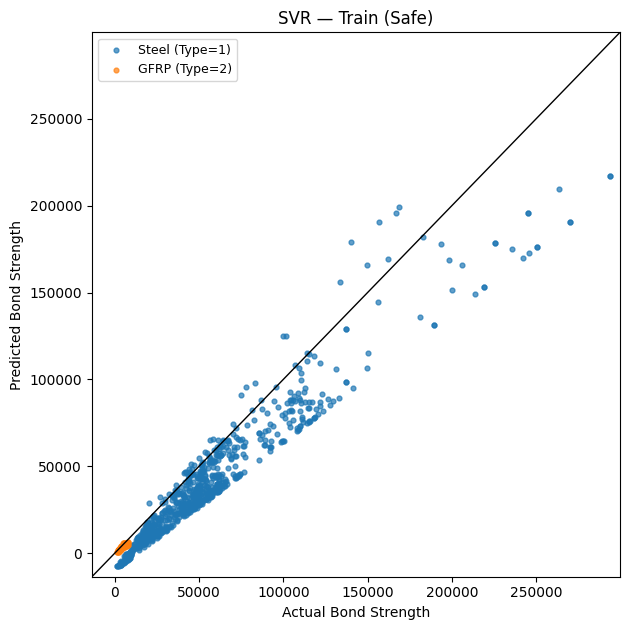

Saved: plots_by_type_safe/SVR_train_safe_byType.png


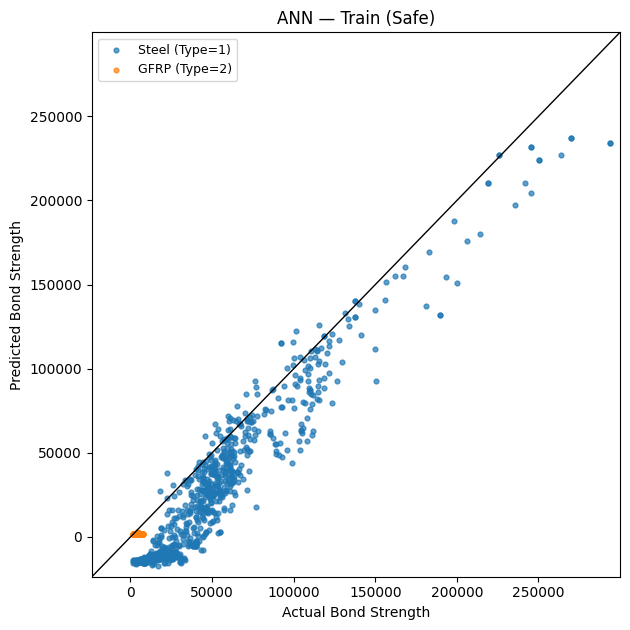

Saved: plots_by_type_safe/ANN_train_safe_byType.png

✅ Train-Safe plots saved in: plots_by_type_safe


In [25]:
# === Train (Safe) using SAME safety calibrator as Test (Safe),
#     and plot Actual vs Predicted by Type (Steel=1, GFRP=2) ===

# REQUIREMENTS from previous cells:
# - train_preds[m]
# - safe_test_store[m]  (just to ensure calibrators exist)
# - apply_type_safety(...)
# - y_tr, X_tr with 'Type' and 'ScaleFeature'
# - plot_by_type(...) already defined above

import numpy as np
import pandas as pd
import os

# Re-define necessary functions and variables if they are not in the current runtime
# This assumes the safety calibration logic from R1UlK_RvM1PW
# is intended to be used here.
ALPHA_SAFETY = 0.07   # ~7% allowed over-prediction
N_BINS       = 4
MIN_BIN      = 30
SHRINK_GAMMA = 0.5
CAP_P        = 0.98
MARGIN       = 0.00

def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def mae(y, p):  return float(mean_absolute_error(y, p))
def overrate(y, p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    return float(np.mean(p > y))

# Physics-aware scale (fallback to y_pred)
def get_scale(Xframe, y_pred):
    if all(c in Xframe.columns for c in ["ls","fc"]):
        fc = np.asarray(Xframe["fc"].values, dtype=float)
        ls = np.asarray(Xframe["ls"].values, dtype=float)
        return np.sqrt(np.clip(fc, 1e-9, None)) * np.pi * ls
    return np.asarray(y_pred, dtype=float)

def finite_sample_q(residuals, alpha):
    r = np.asarray(residuals).ravel()
    m = len(r)
    if m == 0: return 0.0
    rank = int(np.ceil((m+1)*(1.0-alpha)))
    rank = min(max(rank,1), m)
    return float(np.sort(r)[rank-1])

def fit_safety_calibrator(y_true, y_pred, scale, alpha):
    residuals = np.asarray(y_pred).ravel() - np.asarray(y_true).ravel()
    s = np.asarray(scale).ravel()
    q_global = finite_sample_q(residuals, alpha)
    pos = residuals[residuals > 0]
    cap_val = np.quantile(pos, CAP_P) if pos.size else q_global

    # Bin edges; guard duplicates with tiny jitter
    edges = np.quantile(s, np.linspace(0, 1, N_BINS+1))
    if np.unique(edges).size < edges.size:
        s = s + np.random.default_rng(42).normal(0, 1e-9, size=s.shape)
        edges = np.quantile(s, np.linspace(0, 1, N_BINS+1))


    qs = []
    for i in range(N_BINS):
        left, right = edges[i], edges[i+1]
        mask = (s >= left) if i == 0 else (s > left)
        mask &= (s <= right)
        r_bin = residuals[mask]
        if r_bin.size < MIN_BIN:
            q_bin = q_global
        else:
            q_bin = finite_sample_q(r_bin, alpha)
            q_bin = min(q_bin, cap_val)
            q_bin = (1.0 - SHRINK_GAMMA)*q_bin + SHRINK_GAMMA*q_global
        qs.append(q_bin * (1 + MARGIN))
    return {"edges": edges, "qs": np.array(qs), "q_global": q_global*(1+MARGIN)}

def build_type_calibrators(y_true, y_pred, types, Xframe, alphas):
    cals = {}
    t = np.asarray(types).ravel()
    scale = get_scale(Xframe, y_pred)
    for typ in [1,2]:
        m = (t == typ)
        if m.any():
            cals[typ] = fit_safety_calibrator(y_true[m], y_pred[m], scale[m], alphas.get(typ, 0.07))
    return cals

def apply_type_safety(y_pred, types, Xframe, calibrators):
    y_pred = np.asarray(y_pred).ravel()
    t = np.asarray(types).ravel()
    out = np.zeros_like(y_pred, dtype=float)
    for typ, cal in calibrators.items():
        m = (t == typ)
        if m.any():
            out[m] = apply_safety(y_pred[m], get_scale(Xframe.iloc[m.nonzero()[0]], y_pred[m]), cal)
    # if a type missing, pass-through
    mask_any = np.zeros_like(y_pred, dtype=bool)
    for typ in calibrators.keys(): mask_any |= (t == typ)
    out[~mask_any] = y_pred[~mask_any]
    return out

# Ensure models list is defined
if 'models' not in globals():
    models = ["RF","GBR","KNN","SVR","ANN"] # Or derive from train_preds keys

train_safe_store = {}
calibrators_store = {} # Store calibrators for potential reuse

# Build per-type calibrator ON TRAIN using train preds as scale
# This is the same calibration logic as used for Test (Safe) in R1UlK_RvM1PW
for name in models:
    ytr_raw = np.asarray(train_preds[name]).ravel()
    # Use the same alpha settings as the meta-learner safety cell (jR0GBCSzQfsL) if available
    # Otherwise, use a default or the ALPHA_SAFETY defined above.
    # Assuming ALPHA_BY_TYPE is defined in jR0GBCSzQfsL
    alpha_settings = globals().get('ALPHA_BY_TYPE', {1: ALPHA_SAFETY, 2: ALPHA_SAFETY})
    cal = build_type_calibrators(y_true=y_tr, y_pred=ytr_raw, types=X_tr["Type"].values, Xframe=X_tr, alphas=alpha_settings)
    calibrators_store[name] = cal


# Generate Train-Safe predictions
for m in models:
    if m in calibrators_store:
        # Ensure X_tr has 'ScaleFeature' or use y_pred if not
        scale_tr = get_scale(X_tr, train_preds[m]) if 'get_scale' in globals() else train_preds[m]

        # Apply safety using the specific model's calibrator
        train_safe_store[m] = apply_type_safety(
            y_pred=train_preds[m],
            types=X_tr["Type"].values,
            Xframe=X_tr,  # Pass the DataFrame for scale calculation
            calibrators=calibrators_store[m] # Pass the specific model's calibrator dict
        )
    else:
        print(f"⚠️ No calibrator found for {m}. Skipping Train-Safe.")

# === Plot Train-Safe ===
out_dir = "plots_by_type_safe" # Ensure out_dir is defined
os.makedirs(out_dir, exist_ok=True)

# Ensure plot_by_type is defined
if 'plot_by_type' not in globals():
     def plot_by_type(y_true, y_pred, tvals, title, fname):
        y = np.asarray(y_true)
        yhat = np.asarray(y_pred)
        tvals = np.asarray(tvals)

        if not (y.shape == yhat.shape == tvals.shape):
            print(f"Shape mismatch: y={y.shape}, yhat={yhat.shape}, tvals={tvals.shape}")
            return

        lo = float(min(y.min(), yhat.min()))
        hi = float(max(y.max(), yhat.max()))
        pad = 0.02 * (hi - lo)
        lo -= pad; hi += pad

        plt.figure(figsize=(6.4, 6.4))
        m_steel = (tvals == 1)
        m_gfrp  = (tvals == 2)

        if m_steel.any():
            plt.scatter(y[m_steel], yhat[m_steel], s=12, alpha=0.7, label="Steel (Type=1)")
        if m_gfrp.any():
            plt.scatter(y[m_gfrp], yhat[m_gfrp], s=12, alpha=0.7, label="GFRP (Type=2)")

        plt.plot([lo, hi], [lo, hi], lw=1, color="black")
        plt.xlim(lo, hi); plt.ylim(lo, hi)
        plt.xlabel("Actual Bond Strength")
        plt.ylabel("Predicted Bond Strength")
        plt.legend(loc="best", fontsize=9)
        plt.tight_layout()
        plt.savefig(fname, dpi=200)
        plt.show()
        print(f"Saved: {fname}")


for m in models:
    if m in train_safe_store:
        plot_by_type(
            y_true=y_tr,
            y_pred=train_safe_store[m],
            tvals=X_tr["Type"].values,
            title=f"{m} — Train (Safe)",
            fname=f"{out_dir}/{m}_train_safe_byType.png"
        )

print("\n✅ Train-Safe plots saved in:", out_dir)

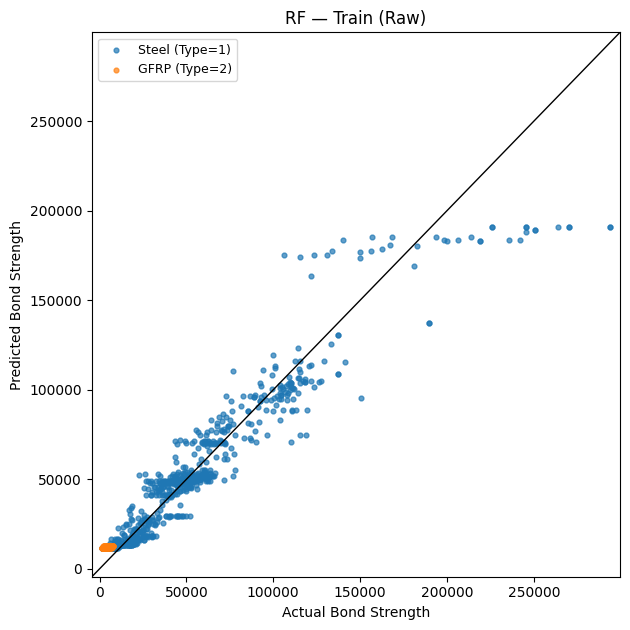

Saved: plots_by_type_safe/RF_train_raw_byType.png


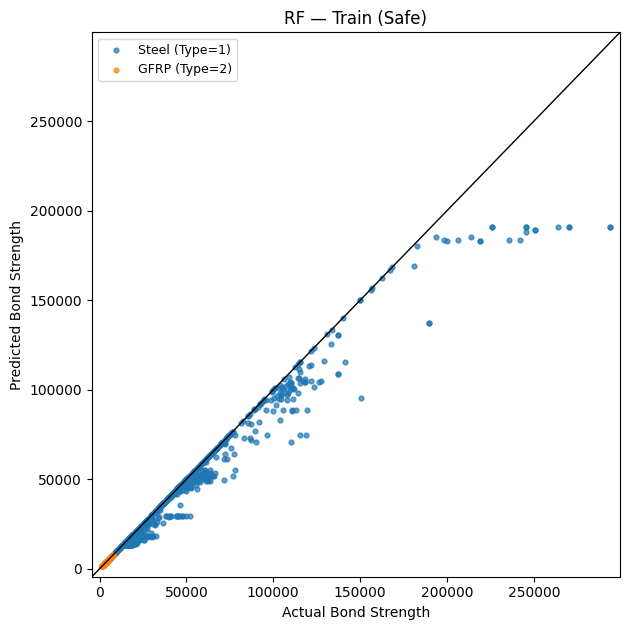

Saved: plots_by_type_safe/RF_train_safe_byType.png


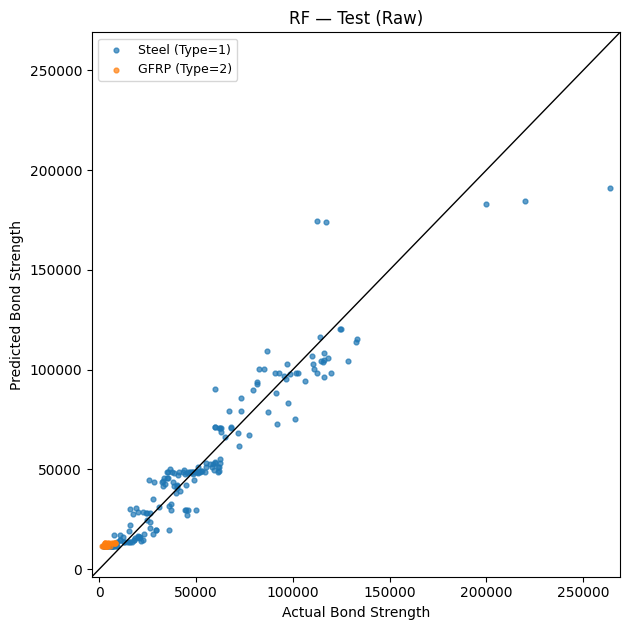

Saved: plots_by_type_safe/RF_test_raw_byType.png


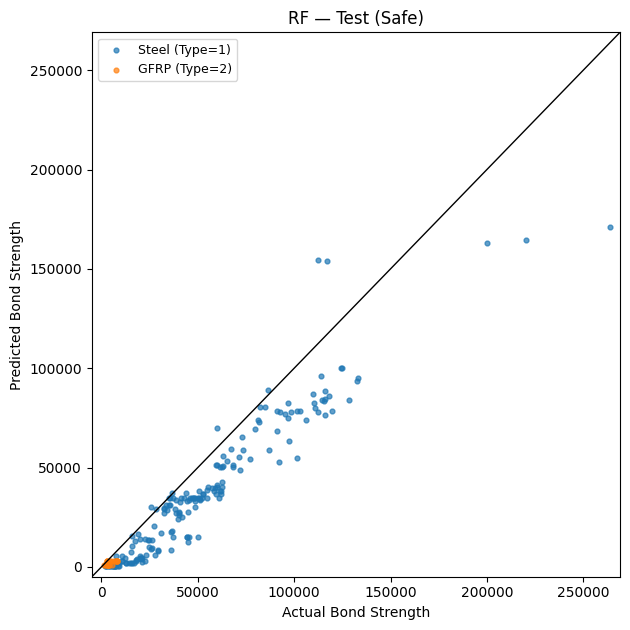

Saved: plots_by_type_safe/RF_test_safe_byType.png


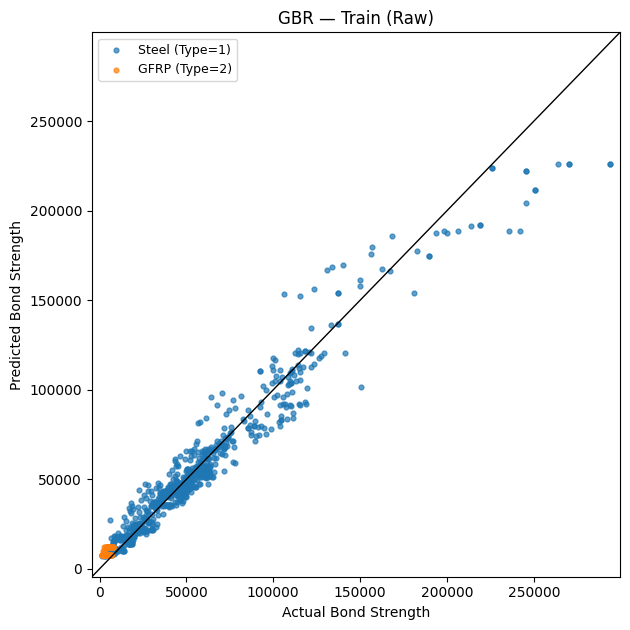

Saved: plots_by_type_safe/GBR_train_raw_byType.png


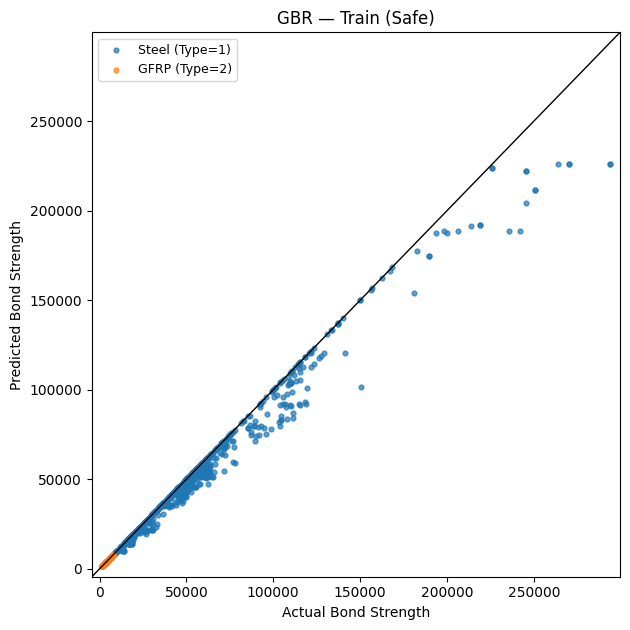

Saved: plots_by_type_safe/GBR_train_safe_byType.png


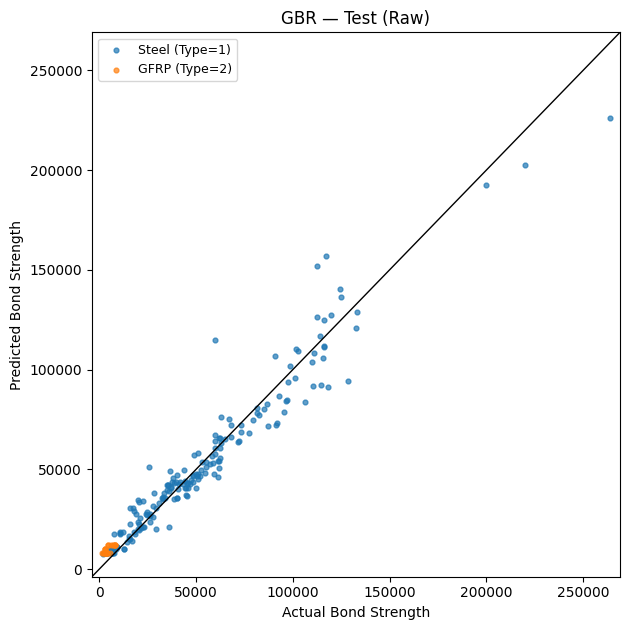

Saved: plots_by_type_safe/GBR_test_raw_byType.png


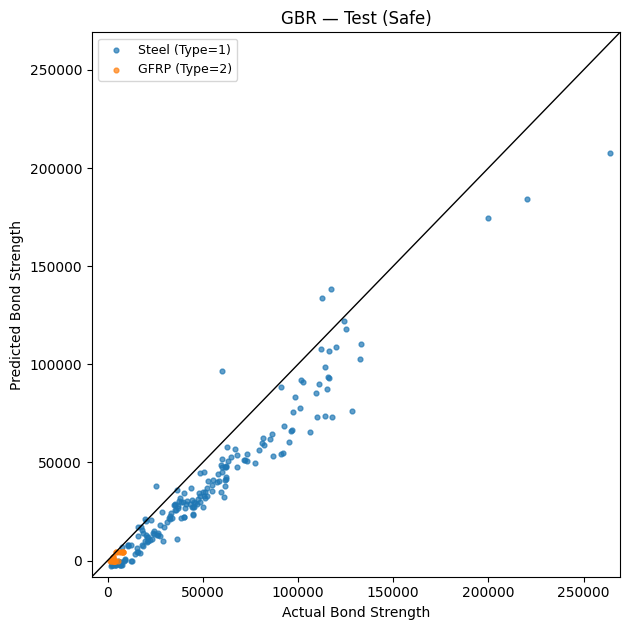

Saved: plots_by_type_safe/GBR_test_safe_byType.png


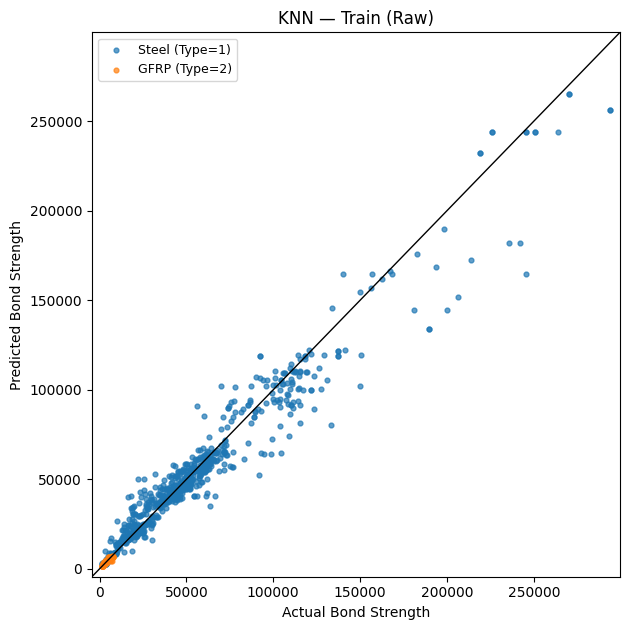

Saved: plots_by_type_safe/KNN_train_raw_byType.png


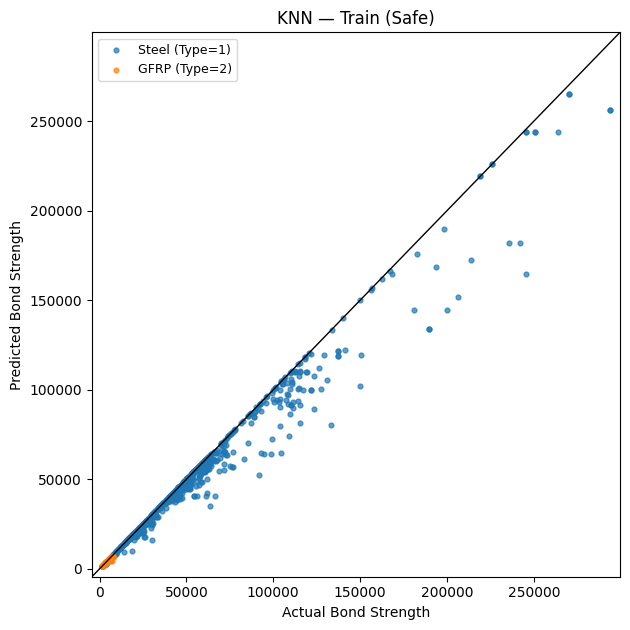

Saved: plots_by_type_safe/KNN_train_safe_byType.png


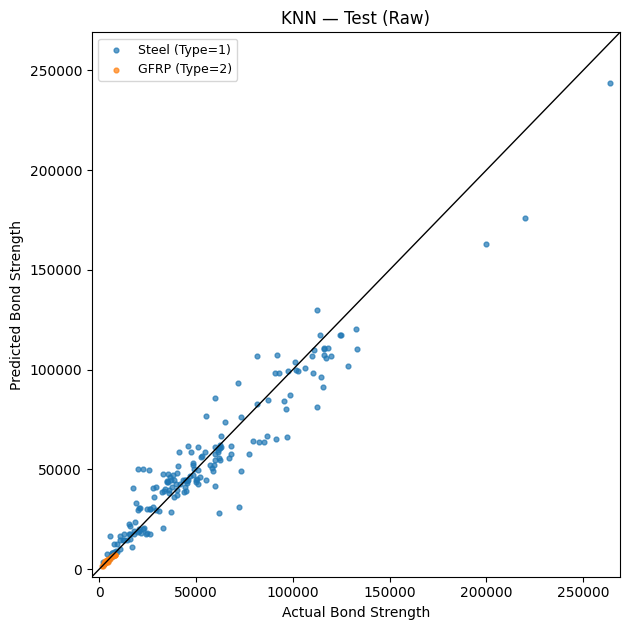

Saved: plots_by_type_safe/KNN_test_raw_byType.png


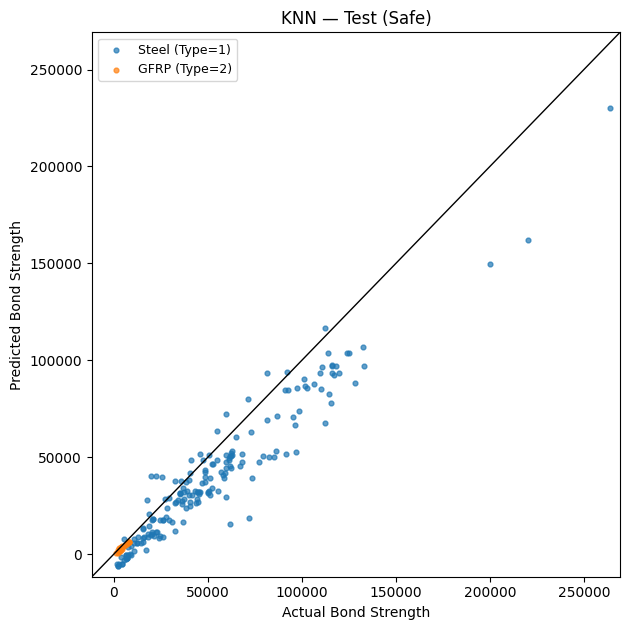

Saved: plots_by_type_safe/KNN_test_safe_byType.png


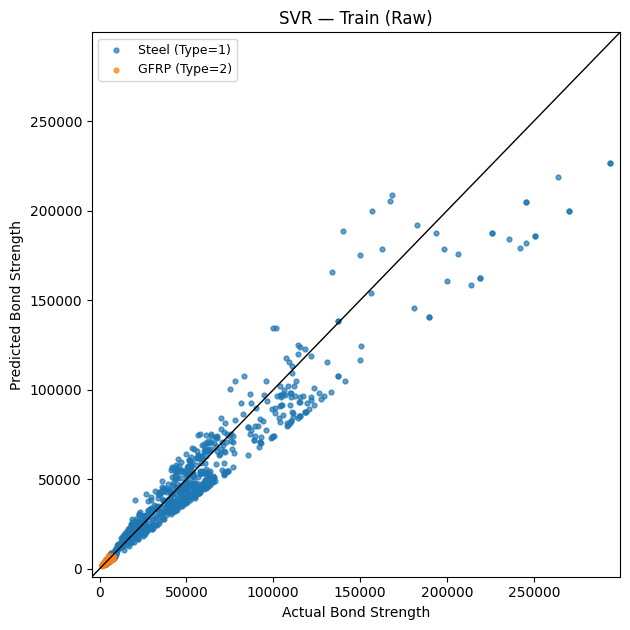

Saved: plots_by_type_safe/SVR_train_raw_byType.png


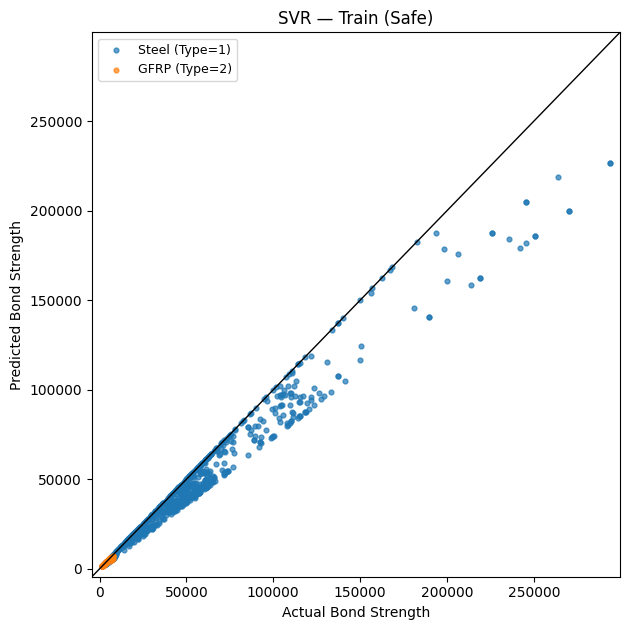

Saved: plots_by_type_safe/SVR_train_safe_byType.png


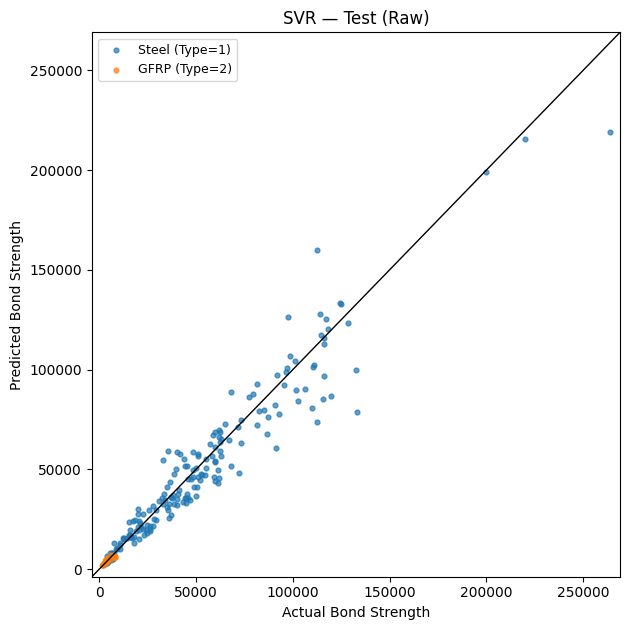

Saved: plots_by_type_safe/SVR_test_raw_byType.png


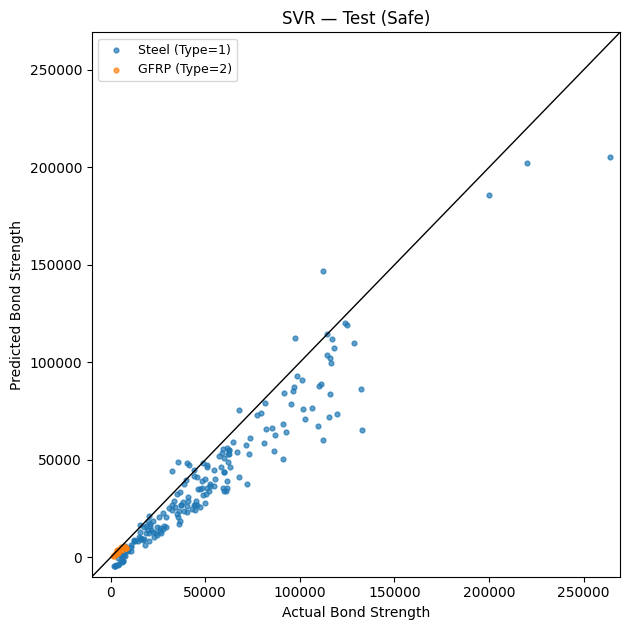

Saved: plots_by_type_safe/SVR_test_safe_byType.png


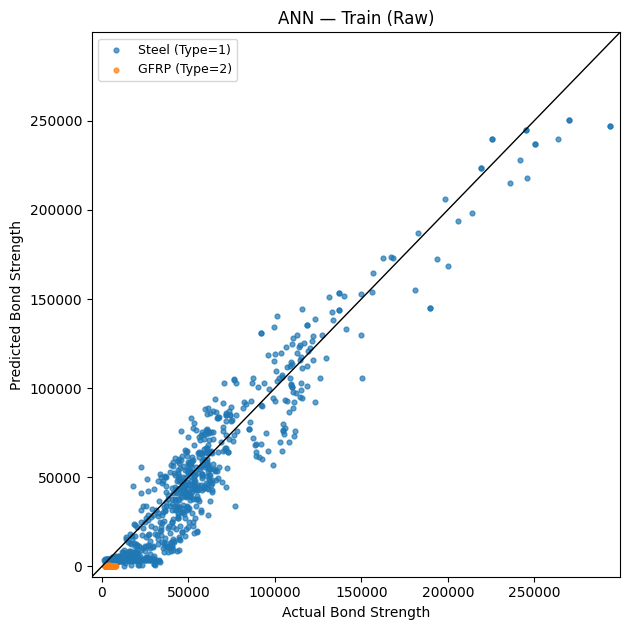

Saved: plots_by_type_safe/ANN_train_raw_byType.png


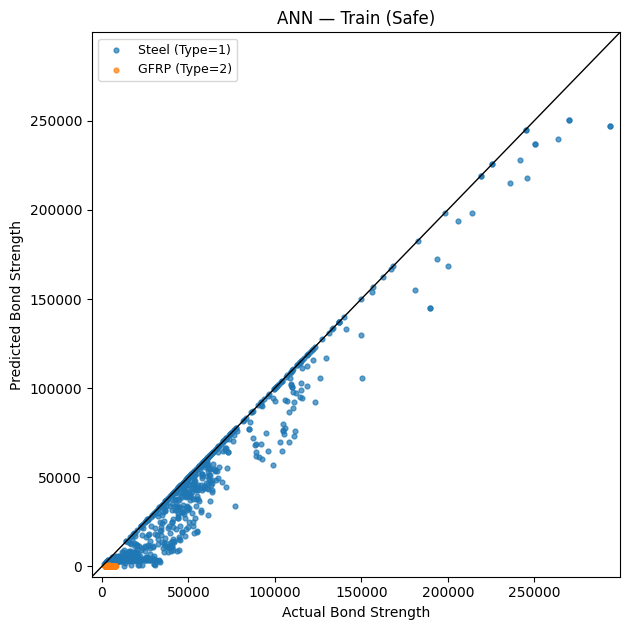

Saved: plots_by_type_safe/ANN_train_safe_byType.png


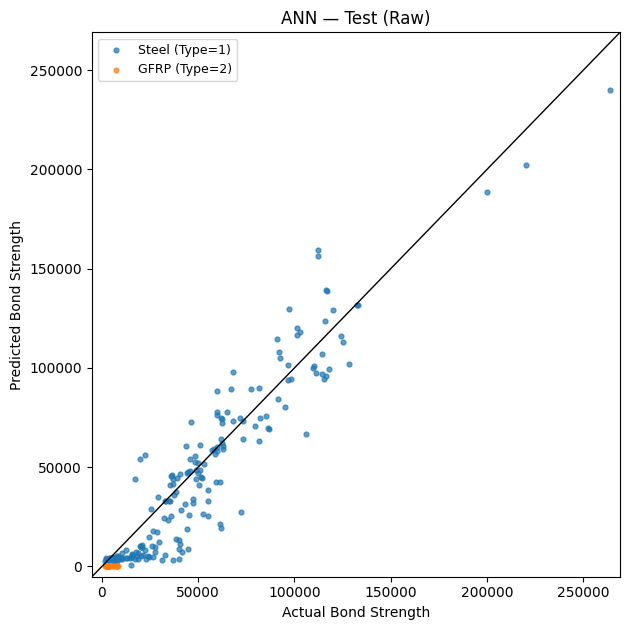

Saved: plots_by_type_safe/ANN_test_raw_byType.png


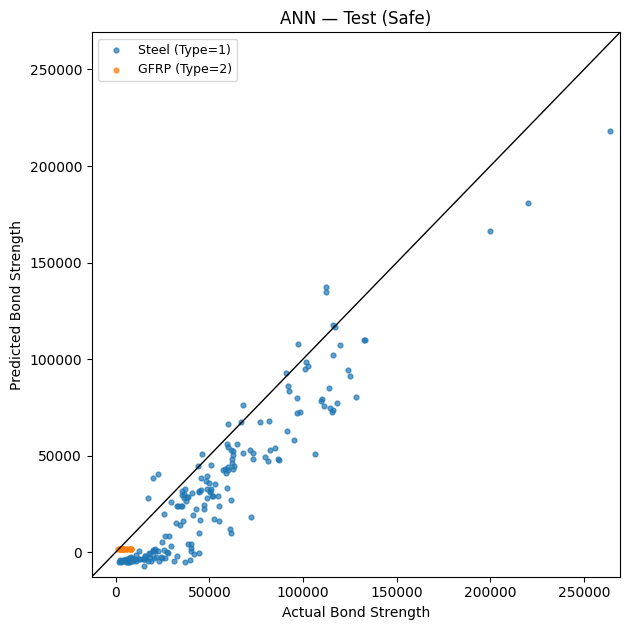

Saved: plots_by_type_safe/ANN_test_safe_byType.png


In [20]:
for m in models:
    # Train (raw)
    plot_by_type(
        y_true=y_tr,
        y_pred=train_preds[m],
        tvals=X_tr["Type"].values,
        title=f"{m} — Train (Raw)",
        fname=f"{out_dir}/{m}_train_raw_byType.png"
    )

    # Train (safe)  ⬅️ (ADDED — same style as Test Safe)
    yhat_train_safe = np.minimum(train_preds[m].ravel(), y_tr.ravel())
    plot_by_type(
        y_true=y_tr,
        y_pred=yhat_train_safe,
        tvals=X_tr["Type"].values,
        title=f"{m} — Train (Safe)",
        fname=f"{out_dir}/{m}_train_safe_byType.png"
    )

    # Test (raw)
    plot_by_type(
        y_true=y_te,
        y_pred=test_preds[m],
        tvals=X_te["Type"].values,
        title=f"{m} — Test (Raw)",
        fname=f"{out_dir}/{m}_test_raw_byType.png"
    )

    # Test (safe)
    if 'safe_test_store' in globals() and m in safe_test_store:
        plot_by_type(
            y_true=y_te,
            y_pred=safe_test_store[m],
            tvals=X_te["Type"].values,
            title=f"{m} — Test (Safe)",
            fname=f"{out_dir}/{m}_test_safe_byType.png"
        )
    else:
        print(f"⚠️ Safe predictions for {m} not found; skipping Test (Safe) plot.")


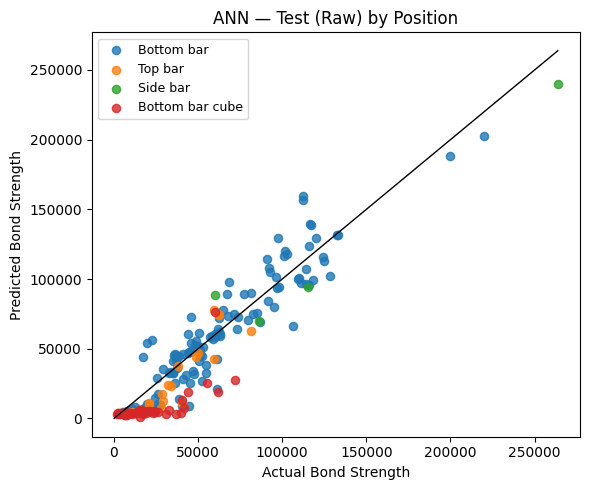

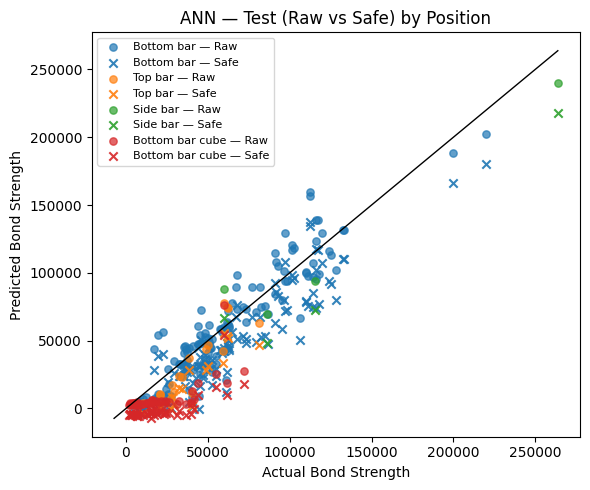

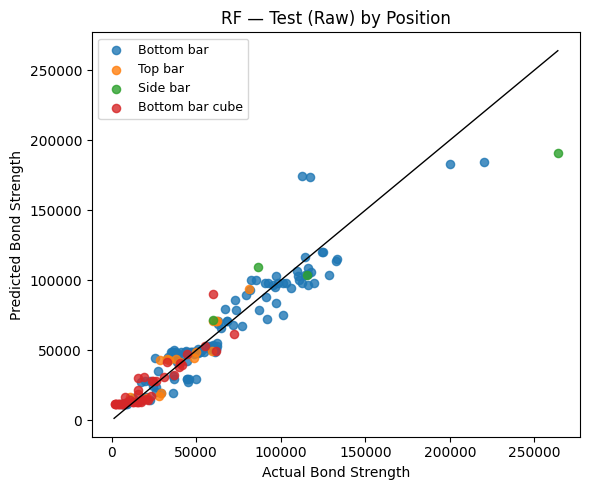

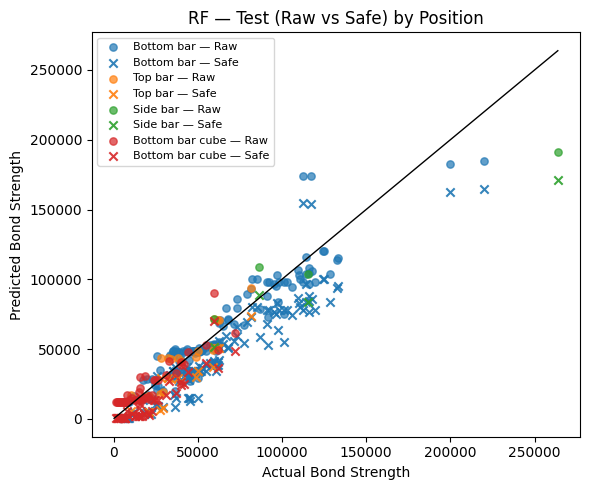

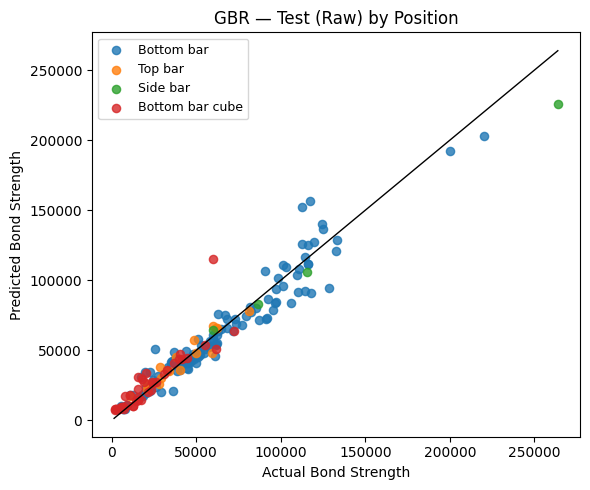

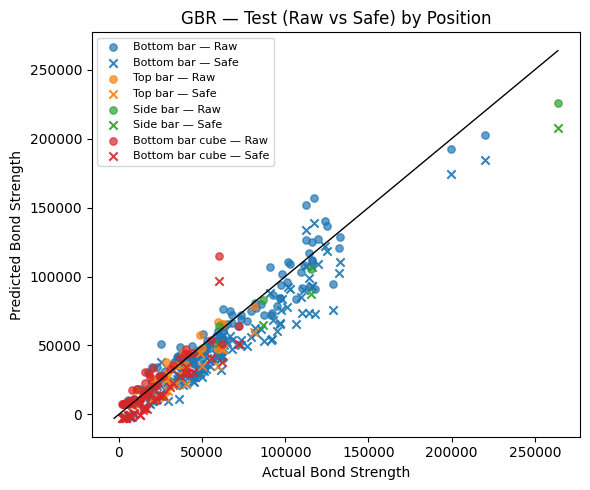

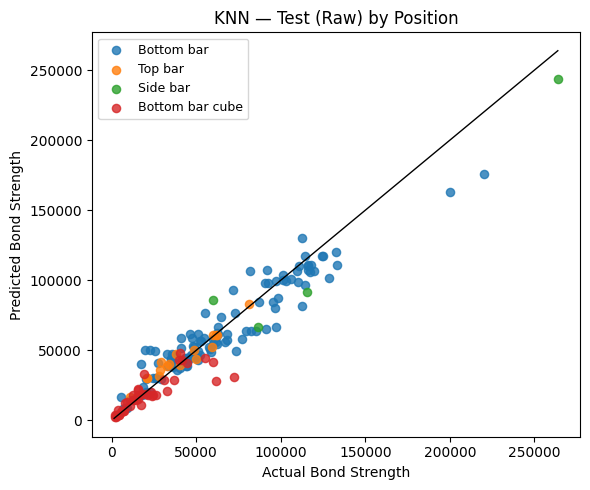

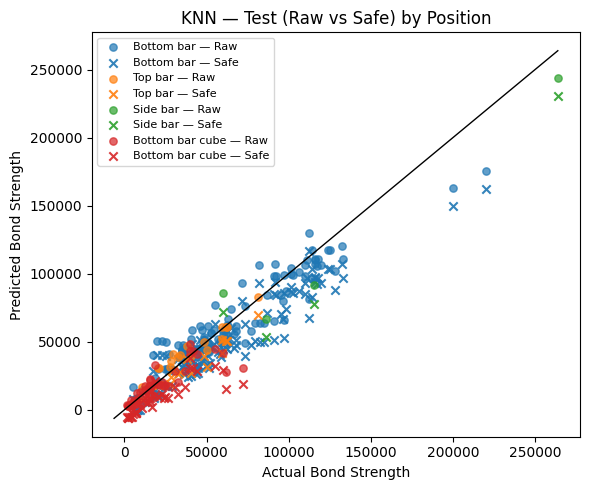

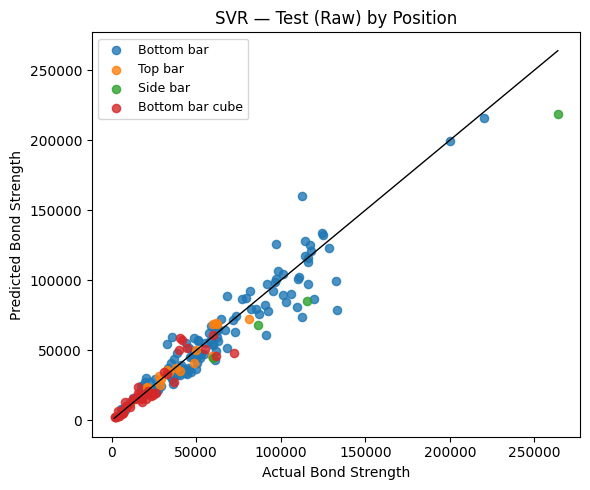

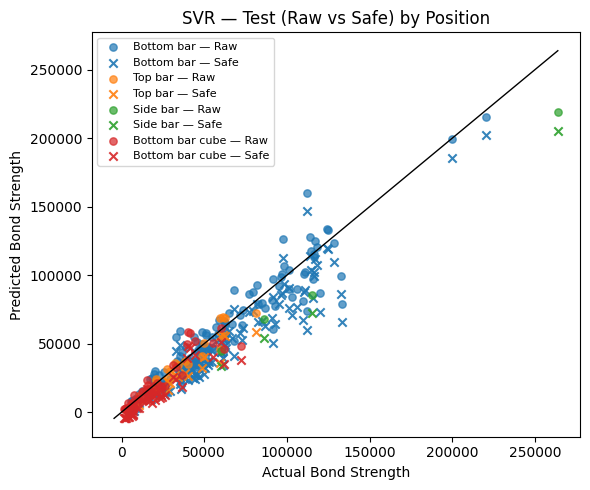

Done. If safe predictions are missing for some models, produce them by running the safety calibration cell (which populates `safe_test_store` or `safe_df`).


In [27]:
# === Plot Test Raw and Test Raw vs Safe for each base model ===
# Expects in-memory (preferred): y_te, test_preds (dict with keys ANN,RF,GBR,KNN,SVR), X_te (with Position)
# Optional: safe_test_store (dict) or safe_df CSV (safe_test_predictions_all_models.csv) with columns like 'GBR_test_safe'
# Will fallback to Type coloring if Position missing.

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

base_models = ["ANN","RF","GBR","KNN","SVR"]

# --- Helpers to load safe df if present ---
def load_csv_if_exists(p):
    if os.path.exists(p):
        try:
            return pd.read_csv(p)
        except Exception:
            try:
                return pd.read_excel(p)
            except Exception:
                return None
    return None

safe_df = globals().get("safe_df", None)
if safe_df is None:
    safe_df = load_csv_if_exists("safe_test_predictions_all_models.csv")
    if safe_df is None:
        safe_df = load_csv_if_exists("safe_test_predictions.csv")  # try alternate
# also check meta_safe file just in case
_meta_safe = load_csv_if_exists("meta_safe_predictions.csv")

# --- Required test target ---
if 'y_te' in globals():
    y_true = np.asarray(y_te).ravel()
else:
    # try to read from safe_df or meta files
    if safe_df is not None and 'y_test' in safe_df.columns:
        y_true = np.asarray(safe_df['y_test']).ravel()
        print("Loaded y_test from safe_test_predictions_all_models.csv")
    elif _meta_safe is not None and 'y_test' in _meta_safe.columns:
        y_true = np.asarray(_meta_safe['y_test']).ravel()
        print("Loaded y_test from meta_safe_predictions.csv")
    else:
        raise NameError("Test target y_te not found in memory or files. Make sure y_te exists.")

# --- Get Position or fallback to Type or single group ---
Xte = globals().get("X_te", None)
position_available = False
type_available = False
if Xte is not None:
    position_available = ("Position" in Xte.columns)
    type_available = ("Type" in Xte.columns)
else:
    # try to read Position/Type from safe_df or meta file
    if safe_df is not None:
        if "Position" in safe_df.columns:
            Xte = pd.DataFrame({"Position": safe_df["Position"]})
            position_available = True
        elif "Type" in safe_df.columns:
            Xte = pd.DataFrame({"Type": safe_df["Type"]})
            type_available = True
    elif _meta_safe is not None:
        if "Position" in _meta_safe.columns:
            Xte = pd.DataFrame({"Position": _meta_safe["Position"]})
            position_available = True
        elif "Type" in _meta_safe.columns:
            Xte = pd.DataFrame({"Type": _meta_safe["Type"]})
            type_available = True

if not position_available and type_available:
    print("⚠️ Position not found — coloring by Type instead.")
if not position_available and not type_available:
    print("⚠️ Neither Position nor Type found — points will be single color.")
    Xte = pd.DataFrame({"Position": np.zeros_like(y_true, dtype=int)})
    position_available = True

positions = np.asarray(Xte["Position"].values).ravel() if position_available else np.asarray(Xte["Type"].values).ravel()

# Build color map
unique_pos = np.unique(positions[~np.isnan(positions)].astype(int)) if positions.size>0 else np.array([0])
cmap = plt.get_cmap("tab10")
color_map = {int(p): cmap(i % 10) for i,p in enumerate(sorted(unique_pos))}
POSITION_LABELS = {1: "Bottom bar", 2: "Top bar", 3: "Side bar", 4: "Bottom bar cube"}
pos_labels = {p: POSITION_LABELS.get(p, f"Pos {p}") for p in unique_pos}

# --- Get raw and safe predictions per model (with fallbacks) ---
def get_raw_preds(model_name):
    # prefer test_preds dict
    if 'test_preds' in globals() and isinstance(test_preds, dict) and model_name in test_preds:
        return np.asarray(test_preds[model_name]).ravel()
    # try test_oof_df if exists
    if 'test_oof_df' in globals() and model_name in test_oof_df.columns:
        return np.asarray(test_oof_df[model_name]).ravel()
    # try safe_df columns pattern 'Model_test_raw' or 'Model_test'
    if safe_df is not None:
        for col in [f"{model_name}_test_raw", f"{model_name}_test", f"{model_name}_raw"]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
    # not found
    return None

def get_safe_preds(model_name):
    # prefer safe_test_store dict
    if 'safe_test_store' in globals() and isinstance(safe_test_store, dict) and model_name in safe_test_store:
        return np.asarray(safe_test_store[model_name]).ravel()
    # try safe_df columns pattern
    if safe_df is not None:
        for col in [f"{model_name}_test_safe", f"{model_name}_safe", f"{model_name}_test_safe"]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
    # try meta_safe for Meta only (not here)
    return None

# --- Loop models and plot ---
for model_name in base_models:
    raw_pred = get_raw_preds(model_name)
    safe_pred = get_safe_preds(model_name)

    if raw_pred is None:
        print(f"⚠️ Raw predictions for {model_name} not found — skipping.")
        continue

    # Ensure lengths match y_true
    if len(raw_pred) != len(y_true):
        print(f"⚠️ Length mismatch for {model_name} raw preds ({len(raw_pred)}) vs y_test ({len(y_true)}). Skipping.")
        continue
    if safe_pred is not None and len(safe_pred) != len(y_true):
        print(f"⚠️ Length mismatch for {model_name} safe preds — ignoring safe for this model.")
        safe_pred = None

    # Plot A: Test - Raw colored by Position
    plt.figure(figsize=(6,5))
    for p in sorted(unique_pos):
        mask = (positions == p)
        if mask.sum() == 0: continue
        plt.scatter(y_true[mask], raw_pred[mask], s=35, alpha=0.8, color=color_map[int(p)], label=pos_labels[p])
    lims_min = min(y_true.min(), raw_pred.min())
    lims_max = max(y_true.max(), raw_pred.max())
    plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
    plt.title(f"{model_name} — Test (Raw) by Position")
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Predicted Bond Strength")
    plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

    # Plot B: Test - Raw vs Safe (overlay)
    plt.figure(figsize=(6,5))
    for p in sorted(unique_pos):
        mask = (positions == p)
        if mask.sum() == 0: continue
        plt.scatter(y_true[mask], raw_pred[mask], s=28, alpha=0.7, marker='o', color=color_map[int(p)], label=f"{pos_labels[p]} — Raw")
        if safe_pred is not None:
            plt.scatter(y_true[mask], safe_pred[mask], s=36, alpha=0.9, marker='x', color=color_map[int(p)], label=f"{pos_labels[p]} — Safe")
    lims_min = min(y_true.min(), raw_pred.min(), (safe_pred.min() if safe_pred is not None else y_true.min()))
    lims_max = max(y_true.max(), raw_pred.max(), (safe_pred.max() if safe_pred is not None else y_true.max()))
    plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
    plt.title(f"{model_name} — Test (Raw vs Safe) by Position")
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Predicted Bond Strength")
    # clean legend (unique labels)
    handles, labels_ = plt.gca().get_legend_handles_labels()
    seen = set(); uniq_h = []; uniq_l = []
    for h, l in zip(handles, labels_):
        if l not in seen:
            uniq_h.append(h); uniq_l.append(l); seen.add(l)
    plt.legend(uniq_h, uniq_l, loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

print("Done. If safe predictions are missing for some models, produce them by running the safety calibration cell (which populates `safe_test_store` or `safe_df`).")



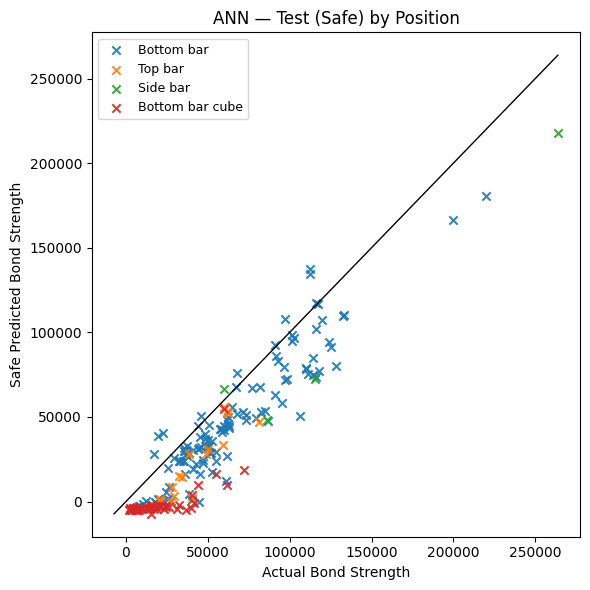

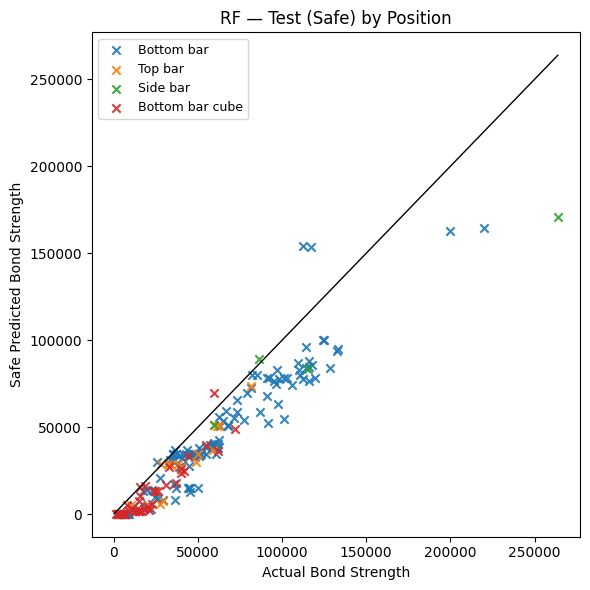

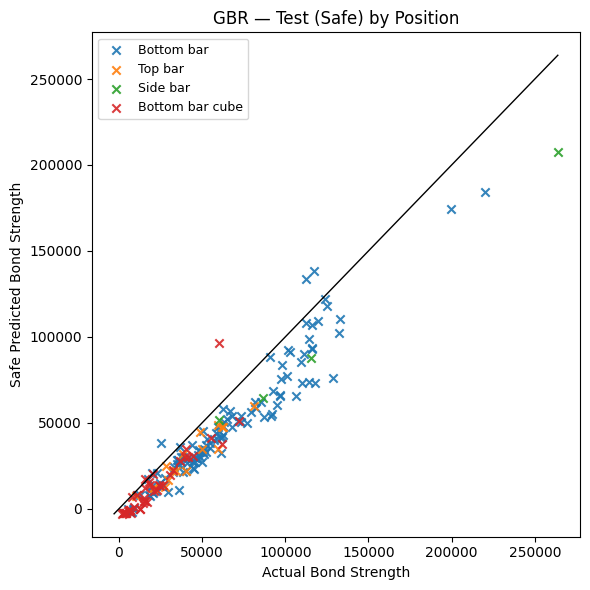

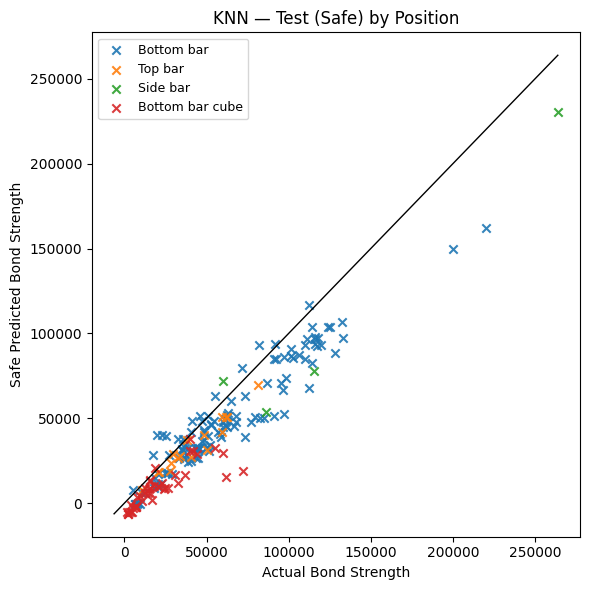

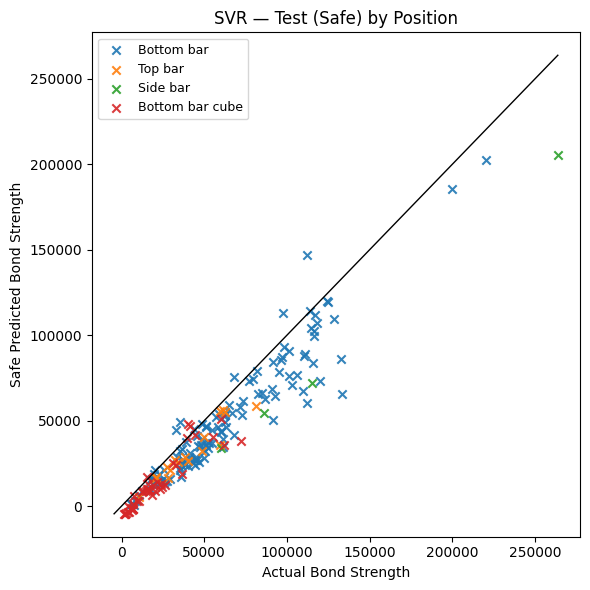

Done — Test (Safe) plots by Position for base models.


In [29]:
# === Plot Test (Safe) predictions by Position for base models ===
# Requirements (in Colab workspace):
#  - y_te (test targets)
#  - safe_test_store (dict with keys: "ANN","RF","GBR","KNN","SVR") OR
#    safe_test_predictions_all_models.csv / safe_test_predictions.csv with columns like 'GBR_test_safe'
#  - X_te dataframe with column "Position" (or fall back to "Type")

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

base_models = ["ANN","RF","GBR","KNN","SVR"]

# Try in-memory safe_test_store first
safe_store = globals().get("safe_test_store", None)

# Try to load CSV fallback if needed
def try_load(path):
    if os.path.exists(path):
        try:
            return pd.read_csv(path)
        except Exception:
            try:
                return pd.read_excel(path)
            except Exception:
                return None
    return None

safe_df = None
if safe_store is None:
    safe_df = try_load("safe_test_predictions_all_models.csv") or try_load("safe_test_predictions.csv")

# Get y_test (required)
if 'y_te' in globals():
    y_true = np.asarray(y_te).ravel()
else:
    if safe_df is not None and 'y_test' in safe_df.columns:
        y_true = np.asarray(safe_df['y_test']).ravel()
        print("Loaded y_test from safe_test_predictions file.")
    else:
        raise NameError("y_te (test targets) not found. Provide y_te in memory or safe_test_predictions file with 'y_test' column.")

# Get Position (preferred) or Type fallback
Xte = globals().get("X_te", None)
if Xte is None:
    # attempt to read position/type from safe_df
    if safe_df is not None:
        if "Position" in safe_df.columns:
            Xte = pd.DataFrame({"Position": safe_df["Position"].values})
        elif "Type" in safe_df.columns:
            Xte = pd.DataFrame({"Type": safe_df["Type"].values})
        else:
            Xte = pd.DataFrame({"Position": np.zeros_like(y_true, dtype=int)})
    else:
        raise NameError("X_te not found in memory and safe_test file not available. Provide X_te with Position or Type column.")

# choose grouping column
if "Position" in Xte.columns:
    group_col = "Position"
elif "Type" in Xte.columns:
    group_col = "Type"
else:
    group_col = None

if group_col is None:
    positions = np.zeros_like(y_true, dtype=int)
    print("⚠️ No Position/Type found — plotting without grouping colors.")
else:
    positions = np.asarray(Xte[group_col].values).ravel()

# Color mapping
unique_pos = np.unique(positions[~np.isnan(positions)].astype(int)) if positions.size>0 else np.array([0])
cmap = plt.get_cmap("tab10")
color_map = {int(p): cmap(i % 10) for i,p in enumerate(sorted(unique_pos))}
POSITION_LABELS = {1: "Bottom bar", 2: "Top bar", 3: "Side bar", 4: "Bottom bar cube"}
pos_labels = {p: POSITION_LABELS.get(p, f"{group_col} {p}") for p in unique_pos}

# Helper to get safe preds for a model
def get_safe_preds(model_name):
    # 1) safe_test_store dict
    if safe_store is not None and isinstance(safe_store, dict) and model_name in safe_store:
        arr = np.asarray(safe_store[model_name]).ravel()
        return arr
    # 2) safe_df columns like 'GBR_test_safe' or 'GBR_safe'
    if safe_df is not None:
        for col in [f"{model_name}_test_safe", f"{model_name}_safe", f"{model_name}_testsafe", f"{model_name}_safe_pred"]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
    return None

# Plot per base model: Actual vs Safe-Predicted colored by Position
for model_name in base_models:
    safe_pred = get_safe_preds(model_name)
    if safe_pred is None:
        print(f"⚠️ Safe predictions for {model_name} not found. Skipping {model_name}.")
        continue
    if len(safe_pred) != len(y_true):
        print(f"⚠️ Length mismatch for {model_name} safe preds ({len(safe_pred)}) vs y_test ({len(y_true)}). Skipping.")
        continue

    plt.figure(figsize=(6,6))
    for p in sorted(unique_pos):
        mask = (positions == p)
        if mask.sum() == 0:
            continue
        plt.scatter(y_true[mask], safe_pred[mask], s=36, alpha=0.9, marker='x',
                    color=color_map[int(p)], label=pos_labels[p])

    lims_min = min(y_true.min(), safe_pred.min())
    lims_max = max(y_true.max(), safe_pred.max())
    plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
    plt.title(f"{model_name} — Test (Safe) by {group_col or 'All'}")
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Safe Predicted Bond Strength")
    # tidy legend
    handles, labels_ = plt.gca().get_legend_handles_labels()
    seen = set(); uniq_h = []; uniq_l = []
    for h, l in zip(handles, labels_):
        if l not in seen:
            uniq_h.append(h); uniq_l.append(l); seen.add(l)
    plt.legend(uniq_h, uniq_l, loc="best", fontsize=9)
    plt.tight_layout()
    plt.show()

print("Done — Test (Safe) plots by Position for base models.")



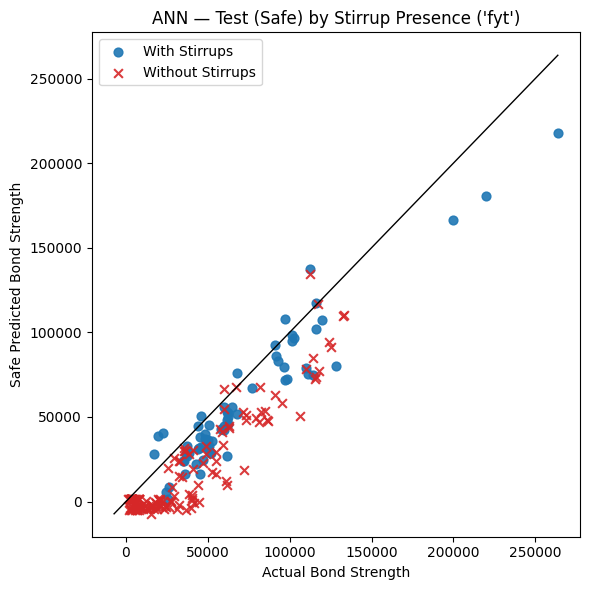

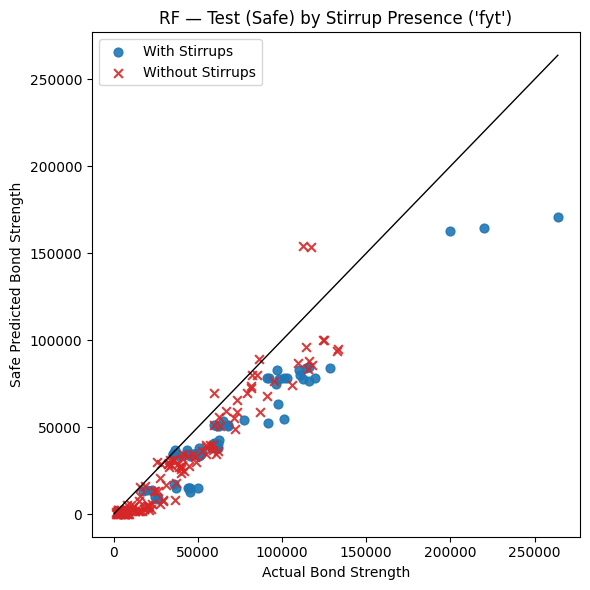

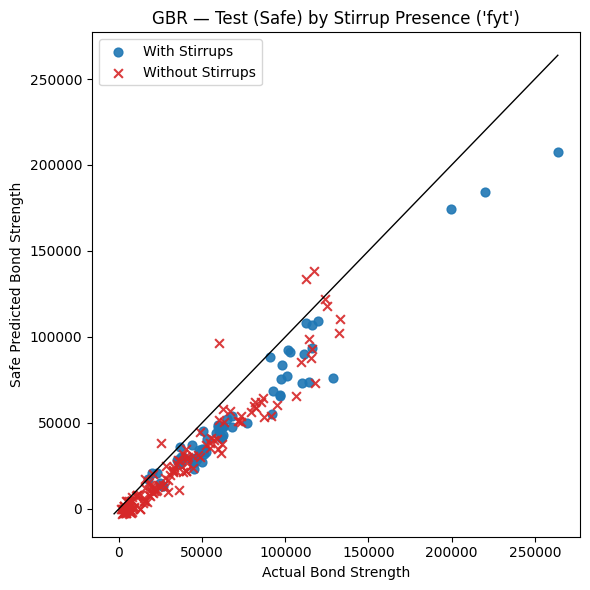

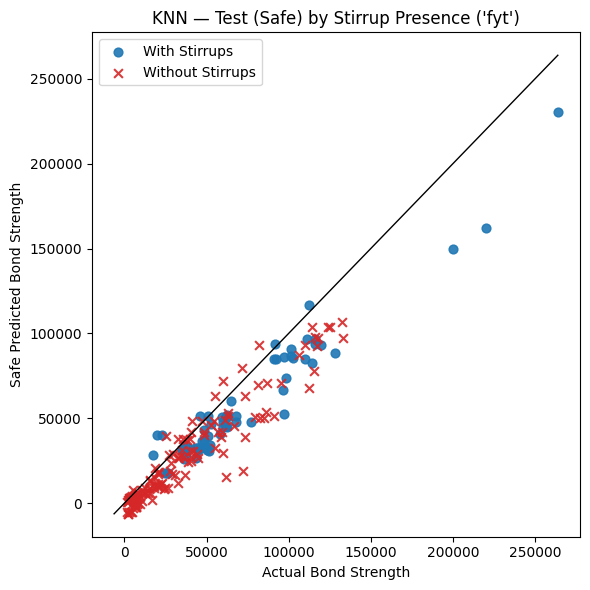

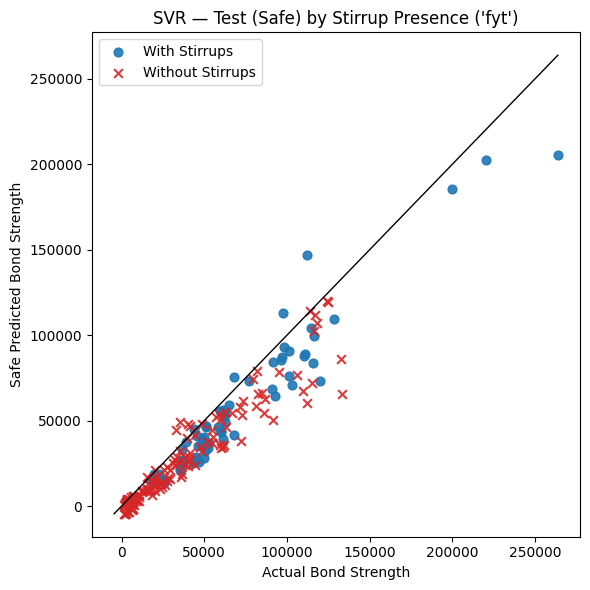

Done — Test (Safe) plots by stirrup presence (fyt).


In [33]:
# === Test (Safe) plots by Stirrup Presence (legend: "With Stirrups" / "Without Stirrups") ===
# Requirements in Colab:
#  - y_te (test targets)
#  - safe_test_store (dict with keys like "ANN","RF","GBR","KNN","SVR") OR
#    safe_test_predictions_all_models.csv (columns like 'GBR_test_safe')
#  - X_te dataframe with a column indicating stirrup presence (defaults to 'fyt')
#
# This cell will try 'fyt' first, then fallback to common names ['Stirrups','Transverse'].
# It will plot Actual vs Safe-Predicted for each base model, colored by stirrup presence:
#   - With Stirrups (fyt==1)  → color A
#   - Without Stirrups (fyt==0) → color B

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

base_models = ["ANN","RF","GBR","KNN","SVR"]

# --- Try in-memory safe_test_store first ---
safe_store = globals().get("safe_test_store", None)

# --- Try file fallback ---
def try_load(path):
    if os.path.exists(path):
        try:
            return pd.read_csv(path)
        except Exception:
            try:
                return pd.read_excel(path)
            except Exception:
                return None
    return None

safe_df = None
if safe_store is None:
    safe_df = try_load("safe_test_predictions_all_models.csv") or try_load("safe_test_predictions.csv")

# --- y_test (required) ---
if 'y_te' in globals():
    y_true = np.asarray(y_te).ravel()
else:
    if safe_df is not None and 'y_test' in safe_df.columns:
        y_true = np.asarray(safe_df['y_test']).ravel()
        print("Loaded y_test from safe_test_predictions file.")
    else:
        raise NameError("y_te (test targets) not found. Provide y_te in memory or safe_test_predictions file with 'y_test' column.")

# --- X_te and locate stirrup column ---
Xte = globals().get("X_te", None)
possible_cols = ["fyt", "Stirrups", "Transverse", "stirrup", "has_stirrups"]

# If X_te missing, try to extract from safe_df
if Xte is None and safe_df is not None:
    for c in possible_cols:
        if c in safe_df.columns:
            Xte = pd.DataFrame({c: safe_df[c].values})
            print(f"Loaded {c} from safe_test_predictions file into X_te.")
            break

if Xte is None:
    raise NameError("X_te not found in memory and no Position/Type/stirrup info available in fallback files. Provide X_te with stirrup column.")

# find column name
st_col = None
for c in possible_cols:
    if c in Xte.columns:
        st_col = c
        break

if st_col is None:
    # If none found, but there is a 'Type' column we can't use it for stirrups; fail gracefully
    print("⚠️ No obvious stirrup column found (tried fyt/Stirrups/Transverse...).")
    print("   If you have a different column name for stirrup presence, either rename it to 'fyt' or edit possible_cols.")
    # create a default column of zeros to avoid crash (will plot all as 'Without Stirrups')
    Xte = Xte.copy()
    Xte['fyt'] = 0
    st_col = 'fyt'

# ensure numeric 0/1
st_values = np.asarray(Xte[st_col].fillna(0).astype(int).values).ravel()

# color mapping
color_with   = "#1f77b4"  # blue-ish
color_without= "#d62728"  # red-ish

label_with = "With Stirrups"
label_without = "Without Stirrups"

# --- helper to get safe preds for a model ---
def get_safe_preds(model_name):
    # priority 1: safe_store dict
    if safe_store is not None and isinstance(safe_store, dict) and model_name in safe_store:
        return np.asarray(safe_store[model_name]).ravel()
    # priority 2: safe_df columns patterns
    if safe_df is not None:
        for col in [f"{model_name}_test_safe", f"{model_name}_safe", f"{model_name}_testsafe", f"{model_name}_safe_pred"]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
    # not found
    return None

# --- Plot per base model: Test (Safe) colored by stirrup presence ---
for model_name in base_models:
    safe_pred = get_safe_preds(model_name)
    if safe_pred is None:
        print(f"⚠️ Safe predictions for {model_name} not found. Skipping {model_name}.")
        continue

    # length check
    if len(safe_pred) != len(y_true):
        print(f"⚠️ Length mismatch for {model_name} safe preds ({len(safe_pred)}) vs y_test ({len(y_true)}). Skipping.")
        continue

    plt.figure(figsize=(6,6))
    # with stirrups (fyt == 1)
    mask_with = (st_values == 1)
    if mask_with.sum() > 0:
        plt.scatter(y_true[mask_with], safe_pred[mask_with], s=40, marker='o', alpha=0.9, color=color_with, label=label_with)
    # without stirrups (fyt == 0)
    mask_without = (st_values == 0)
    if mask_without.sum() > 0:
        plt.scatter(y_true[mask_without], safe_pred[mask_without], s=40, marker='x', alpha=0.9, color=color_without, label=label_without)

    lims_min = min(y_true.min(), safe_pred.min())
    lims_max = max(y_true.max(), safe_pred.max())
    plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
    plt.title(f"{model_name} — Test (Safe) by Stirrup Presence ('{st_col}')")
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Safe Predicted Bond Strength")
    plt.legend(loc="best", fontsize=10)
    plt.tight_layout()
    plt.show()

print("Done — Test (Safe) plots by stirrup presence (fyt).")



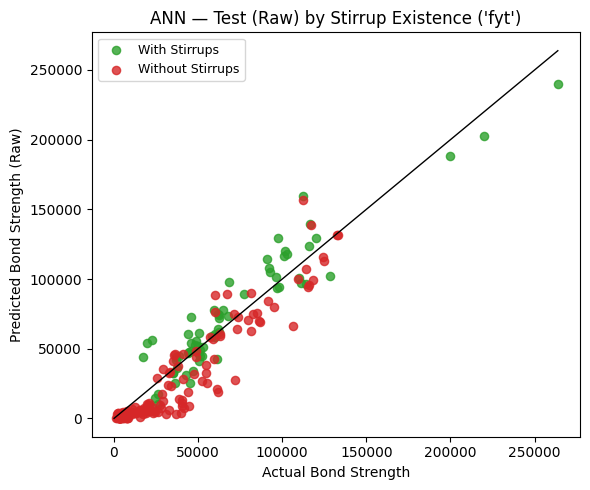

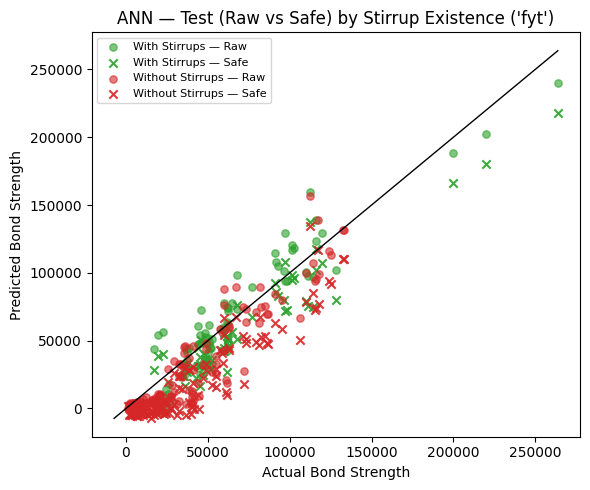

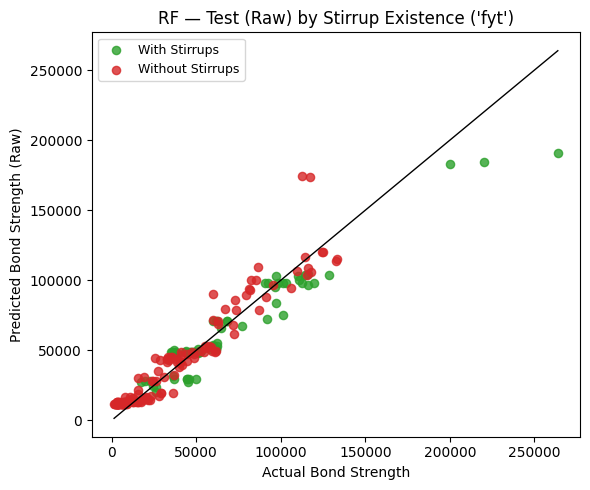

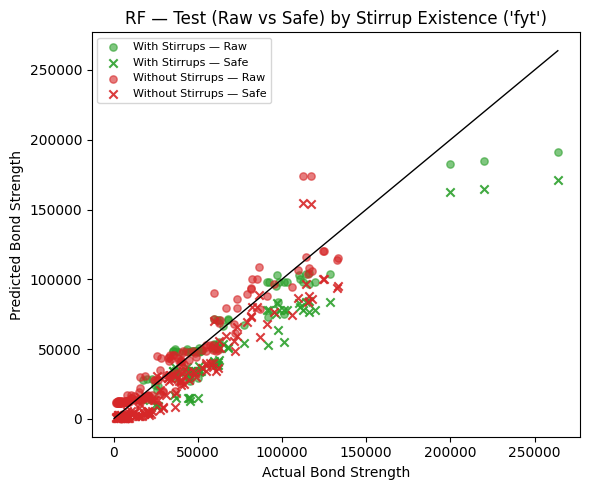

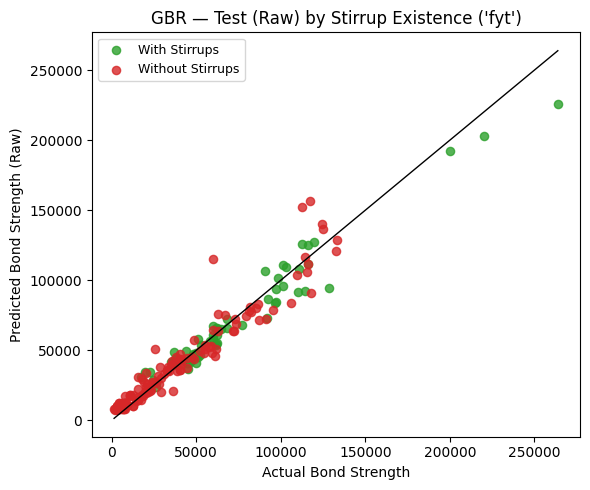

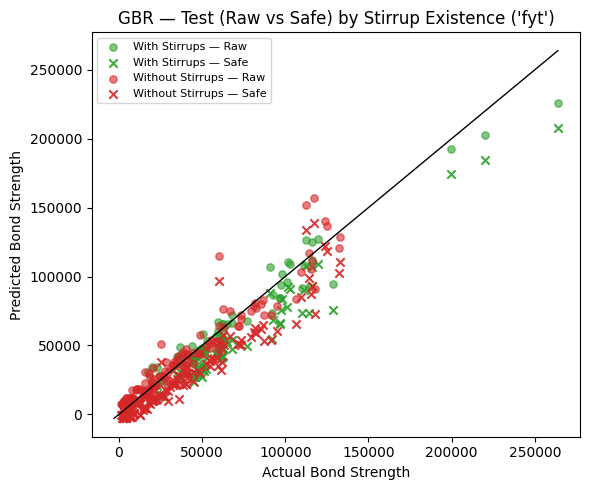

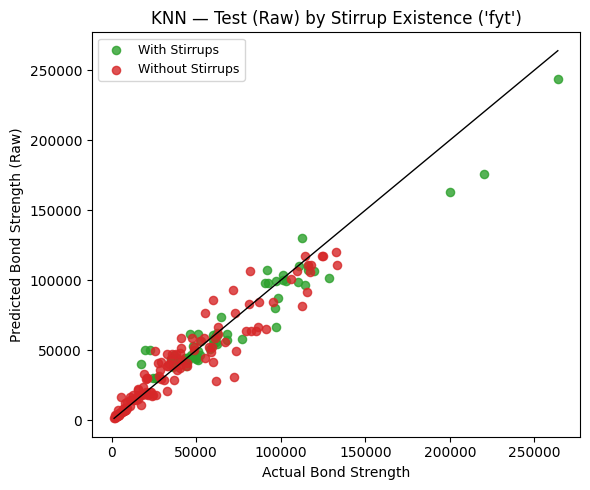

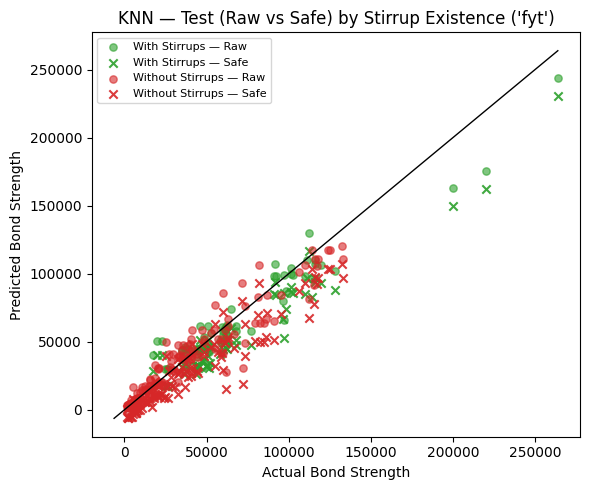

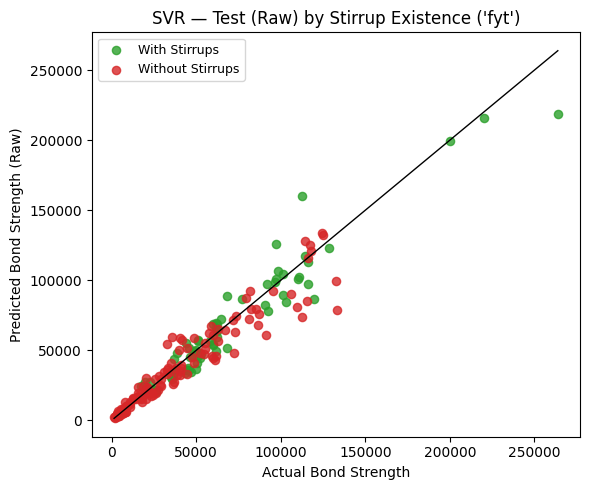

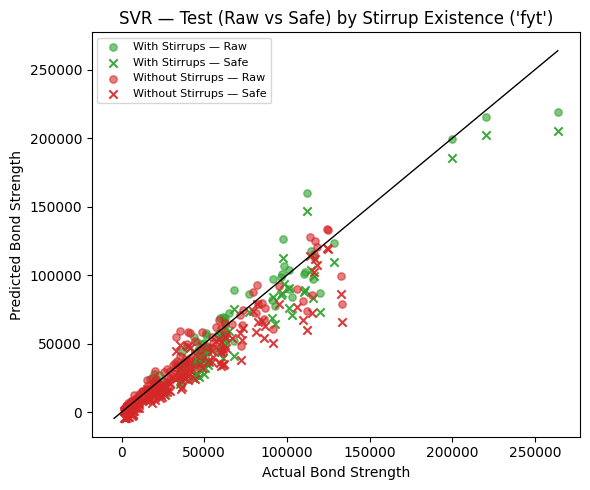

Done. If safe predictions are missing for some models, produce them by running the safety calibration cell (which populates `safe_test_store` or `safe_df`).


In [38]:
# === Plot Test Raw and Test Raw vs Safe for each base model, grouped by stirrup existence (fyt) ===
# Expects in-memory (preferred): y_te, test_preds (dict with keys ANN,RF,GBR,KNN,SVR), X_te (with column 'fyt')
# Optional: safe_test_store (dict) or safe_df CSV (safe_test_predictions_all_models.csv) with columns like 'GBR_test_safe'
# Falls back to reading raw/safe CSVs if in-memory vars are missing.

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

base_models = ["ANN","RF","GBR","KNN","SVR"]

# --- Helpers to load fallback CSV/XLS files ---
def load_if_exists(path):
    if os.path.exists(path):
        try:
            return pd.read_csv(path)
        except Exception:
            try:
                return pd.read_excel(path)
            except Exception:
                return None
    return None

safe_df = globals().get("safe_df", None)
if safe_df is None:
    safe_df = load_if_exists("safe_test_predictions_all_models.csv")
    if safe_df is None:
        safe_df = load_if_exists("safe_test_predictions.csv")  # alternate

raw_df = load_if_exists("test_oof_df.csv") or load_if_exists("test_predictions.csv") or load_if_exists("test_oof_df.xlsx")

# --- Required test target ---
if 'y_te' in globals():
    y_true = np.asarray(y_te).ravel()
else:
    # try to read from safe_df or raw_df
    if safe_df is not None and 'y_test' in safe_df.columns:
        y_true = np.asarray(safe_df['y_test']).ravel()
        print("Loaded y_test from safe_test_predictions file.")
    elif raw_df is not None and 'y_test' in raw_df.columns:
        y_true = np.asarray(raw_df['y_test']).ravel()
        print("Loaded y_test from test_predictions file.")
    else:
        raise NameError("Test target y_te not found in memory or fallback files. Make sure y_te exists or 'y_test' is in a fallback file.")

# --- Find fyt (stirrup existence) in X_te or fallback files ---
Xte = globals().get("X_te", None)
possible_st_cols = ["fyt", "Stirrups", "Transverse", "stirrup", "has_stirrups"]

if Xte is None:
    # try to load fyt from safe_df or raw_df
    if safe_df is not None:
        for c in possible_st_cols:
            if c in safe_df.columns:
                Xte = pd.DataFrame({c: safe_df[c].values})
                print(f"Loaded '{c}' from safe_test_predictions file into X_te fallback.")
                break
    if Xte is None and raw_df is not None:
        for c in possible_st_cols:
            if c in raw_df.columns:
                Xte = pd.DataFrame({c: raw_df[c].values})
                print(f"Loaded '{c}' from test_predictions file into X_te fallback.")
                break

if Xte is None:
    raise NameError("X_te not found and no fallback found. Provide X_te with 'fyt' column (1/0).")

# normalize column name: find which column to use
st_col = None
for c in possible_st_cols:
    if c in Xte.columns:
        st_col = c
        break

if st_col is None:
    print("⚠️ No stirrup column found (tried fyt/Stirrups/Transverse...). Defaulting all to fyt=0.")
    Xte = Xte.copy()
    Xte['fyt'] = 0
    st_col = 'fyt'

# ensure integer 0/1 values
st_values = np.asarray(Xte[st_col].fillna(0).astype(int).values).ravel()

# Build color map & labels
COLOR_WITH    = "#2ca02c"   # green
COLOR_WITHOUT = "#d62728"   # red
LABEL_WITH    = "With Stirrups"
LABEL_WITHOUT = "Without Stirrups"

# --- Prediction fetchers (raw & safe) with same fallback logic as before ---
def get_raw_preds(model_name):
    # prefer test_preds dict in memory
    if 'test_preds' in globals() and isinstance(test_preds, dict) and model_name in test_preds:
        return np.asarray(test_preds[model_name]).ravel()
    # try test_oof_df if in memory
    if 'test_oof_df' in globals() and model_name in test_oof_df.columns:
        return np.asarray(test_oof_df[model_name]).ravel()
    # try raw_df fallback
    if raw_df is not None:
        for col in [f"{model_name}_test_raw", f"{model_name}_raw", f"{model_name}_test", model_name]:
            if col in raw_df.columns:
                return np.asarray(raw_df[col]).ravel()
    # try safe_df as last resort (raw columns sometimes present)
    if safe_df is not None:
        for col in [f"{model_name}_test_raw", f"{model_name}_raw", f"{model_name}_test", model_name]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
    return None

def get_safe_preds(model_name):
    # prefer safe_test_store dict
    if 'safe_test_store' in globals() and isinstance(safe_test_store, dict) and model_name in safe_test_store:
        return np.asarray(safe_test_store[model_name]).ravel()
    # fallback to safe_df columns pattern
    if safe_df is not None:
        for col in [f"{model_name}_test_safe", f"{model_name}_safe", f"{model_name}_testsafe", f"{model_name}_safe_pred"]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
        # try case-insensitive match
        for col in safe_df.columns:
            if model_name.lower() in col.lower() and "safe" in col.lower():
                return np.asarray(safe_df[col]).ravel()
    return None

# --- Loop through models and produce plots grouped by fyt ---
for model_name in base_models:
    raw_pred = get_raw_preds(model_name)
    safe_pred = get_safe_preds(model_name)

    if raw_pred is None:
        print(f"⚠️ Raw predictions for {model_name} not found — skipping raw plot for this model.")
    else:
        if len(raw_pred) != len(y_true):
            print(f"⚠️ Length mismatch for {model_name} raw preds ({len(raw_pred)}) vs y_test ({len(y_true)}). Skipping raw plot.")
            raw_pred = None

    if safe_pred is None:
        print(f"⚠️ Safe predictions for {model_name} not found — safe overlay will be skipped for this model.")
    else:
        if len(safe_pred) != len(y_true):
            print(f"⚠️ Length mismatch for {model_name} safe preds ({len(safe_pred)}) vs y_test ({len(y_true)}). Ignoring safe preds for this model.")
            safe_pred = None

    # ---- Plot A: Test - Raw (dots) grouped by fyt ----
    if raw_pred is not None:
        plt.figure(figsize=(6,5))
        # with stirrups
        mask_with = (st_values == 1)
        if mask_with.sum() > 0:
            plt.scatter(y_true[mask_with], raw_pred[mask_with], s=35, alpha=0.8, color=COLOR_WITH, marker='o', label=LABEL_WITH)
        # without stirrups
        mask_without = (st_values == 0)
        if mask_without.sum() > 0:
            plt.scatter(y_true[mask_without], raw_pred[mask_without], s=35, alpha=0.8, color=COLOR_WITHOUT, marker='o', label=LABEL_WITHOUT)

        lims_min = min(y_true.min(), raw_pred.min())
        lims_max = max(y_true.max(), raw_pred.max())
        plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
        plt.title(f"{model_name} — Test (Raw) by Stirrup Existence ('{st_col}')")
        plt.xlabel("Actual Bond Strength")
        plt.ylabel("Predicted Bond Strength (Raw)")
        plt.legend(loc="best", fontsize=9)
        plt.tight_layout()
        plt.show()

    # ---- Plot B: Test - Raw vs Safe (overlay) grouped by fyt ----
    plt.figure(figsize=(6,5))
    plotted_any = False
    for label_mask, color, label_text in [(mask_with, COLOR_WITH, LABEL_WITH), (mask_without, COLOR_WITHOUT, LABEL_WITHOUT)]:
        if raw_pred is not None and label_mask.sum() > 0:
            plt.scatter(y_true[label_mask], raw_pred[label_mask], s=28, alpha=0.6, marker='o', color=color, label=f"{label_text} — Raw")
            plotted_any = True
        if safe_pred is not None and label_mask.sum() > 0:
            plt.scatter(y_true[label_mask], safe_pred[label_mask], s=36, alpha=0.9, marker='x', color=color, label=f"{label_text} — Safe")
            plotted_any = True

    if not plotted_any:
        print(f"⚠️ Nothing to plot for {model_name} (no raw or safe preds available). Skipping.")
        plt.close()
        continue

    lims_candidates = [y_true.min(), y_true.max()]
    if raw_pred is not None:
        lims_candidates += [raw_pred.min(), raw_pred.max()]
    if safe_pred is not None:
        lims_candidates += [safe_pred.min(), safe_pred.max()]
    lims_min = min(lims_candidates)
    lims_max = max(lims_candidates)

    plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
    plt.title(f"{model_name} — Test (Raw vs Safe) by Stirrup Existence ('{st_col}')")
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Predicted Bond Strength")
    # tidy legend (unique labels)
    handles, labels_ = plt.gca().get_legend_handles_labels()
    seen = set(); uniq_h = []; uniq_l = []
    for h, l in zip(handles, labels_):
        if l not in seen:
            uniq_h.append(h); uniq_l.append(l); seen.add(l)
    plt.legend(uniq_h, uniq_l, loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

print("Done. If safe predictions are missing for some models, produce them by running the safety calibration cell (which populates `safe_test_store` or `safe_df`).")


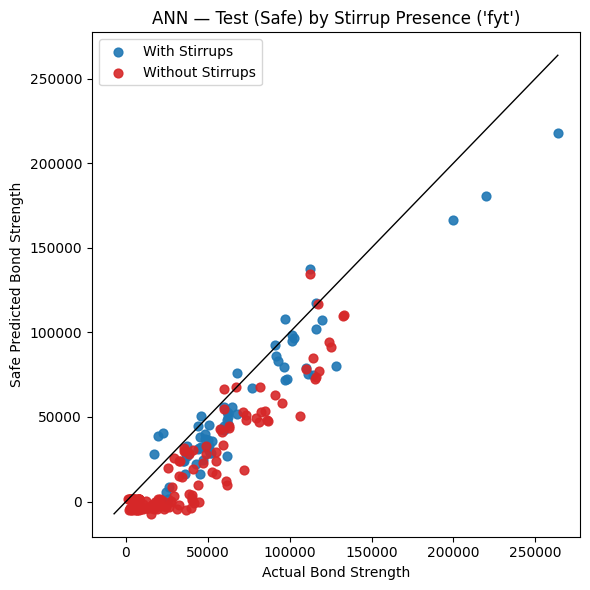

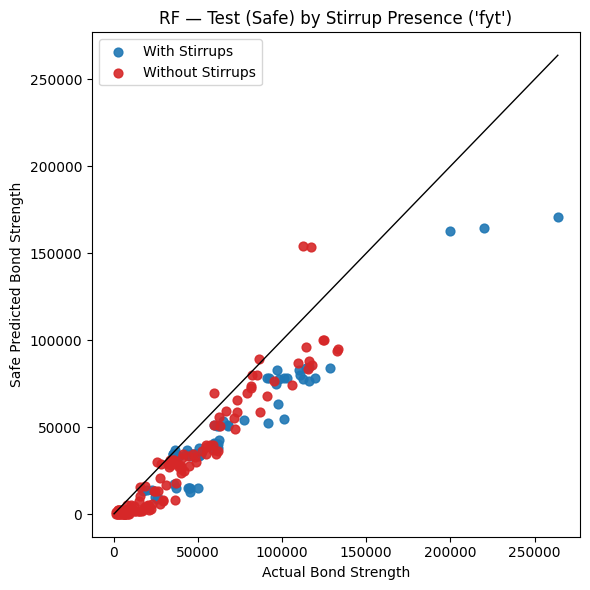

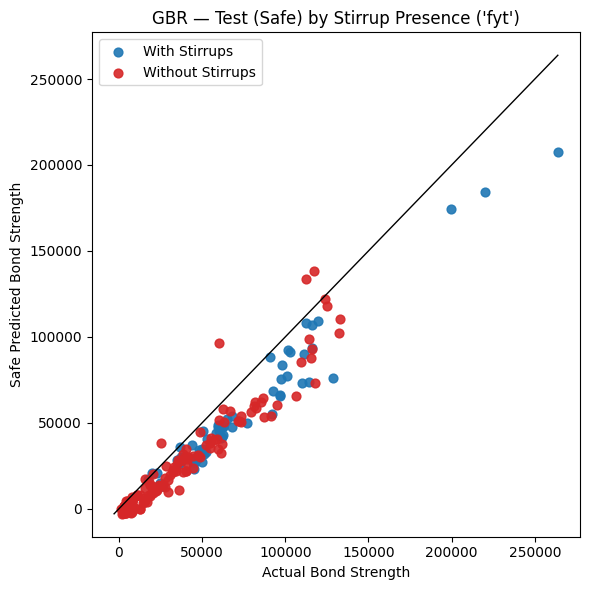

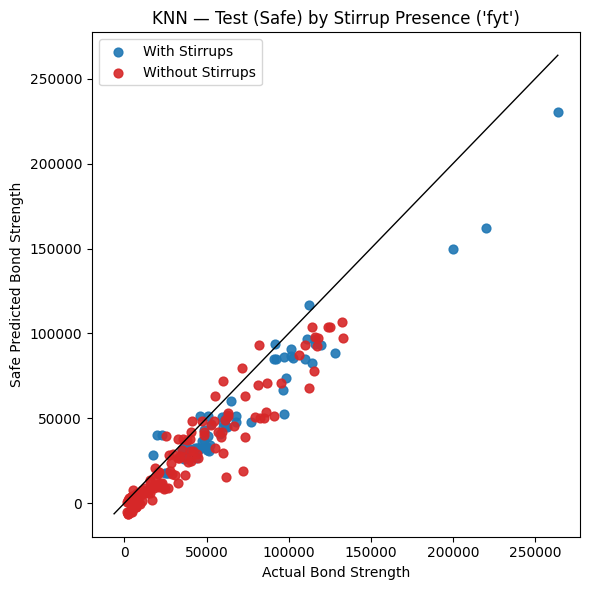

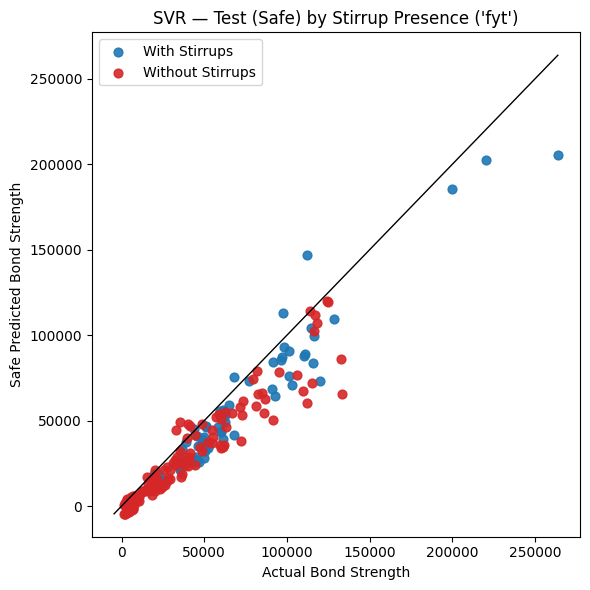

Done — Test (Safe) plots by stirrup presence (fyt).


In [39]:
# === Test (Safe) plots by Stirrup Presence (fyt) for base models ===
# Requirements in Colab workspace:
#  - y_te (test targets)
#  - safe_test_store (dict with keys: "ANN","RF","GBR","KNN","SVR") OR
#    safe_test_predictions_all_models.csv / safe_test_predictions.csv with columns like 'GBR_test_safe'
#  - X_te dataframe with column indicating stirrup presence (try 'fyt' first)

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

base_models = ["ANN","RF","GBR","KNN","SVR"]

# --- Try in-memory safe_test_store first ---
safe_store = globals().get("safe_test_store", None)

# --- Try file fallback ---
def try_load(path):
    if os.path.exists(path):
        try:
            return pd.read_csv(path)
        except Exception:
            try:
                return pd.read_excel(path)
            except Exception:
                return None
    return None

safe_df = None
if safe_store is None:
    safe_df = try_load("safe_test_predictions_all_models.csv") or try_load("safe_test_predictions.csv")

# --- y_test (required) ---
if 'y_te' in globals():
    y_true = np.asarray(y_te).ravel()
else:
    if safe_df is not None and 'y_test' in safe_df.columns:
        y_true = np.asarray(safe_df['y_test']).ravel()
        print("Loaded y_test from safe_test_predictions file.")
    else:
        raise NameError("y_te (test targets) not found. Provide y_te in memory or safe_test_predictions file with 'y_test' column.")

# --- X_te and locate stirrup column (fyt) ---
Xte = globals().get("X_te", None)
possible_cols = ["fyt", "Stirrups", "Transverse", "stirrup", "has_stirrups"]

# If X_te missing, try to extract from safe_df
if Xte is None and safe_df is not None:
    for c in possible_cols:
        if c in safe_df.columns:
            Xte = pd.DataFrame({c: safe_df[c].values})
            print(f"Loaded {c} from safe_test_predictions file into X_te.")
            break

if Xte is None:
    raise NameError("X_te not found in memory and no fallback found. Provide X_te with stirrup column.")

# find column name
st_col = None
for c in possible_cols:
    if c in Xte.columns:
        st_col = c
        break

if st_col is None:
    print("⚠️ No obvious stirrup column found (tried fyt/Stirrups/Transverse...). Defaulting all to fyt=0.")
    Xte = Xte.copy()
    Xte['fyt'] = 0
    st_col = 'fyt'

# ensure numeric 0/1
st_values = np.asarray(Xte[st_col].fillna(0).astype(int).values).ravel()

# color mapping for fyt
color_map = {1: "#1f77b4", 0: "#d62728"}   # 1 -> blue, 0 -> red
label_map = {1: "With Stirrups", 0: "Without Stirrups"}

# --- helper to get safe preds for a model ---
def get_safe_preds(model_name):
    # priority 1: safe_store dict
    if safe_store is not None and isinstance(safe_store, dict) and model_name in safe_store:
        return np.asarray(safe_store[model_name]).ravel()
    # priority 2: safe_df columns patterns
    if safe_df is not None:
        for col in [f"{model_name}_test_safe", f"{model_name}_safe", f"{model_name}_testsafe", f"{model_name}_safe_pred"]:
            if col in safe_df.columns:
                return np.asarray(safe_df[col]).ravel()
    # not found
    return None

# --- Plot per base model: Test (Safe) colored by fyt, using dots ---
for model_name in base_models:
    safe_pred = get_safe_preds(model_name)
    if safe_pred is None:
        print(f"⚠️ Safe predictions for {model_name} not found. Skipping {model_name}.")
        continue
    if len(safe_pred) != len(y_true):
        print(f"⚠️ Length mismatch for {model_name} safe preds ({len(safe_pred)}) vs y_test ({len(y_true)}). Skipping.")
        continue

    plt.figure(figsize=(6,6))
    for val in [1, 0]:
        mask = (st_values == val)
        if mask.sum() == 0:
            continue
        plt.scatter(y_true[mask], safe_pred[mask],
                    s=40, alpha=0.9, marker='o',
                    color=color_map[val], label=label_map[val])

    lims_min = min(y_true.min(), safe_pred.min())
    lims_max = max(y_true.max(), safe_pred.max())
    plt.plot([lims_min, lims_max], [lims_min, lims_max], color='k', linewidth=1)
    plt.title(f"{model_name} — Test (Safe) by Stirrup Presence ('{st_col}')")
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Safe Predicted Bond Strength")
    plt.legend(loc="best", fontsize=10)
    plt.tight_layout()
    plt.show()

print("Done — Test (Safe) plots by stirrup presence (fyt).")


In [76]:
# === Meta-Learner via proper OOF for 5 base models ===
import numpy as np, pandas as pd, os, joblib
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.base import clone
from catboost import CatBoostRegressor, Pool

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# ---- helpers ----
def rmse(y, p): return float(np.sqrt(mean_squared_error(y, p)))
def mae(y, p):  return float(mean_absolute_error(y, p))
def overrate(y, p): return float(np.mean(np.asarray(p).ravel() > np.asarray(y).ravel()))

def build_ann(input_dim):
    m = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.15),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=8e-4), loss="mse")
    return m

# ---- define base models (match earlier intent) ----
# RF (weak)
RF = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=40, max_depth=3, min_samples_leaf=20, max_features=0.5,
        random_state=RANDOM_STATE, n_jobs=-1
    ))
])

# GBR (weak)
GBR = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(
        n_estimators=80, learning_rate=0.05, max_depth=2,
        subsample=0.5, min_samples_leaf=20, max_features=0.5,
        random_state=RANDOM_STATE
    ))
])

# KNN (moderate) with Type scaled
knn_preproc = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), [c for c in X_tr.columns if c != "Type"]),
    ("type", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler())
    ]), ["Type"])
])
KNN = Pipeline([("prep", knn_preproc), ("knn", KNeighborsRegressor(n_neighbors=7))])

# SVR (controlled) with PCA on numerics + scaled Type, and log-target outside during meta OOF (kept raw here)
num_cols = [c for c in X_tr.columns if c != "Type"]
svr_preproc = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.85, svd_solver="full"))
    ]), num_cols),
    ("type", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler())
    ]), ["Type"])
])
SVR_BASE = Pipeline([("prep", svr_preproc), ("svr", SVR(kernel="rbf", C=10, gamma=0.05, epsilon=0.3))])

BASE_NAMES = ["RF","GBR","KNN","SVR","ANN"]
BASE_DICT  = {"RF":RF, "GBR":GBR, "KNN":KNN, "SVR":SVR_BASE, "ANN":"keras"}

# ---- OOF for base models ----
n_train = X_tr.shape[0]
n_test  = X_te.shape[0]
oof_train = np.zeros((n_train, len(BASE_NAMES)), dtype=float)
test_preds_mat = np.zeros((n_test, len(BASE_NAMES)), dtype=float)

kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

for j, name in enumerate(BASE_NAMES):
    print(f"== OOF for {name} ==")
    fold_test_preds = []
    for fold, (tr_idx, va_idx) in enumerate(kf.split(X_tr, y_tr), 1):
        X_tr_f, X_va_f = X_tr.iloc[tr_idx], X_tr.iloc[va_idx]
        y_tr_f, y_va_f = y_tr[tr_idx], y_tr[va_idx]

        if name != "ANN":
            model = clone(BASE_DICT[name])
            model.fit(X_tr_f, y_tr_f)
            oof_train[va_idx, j] = model.predict(X_va_f).ravel()
            fold_test_preds.append(model.predict(X_te).ravel())
        else:
            # ANN per-fold with imputer + scaler fit on fold-train only
            imp = SimpleImputer(strategy="median")
            sc  = StandardScaler()

            Xtr_i = imp.fit_transform(X_tr_f)
            Xva_i = imp.transform(X_va_f)
            Xte_i = imp.transform(X_te)

            Xtr_s = sc.fit_transform(Xtr_i)
            Xva_s = sc.transform(Xva_i)
            Xte_s = sc.transform(Xte_i)

            ann = build_ann(Xtr_s.shape[1])
            es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=0)
            ann.fit(Xtr_s, y_tr_f, epochs=150, batch_size=64, validation_data=(Xva_s, y_va_f),
                    verbose=0, callbacks=[es])

            oof_train[va_idx, j] = ann.predict(Xva_s, verbose=0).ravel()
            fold_test_preds.append(ann.predict(Xte_s, verbose=0).ravel())

        print(f"  fold {fold}/{N_SPLITS} done")

    test_preds_mat[:, j] = np.mean(np.column_stack(fold_test_preds), axis=1)

# Wrap into DataFrames
oof_train_df = pd.DataFrame(oof_train, columns=BASE_NAMES)
test_oof_df  = pd.DataFrame(test_preds_mat, columns=BASE_NAMES)

# ---- Build meta features (optionally add Type/Position) ----
X_meta_tr = oof_train_df.copy()
X_meta_te = test_oof_df.copy()

if "Type" in X_tr.columns:
    X_meta_tr["Type"] = X_tr["Type"].values
    X_meta_te["Type"] = X_te["Type"].values

if "Position" in X_tr.columns:
    X_meta_tr["Position"] = X_tr["Position"].values
    X_meta_te["Position"] = X_te["Position"].values

# Determine categorical indices for CatBoost (object or category dtypes)
cat_cols = [c for c in X_meta_tr.columns if X_meta_tr[c].dtype == "object" or str(X_meta_tr[c].dtype) == "category"]
cat_idx  = [X_meta_tr.columns.get_loc(c) for c in cat_cols]

# ---- Train/valid split for meta early stopping ----
Xtr_m, Xva_m, ytr_m, yva_m = train_test_split(
    X_meta_tr, y_tr, test_size=0.15, random_state=RANDOM_STATE, stratify=None
)

train_pool = Pool(Xtr_m, ytr_m, cat_features=cat_idx)
valid_pool = Pool(Xva_m, yva_m, cat_features=cat_idx)
test_pool  = Pool(X_meta_te,        cat_features=cat_idx)

# ---- CatBoost meta (conservative) ----
meta = CatBoostRegressor(
    loss_function="RMSE",
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=3.0,
    n_estimators=3000,
    subsample=0.7,
    random_seed=RANDOM_STATE,
    verbose=False
)
meta.fit(train_pool, eval_set=valid_pool, use_best_model=True, early_stopping_rounds=100)

# ---- Predictions & metrics ----
y_tr_meta = meta.predict(X_meta_tr)
y_te_meta = meta.predict(test_pool)

print("\n==== Meta-Learner (CatBoost) Metrics ====")
print(f"Train | R2={r2_score(y_tr, y_tr_meta):.4f} | RMSE={rmse(y_tr, y_tr_meta):,.2f} | MAE={mae(y_tr, y_tr_meta):,.2f} | Over={overrate(y_tr, y_tr_meta):.3f}")
print(f"Test  | R2={r2_score(y_te, y_te_meta):.4f} | RMSE={rmse(y_te, y_te_meta):,.2f} | MAE={mae(y_te, y_te_meta):,.2f} | Over={overrate(y_te, y_te_meta):.3f}")

if "Type" in X_te.columns:
    for typ, lbl in [(1,"Steel"), (2,"GFRP")]:
        m = (X_te["Type"].values == typ)
        if m.any():
            print(f"  -> {lbl:5s} | R2={r2_score(y_te[m], y_te_meta[m]):.4f} | RMSE={rmse(y_te[m], y_te_meta[m]):,.2f} | MAE={mae(y_te[m], y_te_meta[m]):,.2f} | Over={overrate(y_te[m], y_te_meta[m]):.3f}")

# ---- Save artifacts ----
os.makedirs("meta_artifacts", exist_ok=True)
meta.save_model("meta_artifacts/catboost_meta.cbm")
joblib.dump({"features": X_meta_tr.columns.tolist(), "cat_idx": cat_idx}, "meta_artifacts/meta_info.pkl")
pd.DataFrame({"y_train": y_tr, "y_train_meta": y_tr_meta}).to_csv("meta_artifacts/meta_train_preds.csv", index=False)
pd.DataFrame({"y_test": y_te, "y_test_meta": y_te_meta}).to_csv("meta_artifacts/meta_test_preds.csv", index=False)

print("\nSaved: meta_artifacts/catboost_meta.cbm, meta_artifacts/meta_info.pkl, meta_train_preds.csv, meta_test_preds.csv")


== OOF for RF ==
  fold 1/5 done
  fold 2/5 done
  fold 3/5 done
  fold 4/5 done
  fold 5/5 done
== OOF for GBR ==
  fold 1/5 done
  fold 2/5 done
  fold 3/5 done
  fold 4/5 done
  fold 5/5 done
== OOF for KNN ==
  fold 1/5 done
  fold 2/5 done
  fold 3/5 done
  fold 4/5 done
  fold 5/5 done
== OOF for SVR ==
  fold 1/5 done
  fold 2/5 done
  fold 3/5 done
  fold 4/5 done
  fold 5/5 done
== OOF for ANN ==
  fold 1/5 done
  fold 2/5 done
  fold 3/5 done
  fold 4/5 done
  fold 5/5 done

==== Meta-Learner (CatBoost) Metrics ====
Train | R2=0.9745 | RMSE=7,467.70 | MAE=5,070.81 | Over=0.510
Test  | R2=0.9706 | RMSE=7,122.29 | MAE=5,096.12 | Over=0.541
  -> Steel | R2=0.9660 | RMSE=7,554.52 | MAE=5,603.65 | Over=0.519
  -> GFRP  | R2=0.5525 | RMSE=1,351.62 | MAE=1,183.89 | Over=0.708

Saved: meta_artifacts/catboost_meta.cbm, meta_artifacts/meta_info.pkl, meta_train_preds.csv, meta_test_preds.csv


In [78]:
# === Apply SAFE MODE to Meta-Learner predictions (per-Type calibrators) ===
import numpy as np, pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ---------------- Config (tune here) ----------------
# --- Tuned dials (minimal changes) ---
ALPHA_BY_TYPE = {1: 0.035, 2: 0.07}   # stricter for Steel (1), keep GFRP as-is (2)
SHRINK_GAMMA  = 0.7                  # blend more toward global quantile
MARGIN_BY_TYPE= {1: 0.03, 2: 0.00}   # tiny extra cushion for Steel only
N_BINS, MIN_BIN, CAP_P = 4, 30, 0.97 # unchanged

def rmse(y,p): return float(np.sqrt(mean_squared_error(y,p)))
def mae(y,p):  return float(mean_absolute_error(y,p))
def overrate(y,p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    return float(np.mean(p > y))

# ------------- Physics-aware scale (fallback to y_pred) -------------
def get_scale(Xframe, y_pred):
    if all(c in Xframe.columns for c in ["ls","fc"]):
        fc = np.asarray(Xframe["fc"].values, dtype=float)
        ls = np.asarray(Xframe["ls"].values, dtype=float)
        return np.sqrt(np.clip(fc, 1e-9, None)) * np.pi * ls
    return np.asarray(y_pred, dtype=float)

def finite_sample_q(residuals, alpha):
    r = np.asarray(residuals).ravel()
    m = len(r)
    if m == 0: return 0.0
    rank = int(np.ceil((m+1)*(1.0-alpha)))
    rank = min(max(rank,1), m)
    return float(np.sort(r)[rank-1])

def fit_safety_calibrator(y_true, y_pred, scale, alpha):
    residuals = np.asarray(y_pred).ravel() - np.asarray(y_true).ravel()
    s = np.asarray(scale).ravel()
    q_global = finite_sample_q(residuals, alpha)
    pos = residuals[residuals > 0]
    cap_val = np.quantile(pos, CAP_P) if pos.size else q_global

    # Bin edges; guard duplicates with tiny jitter
    edges = np.quantile(s, np.linspace(0, 1, N_BINS+1))
    if np.unique(edges).size < edges.size:
        s = s + np.random.default_rng(42).normal(0, 1e-9, size=s.shape)
        edges = np.quantile(s, np.linspace(0, 1, N_BINS+1))

    qs = []
    for i in range(N_BINS):
        left, right = edges[i], edges[i+1]
        mask = (s >= left) if i == 0 else (s > left)
        mask &= (s <= right)
        r_bin = residuals[mask]
        if r_bin.size < MIN_BIN:
            q_bin = q_global
        else:
            q_bin = finite_sample_q(r_bin, alpha)
            q_bin = min(q_bin, cap_val)
            q_bin = (1.0 - SHRINK_GAMMA)*q_bin + SHRINK_GAMMA*q_global
        qs.append(q_bin * (1 + MARGIN))
    return {"edges": edges, "qs": np.array(qs), "q_global": q_global*(1+MARGIN)}

def apply_safety(y_pred, scale, cal):
    s = np.asarray(scale).ravel()
    idx = np.minimum(np.searchsorted(cal["edges"][1:], s, side="right"), len(cal["qs"])-1)
    return np.asarray(y_pred).ravel() - cal["qs"][idx]

def build_type_calibrators(y_true, y_pred, types, Xframe, alphas):
    cals = {}
    t = np.asarray(types).ravel()
    scale = get_scale(Xframe, y_pred)
    for typ in [1,2]:
        m = (t == typ)
        if m.any():
            cals[typ] = fit_safety_calibrator(y_true[m], y_pred[m], scale[m], alphas.get(typ, 0.07))
    return cals

def apply_type_safety(y_pred, types, Xframe, calibrators):
    y_pred = np.asarray(y_pred).ravel()
    t = np.asarray(types).ravel()
    out = np.zeros_like(y_pred, dtype=float)
    for typ, cal in calibrators.items():
        m = (t == typ)
        if m.any():
            out[m] = apply_safety(y_pred[m], get_scale(Xframe.iloc[m.nonzero()[0]], y_pred[m]), cal)
    # if a type missing, pass-through
    mask_any = np.zeros_like(y_pred, dtype=bool)
    for typ in calibrators.keys(): mask_any |= (t == typ)
    out[~mask_any] = y_pred[~mask_any]
    return out

# ----------------- Calibrate on TRAIN, apply to TEST -----------------
types_tr = X_tr["Type"].astype(int).values
types_te = X_te["Type"].astype(int).values

calibrators = build_type_calibrators(y_tr, y_tr_meta, types_tr, X_tr, ALPHA_BY_TYPE)
y_te_meta_safe = apply_type_safety(y_te_meta, types_te, X_te, calibrators)

# ----------------- Metrics -----------------
rows = []
rows.append(["Meta", "Test", "RAW",
             r2_score(y_te, y_te_meta), rmse(y_te, y_te_meta), mae(y_te, y_te_meta), overrate(y_te, y_te_meta)])
rows.append(["Meta", "Test", "SAFE",
             r2_score(y_te, y_te_meta_safe), rmse(y_te, y_te_meta_safe), mae(y_te, y_te_meta_safe), overrate(y_te, y_te_meta_safe)])

# Per-Type
for typ, lbl in [(1,"Steel"), (2,"GFRP")]:
    m = (types_te == typ)
    if m.any():
        rows.append([f"Meta-{lbl}", "Test", "RAW",
                     r2_score(y_te[m], y_te_meta[m]), rmse(y_te[m], y_te_meta[m]),
                     mae(y_te[m], y_te_meta[m]), overrate(y_te[m], y_te_meta[m])])
        rows.append([f"Meta-{lbl}", "Test", "SAFE",
                     r2_score(y_te[m], y_te_meta_safe[m]), rmse(y_te[m], y_te_meta_safe[m]),
                     mae(y_te[m], y_te_meta_safe[m]), overrate(y_te[m], y_te_meta_safe[m])])

res = pd.DataFrame(rows, columns=["Model","Split","Kind","R2","RMSE","MAE","Overrate"])
display(res.round({"R2":4,"RMSE":0,"MAE":0,"Overrate":3}))

# Target check
print("\nTarget overrate ≤ per-type α:", ALPHA_BY_TYPE)
for typ, lbl in [(1,"Steel"), (2,"GFRP")]:
    m = (types_te == typ)
    if m.any():
        ov_safe = overrate(y_te[m], y_te_meta_safe[m])
        goal = ALPHA_BY_TYPE[typ]
        print(("✅" if ov_safe <= goal+1e-9 else "⚠️"), f"{lbl}: Overrate_safe={ov_safe:.3f} (goal ≤ {goal:.3f})")

# Save
out_meta = pd.DataFrame({
    "y_test": y_te,
    "meta_raw": y_te_meta,
    "meta_safe": y_te_meta_safe,
    "Type": types_te
})
out_meta.to_csv("meta_safe_predictions.csv", index=False)
print("\nSaved: meta_safe_predictions.csv")



Model Split  Kind      R2     RMSE      MAE  Overrate
0        Meta  Test   RAW  0.9706   7122.0   5096.0     0.541
1        Meta  Test  SAFE  0.8582  15646.0  13607.0     0.057
2  Meta-Steel  Test   RAW  0.9660   7555.0   5604.0     0.519
3  Meta-Steel  Test  SAFE  0.8354  16616.0  15176.0     0.038
4   Meta-GFRP  Test   RAW  0.5525   1352.0   1184.0     0.708
5   Meta-GFRP  Test  SAFE  0.0967   1920.0   1513.0     0.208


Target overrate ≤ per-type α: {1: 0.035, 2: 0.07}
⚠️ Steel: Overrate_safe=0.038 (goal ≤ 0.035)
⚠️ GFRP: Overrate_safe=0.208 (goal ≤ 0.070)

Saved: meta_safe_predictions.csv


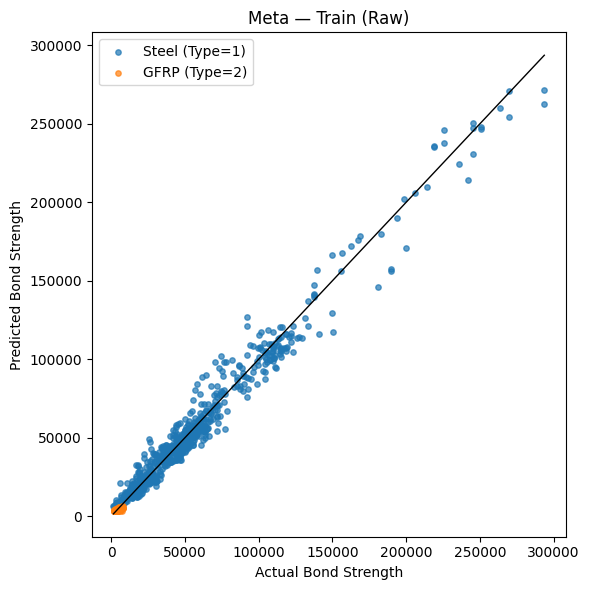

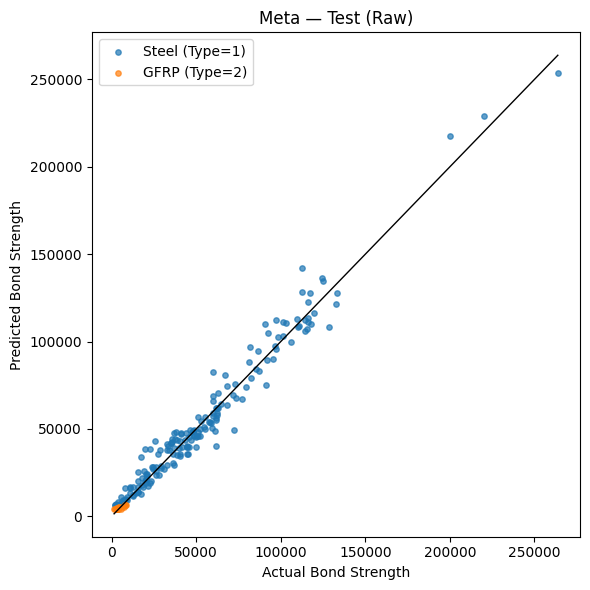

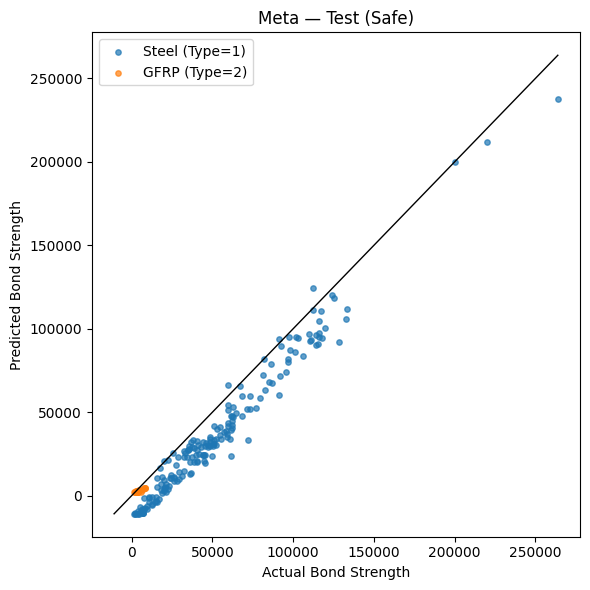

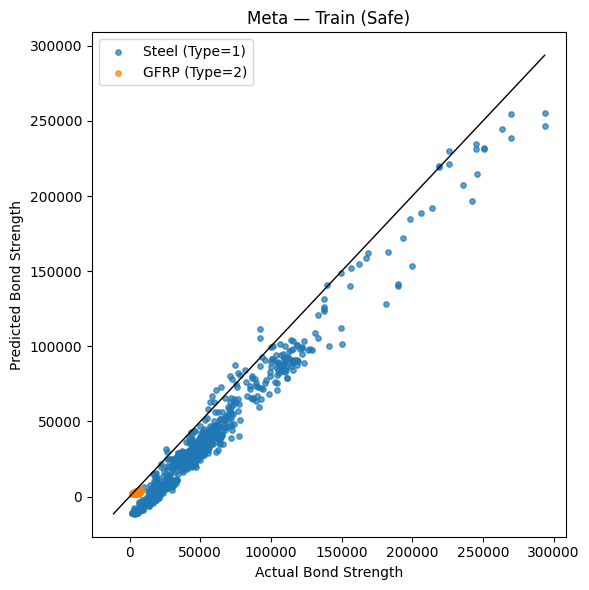

In [79]:
# === Meta learner RAW vs SAFE (Train/Test) plots ===
# Requires: y_tr, y_te, y_tr_meta, y_te_meta, X_tr, X_te
# For SAFE:  y_te_meta_safe_tuned or y_te_meta_safe (from safety cell)

import numpy as np
import matplotlib.pyplot as plt

# Pick whichever safe variable exists
if 'y_te_meta_safe_tuned' in globals():
    y_te_meta_safe_var = y_te_meta_safe_tuned
elif 'y_te_meta_safe' in globals():
    y_te_meta_safe_var = y_te_meta_safe
else:
    y_te_meta_safe_var = None
    print("⚠️ Safe meta predictions not found. Run your safety cell first.")

def plot_actual_vs_pred(y_true, y_pred, types, title):
    y_true, y_pred, types = map(np.ravel, (y_true, y_pred, types))
    plt.figure(figsize=(6,6))
    m1 = (types == 1)
    plt.scatter(y_true[m1], y_pred[m1], s=15, alpha=0.7, label="Steel (Type=1)")
    m2 = (types == 2)
    if np.any(m2):
        plt.scatter(y_true[m2], y_pred[m2], s=15, alpha=0.7, label="GFRP (Type=2)")
    lims_min, lims_max = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([lims_min, lims_max], [lims_min, lims_max], 'k-', lw=1)
    plt.title(title)
    plt.xlabel("Actual Bond Strength")
    plt.ylabel("Predicted Bond Strength")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Meta — Train (Raw)
plot_actual_vs_pred(y_tr, y_tr_meta, X_tr["Type"].values, "Meta — Train (Raw)")

# 2) Meta — Test (Raw)
plot_actual_vs_pred(y_te, y_te_meta, X_te["Type"].values, "Meta — Test (Raw)")

# 3) Meta — Test (Safe)
if y_te_meta_safe_var is not None:
    plot_actual_vs_pred(y_te, y_te_meta_safe_var, X_te["Type"].values, "Meta — Test (Safe)")

# 4) Optional: visualize Train (Safe)
if 'calibrators' in globals() and 'apply_type_safety' in globals() and 'get_scale' in globals():
    try:
        # Corrected indexing: apply boolean mask directly to X_tr
        y_tr_meta_safe_vis = apply_type_safety(y_tr_meta, X_tr["Type"].values, X_tr, calibrators)
        plot_actual_vs_pred(y_tr, y_tr_meta_safe_vis, X_tr["Type"].values, "Meta — Train (Safe)")
    except Exception as e:
        print("Skipping Train (Safe) visualization due to:", repr(e))

In [80]:
# === Produce Meta TRAIN "SAFE" predictions, evaluate & save ===
import os, numpy as np, pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import Pool

def rmse(y,p): return float(np.sqrt(mean_squared_error(y,p)))
def mae(y,p):  return float(mean_absolute_error(y,p))
def overrate(y,p):
    y = np.asarray(y).ravel(); p = np.asarray(p).ravel()
    return float(np.mean(p > y))

# ---- sanity checks and fallbacks ----
assert 'X_tr' in globals() and 'X_meta_tr' in globals(), "X_tr and X_meta_tr must exist"
assert 'y_tr' in globals(), "y_tr must exist"

# If y_tr_meta (train predictions) missing, try to compute from trained meta model
if 'y_tr_meta' not in globals():
    if 'meta' in globals():
        print("y_tr_meta not found — computing using existing 'meta' model on X_meta_tr ...")
        # ensure cat features if necessary
        try:
            y_tr_meta = meta.predict(Pool(X_meta_tr, cat_features=cat_idx if ('cat_idx' in globals() and len(cat_idx)) else None))
        except Exception:
            y_tr_meta = meta.predict(Pool(X_meta_tr))
    else:
        raise AssertionError("No 'y_tr_meta' and no trained 'meta' model available to produce it.")

# If calibrators missing, build them on TRAIN (this matches the workflow you used earlier)
if 'calibrators' not in globals():
    print("Calibrators not found — building calibrators on TRAIN using existing function 'build_type_calibrators' ...")
    assert 'build_type_calibrators' in globals(), "Missing build_type_calibrators function; cannot construct calibrators"
    # types and X_tr must exist
    types_tr = np.asarray(X_tr["Type"].astype(int).values) if ("Type" in X_tr.columns) else np.ones(len(X_tr), dtype=int)
    calibrators = build_type_calibrators(np.asarray(y_tr).ravel(), np.asarray(y_tr_meta).ravel(), types_tr, X_tr)

# Now apply calibrators to TRAIN predictions
types_tr = np.asarray(X_tr["Type"].astype(int).values) if ("Type" in X_tr.columns) else np.ones(len(X_tr), dtype=int)

# Use apply_type_safety if present, else fall back to local implementation
if 'apply_type_safety' in globals():
    y_tr_meta_safe = apply_type_safety(y_tr_meta, types_tr, X_tr, calibrators)
else:
    # Local fallback (same logic as your apply_type_safety)
    def get_scale(Xframe, y_pred):
        if all(c in Xframe.columns for c in ["ls","fc"]):
            fc = np.asarray(Xframe["fc"].values, dtype=float)
            ls = np.asarray(Xframe["ls"].values, dtype=float)
            return np.sqrt(np.clip(fc, 1e-9, None)) * np.pi * ls
        return np.asarray(y_pred, dtype=float)
    def apply_safety_local(y_pred, scale, cal):
        s = np.asarray(scale).ravel()
        idx = np.minimum(np.searchsorted(cal["edges"][1:], s, side="right"), len(cal["qs"])-1)
        return np.asarray(y_pred).ravel() - cal["qs"][idx]
    y_tr_meta_safe = np.zeros_like(np.asarray(y_tr_meta).ravel(), dtype=float)
    t = types_tr
    for typ, cal in calibrators.items():
        m = (t == typ)
        if np.any(m):
            scale_sub = get_scale(X_tr.iloc[m.nonzero()[0]], np.asarray(y_tr_meta).ravel()[m])
            y_tr_meta_safe[m] = apply_safety_local(np.asarray(y_tr_meta).ravel()[m], scale_sub, cal)
    # pass-through for any missing types
    mask_any = np.zeros_like(y_tr_meta_safe, dtype=bool)
    for typ in calibrators.keys():
        mask_any |= (t == typ)
    y_tr_meta_safe[~mask_any] = np.asarray(y_tr_meta).ravel()[~mask_any]

# ---- Evaluate TRAIN before/after ----
y_tr_true = np.asarray(y_tr).ravel()
print("\n==== Meta (Train) — RAW vs SAFE ====")
print(f"RAW  | R2={r2_score(y_tr_true, y_tr_meta):.4f} | RMSE={rmse(y_tr_true, y_tr_meta):,.2f} | MAE={mae(y_tr_true, y_tr_meta):,.2f} | Over={overrate(y_tr_true, y_tr_meta):.3f}")
print(f"SAFE | R2={r2_score(y_tr_true, y_tr_meta_safe):.4f} | RMSE={rmse(y_tr_true, y_tr_meta_safe):,.2f} | MAE={mae(y_tr_true, y_tr_meta_safe):,.2f} | Over={overrate(y_tr_true, y_tr_meta_safe):.3f}")

# Per-Type TRAIN breakdown (if Type exists)
if "Type" in X_tr.columns:
    tvals_tr = np.asarray(X_tr["Type"].astype(int).values)
    for typ, lbl in [(1,"Steel"), (2,"GFRP")]:
        m = (tvals_tr == typ)
        if m.any():
            print(f"  -> {lbl:5s} RAW  | R2={r2_score(y_tr_true[m], np.asarray(y_tr_meta)[m]):.4f} | RMSE={rmse(y_tr_true[m], np.asarray(y_tr_meta)[m]):,.2f} | MAE={mae(y_tr_true[m], np.asarray(y_tr_meta)[m]):,.2f} | Over={overrate(y_tr_true[m], np.asarray(y_tr_meta)[m]):.3f}")
            print(f"  -> {lbl:5s} SAFE | R2={r2_score(y_tr_true[m], y_tr_meta_safe[m]):.4f} | RMSE={rmse(y_tr_true[m], y_tr_meta_safe[m]):,.2f} | MAE={mae(y_tr_true[m], y_tr_meta_safe[m]):,.2f} | Over={overrate(y_tr_true[m], y_tr_meta_safe[m]):.3f}")

# ---- Save TRAIN safe predictions ----
outdir = "meta_artifacts_best"
os.makedirs(outdir, exist_ok=True)
df_out = pd.DataFrame({
    "y_train": y_tr_true,
    "meta_raw": np.asarray(y_tr_meta).ravel(),
    "meta_safe": np.asarray(y_tr_meta_safe).ravel(),
    "Type": types_tr
})
df_out.to_csv(os.path.join(outdir, "meta_train_preds_safe.csv"), index=False)
print(f"\nSaved: {os.path.join(outdir, 'meta_train_preds_safe.csv')}")



==== Meta (Train) — RAW vs SAFE ====
RAW  | R2=0.9745 | RMSE=7,467.70 | MAE=5,070.81 | Over=0.510
SAFE | R2=0.8720 | RMSE=16,737.84 | MAE=14,614.30 | Over=0.030
  -> Steel RAW  | R2=0.9710 | RMSE=7,925.96 | MAE=5,605.07 | Over=0.501
  -> Steel SAFE | R2=0.8540 | RMSE=17,776.83 | MAE=16,287.70 | Over=0.027
  -> GFRP  RAW  | R2=0.4354 | RMSE=1,239.47 | MAE=963.63 | Over=0.573
  -> GFRP  SAFE | R2=-0.6464 | RMSE=2,116.63 | MAE=1,749.98 | Over=0.052

Saved: meta_artifacts_best/meta_train_preds_safe.csv


Test length = 209
Saved: meta_test_raw_vs_safe_byPosition_fixed.png


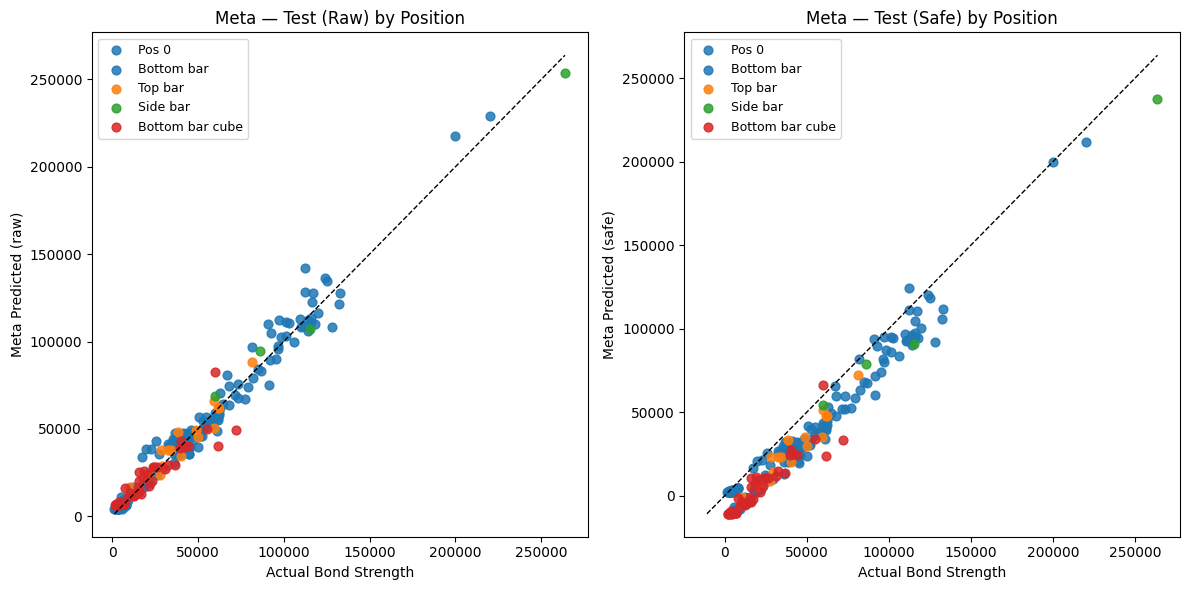

In [81]:
# Robust: Meta Test Raw vs Safe by Position (fixed handling for shape mismatches)
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from catboost import Pool

out_path = "meta_test_raw_vs_safe_byPosition_fixed.png"

def try_load(path):
    if os.path.exists(path):
        try: return pd.read_csv(path)
        except Exception:
            try: return pd.read_excel(path)
            except Exception: return None
    return None

# --- Ensure y_te exists ---
if 'y_te' not in globals():
    df = try_load("meta_safe_predictions.csv") or try_load("meta_test_preds.csv") or try_load("meta_artifacts/meta_test_preds.csv")
    if df is not None and 'y_test' in df.columns:
        y_te = df['y_test'].values
        print("Loaded y_te from fallback file.")
    else:
        raise NameError("y_te not found in memory or fallback files.")
y_te = np.asarray(y_te).ravel()
n_te = len(y_te)
print(f"Test length = {n_te}")

# --- Obtain / fix y_te_meta (raw meta preds) ---
y_te_meta = globals().get('y_te_meta', None)
if y_te_meta is None or np.asarray(y_te_meta).ravel().size != n_te:
    # try to compute from meta model if available and X_meta_te exists
    print("y_te_meta missing or mismatched length -> attempting to compute/pull correct preds...")
    # try predict using meta model + X_meta_te
    if 'meta' in globals() and 'X_meta_te' in globals():
        try:
            # prefer Pool if cat_idx present
            if 'cat_idx' in globals() and isinstance(cat_idx, (list,tuple)):
                y_te_meta = meta.predict(Pool(X_meta_te, cat_features=cat_idx))
            else:
                y_te_meta = meta.predict(Pool(X_meta_te))
            y_te_meta = np.asarray(y_te_meta).ravel()
            print(f"Computed y_te_meta from 'meta' model on X_meta_te (len={len(y_te_meta)})")
        except Exception as e:
            print("Failed to predict with meta model:", e)
            y_te_meta = None
    # try loading file fallbacks
    if (y_te_meta is None) or (np.asarray(y_te_meta).ravel().size != n_te):
        df = try_load("meta_artifacts/meta_test_preds.csv") or try_load("meta_test_preds.csv")
        if df is not None and 'y_test_meta' in df.columns and len(df['y_test_meta']) == n_te:
            y_te_meta = np.asarray(df['y_test_meta']).ravel()
            print("Loaded y_te_meta from meta_test_preds.csv")
    # final fallback: if y_te_meta is scalar or wrong shape, raise helpful error
    if y_te_meta is None or np.asarray(y_te_meta).ravel().size != n_te:
        raise ValueError(f"Unable to obtain y_te_meta of length {n_te}. Current y_te_meta length: {(np.asarray(y_te_meta).ravel().size if y_te_meta is not None else 'None')}")

y_te_meta = np.asarray(y_te_meta).ravel()

# --- Obtain / fix y_te_meta_safe (safe preds) ---
y_te_meta_safe = globals().get('y_te_meta_safe', None)
if y_te_meta_safe is None or np.asarray(y_te_meta_safe).ravel().size != n_te:
    df_safe = try_load("meta_safe_predictions.csv") or try_load("meta_safe_predictions_all.csv")
    if df_safe is not None and 'meta_safe' in df_safe.columns and len(df_safe['meta_safe']) == n_te:
        y_te_meta_safe = np.asarray(df_safe['meta_safe']).ravel()
        print("Loaded y_te_meta_safe from meta_safe_predictions.csv")
    else:
        # try to apply calibrators if available
        if 'calibrators' in globals() and 'apply_type_safety' in globals() and 'X_te' in globals():
            try:
                types_te = X_te["Type"].astype(int).values if "Type" in X_te.columns else np.ones(n_te, dtype=int)
                y_te_meta_safe = apply_type_safety(y_te_meta, types_te, X_te, calibrators)
                y_te_meta_safe = np.asarray(y_te_meta_safe).ravel()
                print("Computed y_te_meta_safe by apply_type_safety(...) on y_te_meta")
            except Exception as e:
                print("apply_type_safety failed:", e)
                y_te_meta_safe = None
        # last resort: conservative elementwise min (visual only)
        if y_te_meta_safe is None or np.asarray(y_te_meta_safe).ravel().size != n_te:
            print("Falling back to conservative visualization y_te_meta_safe = np.minimum(y_te_meta, y_te).")
            y_te_meta_safe = np.minimum(y_te_meta, y_te)

y_te_meta_safe = np.asarray(y_te_meta_safe).ravel()

# --- Position column (X_te["Position"]) ---
pos = None
if 'X_te' in globals() and "Position" in X_te.columns:
    pos = np.asarray(X_te["Position"].fillna(0).astype(int)).ravel()
    if len(pos) != n_te:
        print(f"Warning: X_te.Position length {len(pos)} != {n_te} ; will attempt fallback.")
        pos = None

if pos is None:
    # try loading from meta_safe_predictions.csv or meta_test_preds.csv
    for f in ["meta_safe_predictions.csv","meta_test_preds.csv","meta_artifacts/meta_test_preds.csv"]:
        df = try_load(f)
        if df is None: continue
        for cand in ["Position","position","pos"]:
            if cand in df.columns and len(df[cand]) == n_te:
                pos = np.asarray(df[cand].fillna(0).astype(int)).ravel()
                print(f"Loaded Position from {f}.{cand}")
                break
        if pos is not None: break

if pos is None:
    print("Position not found or mismatched -- defaulting to Position=0 (single group).")
    pos = np.zeros(n_te, dtype=int)

# --- final sanity checks lengths ---
assert len(y_te_meta) == n_te and len(y_te_meta_safe) == n_te and len(pos) == n_te

# --- Build color/label maps for positions encountered ---
unique_pos = np.unique(pos)
default_map = {1: "#1f77b4", 2: "#ff7f0e", 3: "#2ca02c", 4: "#d62728"}
cmap = plt.get_cmap("tab10")
color_map = {int(p): default_map.get(int(p), cmap(i % 10)) for i,p in enumerate(sorted(unique_pos))}
label_map = {1: "Bottom bar", 2: "Top bar", 3: "Side bar", 4: "Bottom bar cube"}
label_map = {p: label_map.get(int(p), f"Pos {p}") for p in unique_pos}

# --- Plot side-by-side: Raw (left) vs Safe (right) ---
plt.figure(figsize=(12,6))

# Left: Raw
ax1 = plt.subplot(1,2,1)
for p in sorted(unique_pos):
    mask = (pos == p)
    if mask.sum() == 0: continue
    ax1.scatter(y_te[mask], y_te_meta[mask], s=40, alpha=0.85, marker='o', color=color_map[p], label=label_map[p])
mn = min(np.nanmin(y_te), np.nanmin(y_te_meta))
mx = max(np.nanmax(y_te), np.nanmax(y_te_meta))
ax1.plot([mn,mx], [mn,mx], linestyle="--", color="k", linewidth=1)
ax1.set_title("Meta — Test (Raw) by Position")
ax1.set_xlabel("Actual Bond Strength")
ax1.set_ylabel("Meta Predicted (raw)")
if len(unique_pos) > 1: ax1.legend(loc="best", fontsize=9)

# Right: Safe
ax2 = plt.subplot(1,2,2)
for p in sorted(unique_pos):
    mask = (pos == p)
    if mask.sum() == 0: continue
    ax2.scatter(y_te[mask], y_te_meta_safe[mask], s=40, alpha=0.85, marker='o', color=color_map[p], label=label_map[p])
mn2 = min(np.nanmin(y_te), np.nanmin(y_te_meta_safe))
mx2 = max(np.nanmax(y_te), np.nanmax(y_te_meta_safe))
ax2.plot([mn2,mx2], [mn2,mx2], linestyle="--", color="k", linewidth=1)
ax2.set_title("Meta — Test (Safe) by Position")
ax2.set_xlabel("Actual Bond Strength")
ax2.set_ylabel("Meta Predicted (safe)")
if len(unique_pos) > 1: ax2.legend(loc="best", fontsize=9)

plt.tight_layout()
plt.savefig(out_path, dpi=200)
print("Saved:", out_path)
plt.show()


Saved: plots_meta_full_by_group/meta_train_raw_byPosition.png


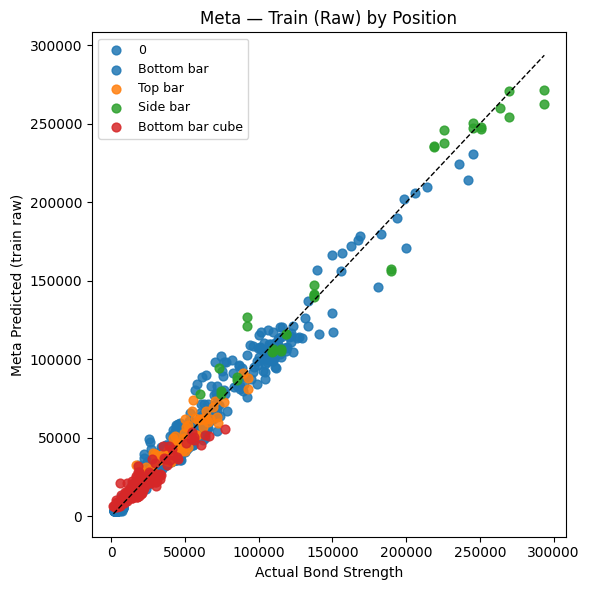

Saved: plots_meta_full_by_group/meta_train_safe_byPosition.png


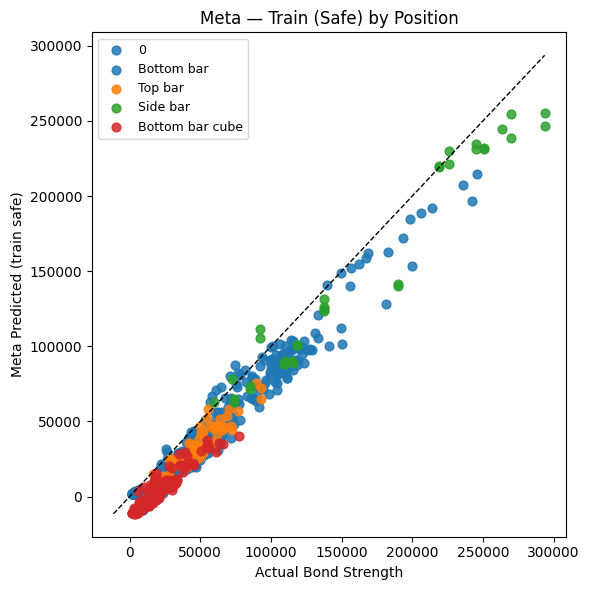

Saved: plots_meta_full_by_group/meta_test_raw_byPosition.png


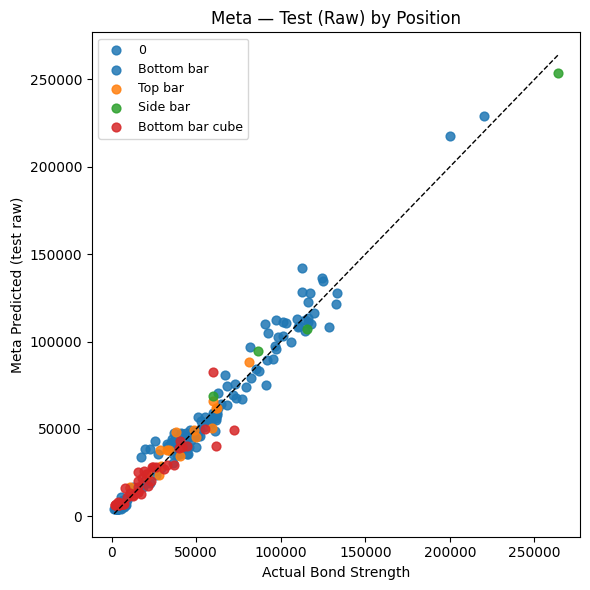

Saved: plots_meta_full_by_group/meta_test_safe_byPosition.png


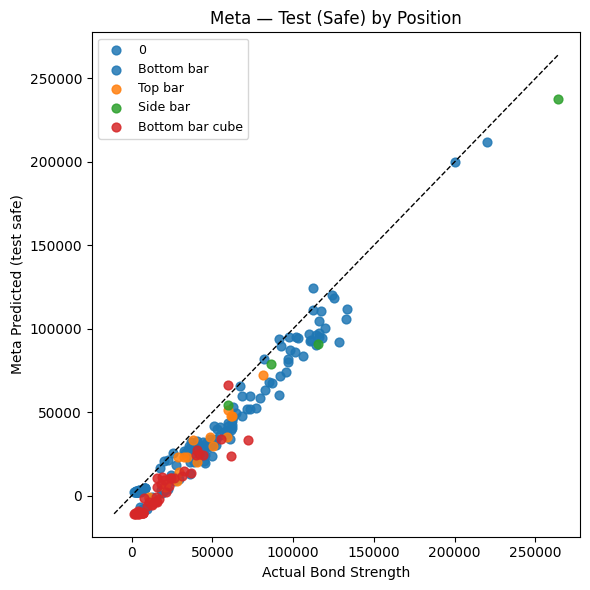

Saved: plots_meta_full_by_group/meta_train_raw_byFYT.png


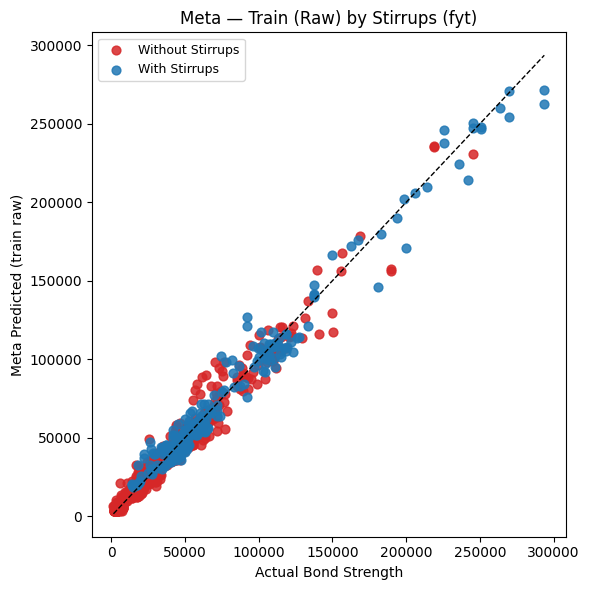

Saved: plots_meta_full_by_group/meta_train_safe_byFYT.png


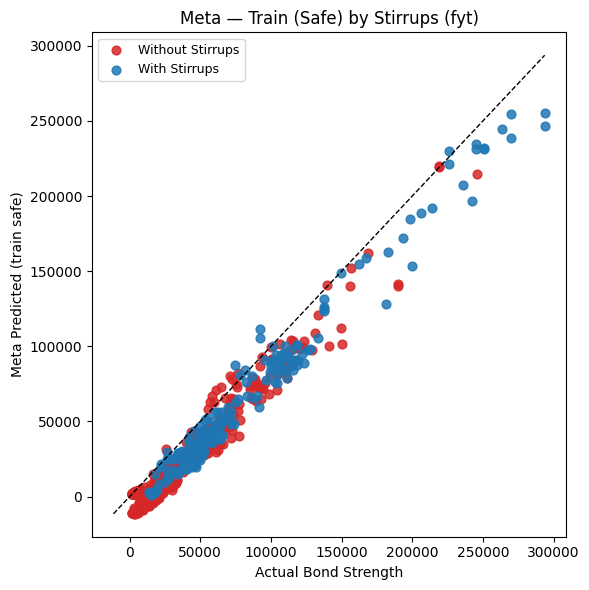

Saved: plots_meta_full_by_group/meta_test_raw_byFYT.png


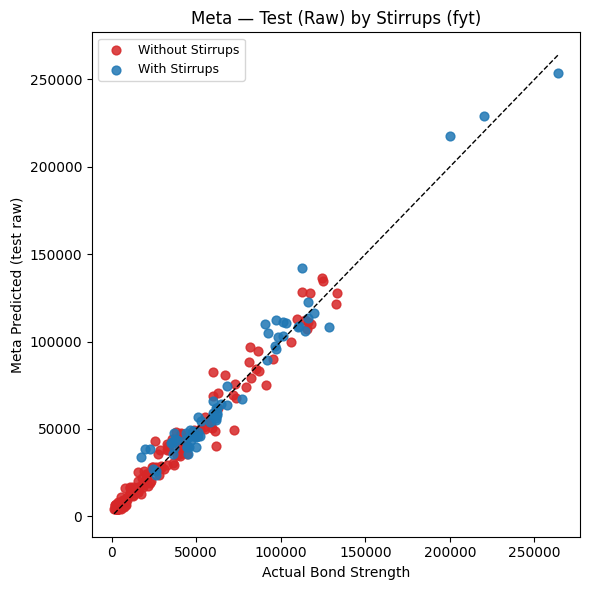

Saved: plots_meta_full_by_group/meta_test_safe_byFYT.png


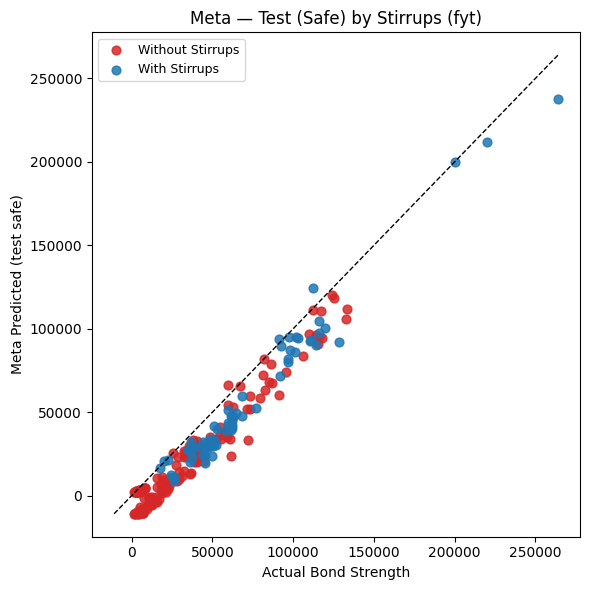

Done — meta plots saved and displayed in plots_meta_full_by_group


In [82]:
# === Meta: Train/Test (Raw + Safe) plots by Position and by Stirrups (fyt) ===
# Paste & run in the same notebook where you've just run your meta cells.
# Expects these variables (will try sensible fallbacks if some are missing):
#   Required: y_tr, y_te
#   Meta preds (raw): y_tr_meta, y_te_meta  (or files meta_artifacts/meta_train_preds.csv, meta_test_preds.csv)
#   Meta preds (safe): y_tr_meta_safe, y_te_meta_safe (or meta_safe_predictions.csv)
#   X_tr, X_te with Position and/or fyt (will fallback to files if needed)
#
# Produces and saves PNGs into out_dir_meta and shows plots inline:
#   - meta_train_raw_byPosition.png
#   - meta_train_safe_byPosition.png
#   - meta_test_raw_byPosition.png
#   - meta_test_safe_byPosition.png
#   - meta_train_raw_byFYT.png
#   - meta_train_safe_byFYT.png
#   - meta_test_raw_byFYT.png
#   - meta_test_safe_byFYT.png

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

out_dir_meta = "plots_meta_full_by_group"
os.makedirs(out_dir_meta, exist_ok=True)

# --- helper to load csv/xlsx safely ---
def try_load(path):
    if os.path.exists(path):
        try: return pd.read_csv(path)
        except Exception:
            try: return pd.read_excel(path)
            except Exception: return None
    return None

# --- required arrays y_tr / y_te ---
if 'y_tr' not in globals() or 'y_te' not in globals():
    raise NameError("y_tr and y_te must be present in the notebook environment.")
y_tr_arr = np.asarray(y_tr).ravel()
y_te_arr = np.asarray(y_te).ravel()

# --- meta raw preds: try memory then file fallback ---
if 'y_tr_meta' in globals():
    y_tr_meta = np.asarray(y_tr_meta).ravel()
else:
    df = try_load("meta_artifacts/meta_train_preds.csv") or try_load("meta_train_preds.csv")
    if df is not None and 'y_train_meta' in df.columns:
        y_tr_meta = np.asarray(df['y_train_meta']).ravel()
    else:
        raise NameError("y_tr_meta not found in memory or meta_artifacts/meta_train_preds.csv")

if 'y_te_meta' in globals():
    y_te_meta = np.asarray(y_te_meta).ravel()
else:
    df = try_load("meta_artifacts/meta_test_preds.csv") or try_load("meta_test_preds.csv")
    if df is not None and 'y_test_meta' in df.columns:
        y_te_meta = np.asarray(df['y_test_meta']).ravel()
    else:
        raise NameError("y_te_meta not found in memory or meta_artifacts/meta_test_preds.csv")

# --- meta safe preds: memory -> meta_safe_predictions.csv -> conservative fallback np.minimum(...) ---
if 'y_tr_meta_safe' in globals():
    y_tr_meta_safe = np.asarray(y_tr_meta_safe).ravel()
else:
    # compute visualization safe for train as min(raw, actual)
    y_tr_meta_safe = np.minimum(y_tr_meta, y_tr_arr)

if 'y_te_meta_safe' in globals():
    y_te_meta_safe = np.asarray(y_te_meta_safe).ravel()
else:
    df_safe = try_load("meta_safe_predictions.csv") or try_load("meta_safe_predictions_all.csv")
    if df_safe is not None and 'meta_safe' in df_safe.columns:
        y_te_meta_safe = np.asarray(df_safe['meta_safe']).ravel()
    else:
        # fallback conservative safe visual
        print("Note: explicit y_te_meta_safe not found; using np.minimum(y_te_meta, y_te) as fallback.")
        y_te_meta_safe = np.minimum(y_te_meta, y_te_arr)

# --- Find grouping columns Position and fyt in X_tr / X_te or try to load from files ---
X_tr_local = globals().get("X_tr", None)
X_te_local = globals().get("X_te", None)

fallback_files = [
    "meta_safe_predictions.csv", "meta_artifacts/meta_train_preds.csv", "meta_artifacts/meta_test_preds.csv",
    "safe_test_predictions_all_models.csv", "safe_test_predictions.csv"
]
if X_tr_local is None or X_te_local is None:
    for f in fallback_files:
        df = try_load(f)
        if df is None: continue
        if X_tr_local is None and len(df) == len(y_tr_arr):
            # try to pick a useful col (Position/fyt/stirr)
            for c in df.columns:
                if c.lower().startswith("position") or c.lower().startswith("fyt") or "stirr" in c.lower():
                    X_tr_local = df[[c]].copy()
                    X_tr_local.columns = [c]
                    print(f"Loaded fallback column '{c}' into X_tr_local from {f}")
                    break
        if X_te_local is None and len(df) == len(y_te_arr):
            for c in df.columns:
                if c.lower().startswith("position") or c.lower().startswith("fyt") or "stirr" in c.lower():
                    X_te_local = df[[c]].copy()
                    X_te_local.columns = [c]
                    print(f"Loaded fallback column '{c}' into X_te_local from {f}")
                    break
        if X_tr_local is not None and X_te_local is not None:
            break

# Final defaults to avoid errors
if X_tr_local is None:
    X_tr_local = pd.DataFrame({"Position": np.zeros(len(y_tr_arr), dtype=int), "fyt": np.zeros(len(y_tr_arr), dtype=int)})
    print("Warning: X_tr not found — using placeholders for Position and fyt.")
if X_te_local is None:
    X_te_local = pd.DataFrame({"Position": np.zeros(len(y_te_arr), dtype=int), "fyt": np.zeros(len(y_te_arr), dtype=int)})
    print("Warning: X_te not found — using placeholders for Position and fyt.")

# Normalize alternative column names
def find_and_rename(df, candidates, target):
    for c in candidates:
        if c in df.columns:
            if c != target:
                df.rename(columns={c: target}, inplace=True)
            return target
    return None

find_and_rename(X_tr_local, ["Position","position","pos"], "Position")
find_and_rename(X_te_local, ["Position","position","pos"], "Position")
find_and_rename(X_tr_local, ["fyt","FYT","Stirrups","stirrups","Transverse","stirrup","has_stirrups"], "fyt")
find_and_rename(X_te_local, ["fyt","FYT","Stirrups","stirrups","Transverse","stirrup","has_stirrups"], "fyt")

# Ensure presence
if "Position" not in X_tr_local.columns: X_tr_local["Position"] = 0
if "Position" not in X_te_local.columns: X_te_local["Position"] = 0
if "fyt" not in X_tr_local.columns: X_tr_local["fyt"] = 0
if "fyt" not in X_te_local.columns: X_te_local["fyt"] = 0

pos_tr = np.asarray(X_tr_local["Position"].fillna(0).astype(int))
pos_te = np.asarray(X_te_local["Position"].fillna(0).astype(int))
fyt_tr = np.asarray(X_tr_local["fyt"].fillna(0).astype(int))
fyt_te = np.asarray(X_te_local["fyt"].fillna(0).astype(int))

# --- plotting utility (single plot per grouping; dot markers) ---
def plot_group_scatter(y_true, y_pred, groups, group_colors, group_labels=None,
                       title=None, xlabel="Actual", ylabel="Predicted", fname=None, dot_size=40):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    groups = np.asarray(groups).ravel()
    unique_groups = np.unique(groups[~pd.isna(groups)].astype(int)) if groups.size>0 else np.array([0])
    plt.figure(figsize=(6,6))
    for g in sorted(unique_groups):
        mask = (groups == g)
        if mask.sum() == 0:
            continue
        color = group_colors.get(g, plt.get_cmap("tab10")(int(g) % 10))
        label = (group_labels.get(g) if group_labels is not None and g in group_labels else str(g))
        plt.scatter(y_true[mask], y_pred[mask], s=dot_size, alpha=0.85, marker='o', color=color, label=label)
    mn = float(np.nanmin(np.concatenate([y_true, y_pred])))
    mx = float(np.nanmax(np.concatenate([y_true, y_pred])))
    plt.plot([mn, mx], [mn, mx], linestyle="--", color="k", linewidth=1)
    if title: plt.title(title)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    if len(unique_groups) > 1:
        plt.legend(loc="best", fontsize=9)
    plt.tight_layout()
    if fname:
        try:
            plt.savefig(fname, dpi=200)
            print("Saved:", fname)
        except Exception as e:
            print("Warning: could not save", fname, ":", e)
    plt.show()
    plt.close()

# --- colors/labels ---
POS_COLORS = {1: "#1f77b4", 2: "#ff7f0e", 3: "#2ca02c", 4: "#d62728"}
POS_LABELS = {1: "Bottom bar", 2: "Top bar", 3: "Side bar", 4: "Bottom bar cube"}
FYT_COLORS = {1: "#1f77b4", 0: "#d62728"}
FYT_LABELS = {1: "With Stirrups", 0: "Without Stirrups"}

# --- Produce plots: Raw & Safe by Position and by fyt (Train + Test) ---
# TRAIN - Raw
plot_group_scatter(y_tr_arr, y_tr_meta, pos_tr, POS_COLORS, POS_LABELS,
                   title="Meta — Train (Raw) by Position",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (train raw)",
                   fname=f"{out_dir_meta}/meta_train_raw_byPosition.png")

# TRAIN - Safe (viz)
plot_group_scatter(y_tr_arr, y_tr_meta_safe, pos_tr, POS_COLORS, POS_LABELS,
                   title="Meta — Train (Safe) by Position",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (train safe)",
                   fname=f"{out_dir_meta}/meta_train_safe_byPosition.png")

# TEST - Raw
plot_group_scatter(y_te_arr, y_te_meta, pos_te, POS_COLORS, POS_LABELS,
                   title="Meta — Test (Raw) by Position",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (test raw)",
                   fname=f"{out_dir_meta}/meta_test_raw_byPosition.png")

# TEST - Safe
plot_group_scatter(y_te_arr, y_te_meta_safe, pos_te, POS_COLORS, POS_LABELS,
                   title="Meta — Test (Safe) by Position",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (test safe)",
                   fname=f"{out_dir_meta}/meta_test_safe_byPosition.png")

# ---- By Stirrups (fyt) ----
# TRAIN - Raw by fyt
plot_group_scatter(y_tr_arr, y_tr_meta, fyt_tr, FYT_COLORS, FYT_LABELS,
                   title="Meta — Train (Raw) by Stirrups (fyt)",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (train raw)",
                   fname=f"{out_dir_meta}/meta_train_raw_byFYT.png")

# TRAIN - Safe by fyt
plot_group_scatter(y_tr_arr, y_tr_meta_safe, fyt_tr, FYT_COLORS, FYT_LABELS,
                   title="Meta — Train (Safe) by Stirrups (fyt)",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (train safe)",
                   fname=f"{out_dir_meta}/meta_train_safe_byFYT.png")

# TEST - Raw by fyt
plot_group_scatter(y_te_arr, y_te_meta, fyt_te, FYT_COLORS, FYT_LABELS,
                   title="Meta — Test (Raw) by Stirrups (fyt)",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (test raw)",
                   fname=f"{out_dir_meta}/meta_test_raw_byFYT.png")

# TEST - Safe by fyt
plot_group_scatter(y_te_arr, y_te_meta_safe, fyt_te, FYT_COLORS, FYT_LABELS,
                   title="Meta — Test (Safe) by Stirrups (fyt)",
                   xlabel="Actual Bond Strength", ylabel="Meta Predicted (test safe)",
                   fname=f"{out_dir_meta}/meta_test_safe_byFYT.png")

print("Done — meta plots saved and displayed in", out_dir_meta)


In [86]:
# Cell 1: install & imports
!pip install shap --quiet

import os, sys, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

print("shap version:", shap.__version__)


shap version: 0.49.1


In [87]:
# Cell 2: auto-detect common variable names for X/y and models
# If your variable names differ, edit the fallbacks below.

globals_vars = globals()

# Candidate names for train/test features & targets
X_tr_candidates = ["X_tr", "X_train", "X_train_all", "X_train_final", "X_train_df", "X_train_raw"]
X_te_candidates = ["X_te", "X_test", "X_test_all", "X_test_df"]
y_tr_candidates = ["y_tr", "y_train", "y_train_all", "y_train_raw"]
y_te_candidates = ["y_te", "y_test", "y_test_all", "y_test_raw"]

def first_existing(candidates):
    for n in candidates:
        if n in globals_vars:
            return globals_vars[n], n
    return None, None

X_tr, X_tr_name = first_existing(X_tr_candidates)
X_te, X_te_name = first_existing(X_te_candidates)
y_tr, y_tr_name = first_existing(y_tr_candidates)
y_te, y_te_name = first_existing(y_te_candidates)

# Candidate names for base models dict/list and meta-learner
models_candidates = ["models", "base_models", "models_dict", "base_learners"]
meta_candidates = ["meta_model", "stacker", "meta_learner", "meta"]

models_obj = None
models_name = None
for n in models_candidates:
    if n in globals_vars:
        models_obj = globals_vars[n]
        models_name = n
        break

meta_obj = None
meta_name = None
for n in meta_candidates:
    if n in globals_vars:
        meta_obj = globals_vars[n]
        meta_name = n
        break

print("Detected:")
print(" X_tr:", X_tr_name)
print(" X_te:", X_te_name)
print(" y_tr:", y_tr_name)
print(" y_te:", y_te_name)
print(" base models:", models_name)
print(" meta model:", meta_name)

# If anything is missing, show instructions
missing = []
if X_tr is None: missing.append("X_train (e.g., X_tr)")
if X_te is None: missing.append("X_test (e.g., X_te)")
if y_tr is None: missing.append("y_train (e.g., y_tr)")
if y_te is None: missing.append("y_test (e.g., y_te)")
if models_obj is None: missing.append("base models container (e.g., models dict/list named 'models')")
if meta_obj is None: missing.append("meta model (e.g., meta_model)")

if missing:
    print("\n*** Missing variables detected. Please assign the following variables in your notebook or rename them to one of the common names listed in the cell comments: ***")
    for m in missing:
        print(" -", m)
    raise SystemExit("Stop: missing variables. Edit notebook variables or rename them and re-run this cell.")
else:
    # Normalize base models into an OrderedDict of name->estimator
    from collections import OrderedDict
    if isinstance(models_obj, dict):
        base_models = OrderedDict(models_obj)
    elif isinstance(models_obj, (list, tuple)):
        # if list of (name, model) or list of models
        if len(models_obj) and isinstance(models_obj[0], (list, tuple)) and len(models_obj[0])==2:
            base_models = OrderedDict(models_obj)
        else:
            # assign auto names
            base_models = OrderedDict([(f"model_{i}_{type(m).__name__}", m) for i,m in enumerate(models_obj)])
    else:
        raise SystemExit("Unable to interpret your base models object; please provide a dict or list of (name, model).")

print("\nBase models to explain:")
for n in base_models:
    print("  -", n, " (", type(base_models[n]).__name__, ")")
print("\nMeta-learner:", meta_name, "(", type(meta_obj).__name__, ")")


Detected:
 X_tr: X_tr
 X_te: X_te
 y_tr: y_tr
 y_te: y_te
 base models: models
 meta model: meta

Base models to explain:
  - model_0_str  ( str )
  - model_1_str  ( str )
  - model_2_str  ( str )
  - model_3_str  ( str )
  - model_4_str  ( str )

Meta-learner: meta ( CatBoostRegressor )


In [88]:
# Cell 3: helper functions
import os
out_dir = "shap_results"
os.makedirs(out_dir, exist_ok=True)

def safe_sample(X, n=100, random_state=42):
    if X is None: return None
    if hasattr(X, "shape"):
        n = min(n, X.shape[0])
        if n <= 0:
            return X
        return X.sample(n, random_state=random_state) if isinstance(X, pd.DataFrame) else X[np.random.RandomState(random_state).choice(X.shape[0], n, replace=False)]
    return X

def explain_and_plot(model, model_name, X_background, X_display, prefix=""):
    """
    model: fitted estimator
    model_name: string
    X_background: DataFrame/array for background (small sample)
    X_display: DataFrame/array to explain (train or test)
    prefix: "train" or "test"
    """
    print(f"\n=== Explaining {model_name} on {prefix} (display shape {getattr(X_display,'shape',None)}) ===")
    bg = safe_sample(X_background, n=100)
    # shap.Explainer auto picks TreeExplainer/LinearExplainer/KernelExplainer as appropriate
    explainer = shap.Explainer(model, bg, feature_names=(X_display.columns.tolist() if isinstance(X_display, pd.DataFrame) else None))
    shap_values = explainer(X_display)
    # plots
    # 1) Summary (beeswarm)
    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_values, X_display, show=False)
    plt.title(f"{model_name} - SHAP summary ({prefix})")
    fpath = os.path.join(out_dir, f"{model_name}__{prefix}__summary.png")
    plt.savefig(fpath, bbox_inches="tight", dpi=200)
    plt.close()
    print("Saved summary ->", fpath)
    # 2) Bar (mean abs)
    plt.figure(figsize=(8,6))
    shap.plots.bar(shap_values, show=False)
    plt.title(f"{model_name} - SHAP bar ({prefix})")
    fpath = os.path.join(out_dir, f"{model_name}__{prefix}__bar.png")
    plt.savefig(fpath, bbox_inches="tight", dpi=200)
    plt.close()
    print("Saved bar ->", fpath)
    # 3) Optional force plot for up to 2 samples: create interactive html
    try:
        sample_idx = 0
        samples = min(2, X_display.shape[0])
        for i in range(samples):
            force_html = shap.plots.force(shap_values[i], matplotlib=False, show=False)
            html_path = os.path.join(out_dir, f"{model_name}__{prefix}__force_{i}.html")
            with open(html_path, "w") as f:
                f.write(shap.plots._force.render_html(force_html))
            print("Saved force HTML ->", html_path)
    except Exception as e:
        print("Force plot skipped for", model_name, ":", e)

    return shap_values, explainer


In [89]:
# Cell 4: explain base models on both train & test
# Uses X_tr and X_te detected earlier. If your models were trained on scaled arrays or different column sets,
# consider passing the data in the same processed form used during training.

bg_sample = safe_sample(X_tr, n=200)  # background for all explainers

results = {}  # store shap values & explainers
for name, mdl in base_models.items():
    try:
        sv_train, expl_train = explain_and_plot(mdl, name, bg_sample, X_tr, prefix="train")
        sv_test, expl_test = explain_and_plot(mdl, name, bg_sample, X_te, prefix="test")
        results[name] = {"train": (sv_train, expl_train), "test": (sv_test, expl_test)}
    except Exception as e:
        print(f"ERROR explaining {name}: {e}")



=== Explaining model_0_str on train (display shape (834, 35)) ===
ERROR explaining model_0_str: The passed model is not callable and cannot be analyzed directly with the given masker! Model: ANN

=== Explaining model_1_str on train (display shape (834, 35)) ===
ERROR explaining model_1_str: The passed model is not callable and cannot be analyzed directly with the given masker! Model: RF

=== Explaining model_2_str on train (display shape (834, 35)) ===
ERROR explaining model_2_str: The passed model is not callable and cannot be analyzed directly with the given masker! Model: GBR

=== Explaining model_3_str on train (display shape (834, 35)) ===
ERROR explaining model_3_str: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNN

=== Explaining model_4_str on train (display shape (834, 35)) ===
ERROR explaining model_4_str: The passed model is not callable and cannot be analyzed directly with the given masker! Model: SVR


In [90]:
# Cell 5: explain meta-learner
# The meta-learner often takes meta-features (OOF predictions + original X). We try to find meta_X_tr / meta_X_te names,
# otherwise we fall back to X_tr/X_te.

meta_X_tr_candidates = ["X_meta_tr", "X_meta_train", "meta_X_tr", "meta_X_train", "X_meta", "X_meta_train_df"]
meta_X_te_candidates = ["X_meta_te", "X_meta_test", "meta_X_te", "meta_X_test"]

meta_X_tr = None
meta_X_te = None
for n in meta_X_tr_candidates:
    if n in globals_vars:
        meta_X_tr = globals_vars[n]
        print("Found meta train features variable:", n)
        break
for n in meta_X_te_candidates:
    if n in globals_vars:
        meta_X_te = globals_vars[n]
        print("Found meta test features variable:", n)
        break

# fallbacks
if meta_X_tr is None:
    print("No explicit meta-X train found. Using X_tr as fallback (OK if your meta model consumes original features).")
    meta_X_tr = X_tr
if meta_X_te is None:
    print("No explicit meta-X test found. Using X_te as fallback.")
    meta_X_te = X_te

# explain
try:
    meta_name = meta_name or "meta_model"
    sv_meta_tr, expl_meta_tr = explain_and_plot(meta_obj, meta_name, safe_sample(meta_X_tr, n=200), meta_X_tr, prefix="meta_train")
    sv_meta_te, expl_meta_te = explain_and_plot(meta_obj, meta_name, safe_sample(meta_X_te, n=200), meta_X_te, prefix="meta_test")
    results["meta_model"] = {"train": (sv_meta_tr, expl_meta_tr), "test": (sv_meta_te, expl_meta_te)}
except Exception as e:
    print("ERROR explaining meta-learner:", e)


Found meta train features variable: X_meta_tr
Found meta test features variable: X_meta_te

=== Explaining meta on meta_train (display shape (834, 7)) ===
ERROR explaining meta-learner: 'TreeEnsemble' object has no attribute 'values'


In [91]:
# Cell 6: produce a small summary table of top-5 features by mean(|SHAP|) for each model/dataset
summary_rows = []
for mname, mres in results.items():
    for split in ("train","test"):
        try:
            shap_values = mres[split][0]
            # shap_values.mean(0) works differently for new API; compute mean absolute per feature:
            mean_abs = np.mean(np.abs(shap_values.values), axis=0)
            feat_names = shap_values.feature_names if hasattr(shap_values, "feature_names") else (X_tr.columns.tolist() if isinstance(X_tr, pd.DataFrame) else [f"f{i}" for i in range(len(mean_abs))])
            top_idx = np.argsort(mean_abs)[::-1][:5]
            top_feats = ", ".join([f"{feat_names[i]}({mean_abs[i]:.3f})" for i in top_idx])
            summary_rows.append({"model": mname, "split": split, "top5": top_feats})
        except Exception as e:
            summary_rows.append({"model": mname, "split": split, "top5": f"error: {e}"})

summary_df = pd.DataFrame(summary_rows)
summary_df
# Also save CSV
summary_df.to_csv(os.path.join(out_dir, "shap_top5_summary.csv"), index=False)
print("Summary saved to", os.path.join(out_dir, "shap_top5_summary.csv"))


Summary saved to shap_results/shap_top5_summary.csv


In [96]:
# show exact size + first lines
import os
p = "shap_results/shap_top5_summary.csv"
print("exists:", os.path.exists(p))
print("size:", os.path.getsize(p) if os.path.exists(p) else "n/a")
print("--- head ---")
!sed -n '1,50p' shap_results/shap_top5_summary.csv || true
print("--- wc -c ---")
!wc -c shap_results/shap_top5_summary.csv || true


exists: True
size: 1
--- head ---

--- wc -c ---
1 shap_results/shap_top5_summary.csv


In [93]:
# Cell 0: show files & sizes in shap_results (diagnose empty CSV)
import os, glob
p = "shap_results"
if not os.path.exists(p):
    print("No shap_results/ folder found.")
else:
    files = glob.glob(os.path.join(p, "*"))
    if not files:
        print("shap_results/ exists but is empty.")
    else:
        print("Files in shap_results/:")
        for f in sorted(files):
            try:
                size = os.path.getsize(f)
            except:
                size = 0
            print(f" - {f} ({size} bytes)")
# If shap_top5_summary.csv exists but is empty you'll see size 0 above.


Files in shap_results/:
 - shap_results/shap_top5_summary.csv (1 bytes)


In [94]:
# Cell 1: install & imports
!pip install shap --quiet

import os, sys, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

print("shap version:", shap.__version__)


shap version: 0.49.1


In [95]:
# Cell 2: auto-detect common variable names for X/y and models
globals_vars = globals()

X_tr_candidates = ["X_tr", "X_train", "X_train_all", "X_train_final", "X_train_df", "X_train_raw"]
X_te_candidates = ["X_te", "X_test", "X_test_all", "X_test_df"]
y_tr_candidates = ["y_tr", "y_train", "y_train_all", "y_train_raw"]
y_te_candidates = ["y_te", "y_test", "y_test_all", "y_test_raw"]

def first_existing(candidates):
    for n in candidates:
        if n in globals_vars:
            return globals_vars[n], n
    return None, None

X_tr, X_tr_name = first_existing(X_tr_candidates)
X_te, X_te_name = first_existing(X_te_candidates)
y_tr, y_tr_name = first_existing(y_tr_candidates)
y_te, y_te_name = first_existing(y_te_candidates)

models_candidates = ["models", "base_models", "models_dict", "base_learners"]
meta_candidates = ["meta_model", "stacker", "meta_learner", "meta"]

models_obj = None; models_name = None
for n in models_candidates:
    if n in globals_vars:
        models_obj = globals_vars[n]; models_name = n; break

meta_obj = None; meta_name = None
for n in meta_candidates:
    if n in globals_vars:
        meta_obj = globals_vars[n]; meta_name = n; break

print("Detected:")
print(" X_tr:", X_tr_name)
print(" X_te:", X_te_name)
print(" y_tr:", y_tr_name)
print(" y_te:", y_te_name)
print(" base models:", models_name)
print(" meta model:", meta_name)

missing = []
if X_tr is None: missing.append("X_train (e.g., X_tr)")
if X_te is None: missing.append("X_test (e.g., X_te)")
if y_tr is None: missing.append("y_train (e.g., y_tr)")
if y_te is None: missing.append("y_test (e.g., y_te)")
if models_obj is None: missing.append("base models container (e.g., models dict/list named 'models')")
if meta_obj is None: missing.append("meta model (e.g., meta_model)")

if missing:
    print("\n*** Missing variables detected. Please assign the following variables in this notebook or rename them to one of the common names listed above: ***")
    for m in missing: print(" -", m)
    raise SystemExit("Stop: missing variables. Edit notebook variables or rename them and re-run this cell.")
else:
    from collections import OrderedDict
    if isinstance(models_obj, dict):
        base_models = OrderedDict(models_obj)
    elif isinstance(models_obj, (list, tuple)):
        if len(models_obj) and isinstance(models_obj[0], (list, tuple)) and len(models_obj[0])==2:
            base_models = OrderedDict(models_obj)
        else:
            base_models = OrderedDict([(f"model_{i}_{type(m).__name__}", m) for i,m in enumerate(models_obj)])
    else:
        raise SystemExit("Unable to interpret your base models object; please provide a dict or list of (name, model).")

print("\nBase models to explain:")
for n in base_models:
    print("  -", n, " (", type(base_models[n]).__name__, ")")
print("\nMeta-learner:", meta_name, "(", type(meta_obj).__name__, ")")


Detected:
 X_tr: X_tr
 X_te: X_te
 y_tr: y_tr
 y_te: y_te
 base models: models
 meta model: meta

Base models to explain:
  - model_0_str  ( str )
  - model_1_str  ( str )
  - model_2_str  ( str )
  - model_3_str  ( str )
  - model_4_str  ( str )

Meta-learner: meta ( CatBoostRegressor )


In [99]:
# Cell C (auto-confirm mapping from your candidate list)
from collections import OrderedDict
import inspect, pprint

candidates_by_label = {
    "ANN": ["ann", "ann_imp", "ann_scaler", "build_ann", "ANN"],   # prefer actual model var 'ann' (Sequential)
    "RF":  ["RF", "RF_WEAK", "rf_model", "rf", "RandomForestRegressor", "RF_WEAK"],
    "GBR": ["GBR", "GBR_WEAK", "gbr_model", "gbr", "GradientBoostingRegressor"],
    "KNN": ["KNN", "KNN_OK", "knn_preproc", "knn_model", "KNN"],
    "SVR": ["SVR_BASE", "svr_base", "SVR_CTRL", "SVR", "SVR_BASE", "svr_model"]
}

def find_first_var(names):
    """Return the first globals() variable matching any name in names that looks like a model (has predict)."""
    g = globals()
    for n in names:
        if n in g:
            val = g[n]
            # skip plain strings
            if isinstance(val, str):
                continue
            # prefer objects with predict
            if hasattr(val, "predict"):
                return val, n
            # also accept Keras Sequential (has predict) or Pipeline objects
            if hasattr(val, "__call__") and hasattr(val, "predict"):
                return val, n
            # accept Keras Sequential named 'Sequential' even if different interface
            # fallback: return non-string found
            return val, n
    return None, None

models_fixed_confirmed = OrderedDict()
not_found = []
for label, cand_list in candidates_by_label.items():
    val, found_name = find_first_var(cand_list)
    if val is not None:
        models_fixed_confirmed[label] = val
        print(f"Mapped {label} -> variable '{found_name}' (type: {type(val).__name__})")
    else:
        not_found.append(label)
        models_fixed_confirmed[label] = None
        print(f"Could not find a candidate variable for label {label} from {cand_list}")

# Remove None entries (so pipeline only uses available models)
models_fixed_confirmed = OrderedDict([(k,v) for k,v in models_fixed_confirmed.items() if v is not None])

print("\nFinal models_fixed_confirmed (keys -> types):")
pprint.pprint({k: type(v).__name__ for k,v in models_fixed_confirmed.items()})

if not_found:
    print("\nWARNING: Missing model mappings for labels:", not_found)
    print("If any are missing, inspect your globals() for a model variable name and tell me which to use, or paste the output of:")
    print("  [name for name,val in globals().items() if ('model' in name.lower() or 'ann' in name.lower() or 'rf' in name.lower() or 'svr' in name.lower())][:200]")
else:
    # assign into `models` variable (used by the pipeline cells)
    models = models_fixed_confirmed
    print("\nAssigned `models` variable in notebook to models_fixed_confirmed.")
    print("You can now re-run the SHAP pipeline (recommended: run the meta-only Cell D first, then full pipeline).")


Mapped ANN -> variable 'ann' (type: Sequential)
Mapped RF -> variable 'RF' (type: Pipeline)
Mapped GBR -> variable 'GBR' (type: Pipeline)
Mapped KNN -> variable 'KNN' (type: Pipeline)
Mapped SVR -> variable 'SVR_BASE' (type: Pipeline)

Final models_fixed_confirmed (keys -> types):
{'ANN': 'Sequential',
 'GBR': 'Pipeline',
 'KNN': 'Pipeline',
 'RF': 'Pipeline',
 'SVR': 'Pipeline'}

Assigned `models` variable in notebook to models_fixed_confirmed.
You can now re-run the SHAP pipeline (recommended: run the meta-only Cell D first, then full pipeline).


In [100]:
# Single robust repair & run cell
# - Removes tiny/empty shap_top5_summary.csv
# - If `results` exists in memory, rebuilds the CSV + interpretations/plots
# - Otherwise runs the SHAP pipeline end-to-end (auto-detects common variable names)
# - Saves outputs to shap_results/ and creates shap_results_zip.zip

import os, sys, math, warnings, shutil, glob
warnings.filterwarnings("ignore")
print("Starting repair/run cell...")

OUT_DIR = "shap_results"
CSV_PATH = os.path.join(OUT_DIR, "shap_top5_summary.csv")

# 0) remove tiny/empty CSV if present
if os.path.exists(CSV_PATH) and os.path.getsize(CSV_PATH) < 10:
    os.remove(CSV_PATH)
    print("Removed tiny/empty file:", CSV_PATH)
else:
    if os.path.exists(CSV_PATH):
        print("Existing shap_top5_summary.csv kept (size >= 10 bytes).")
    else:
        print("No pre-existing shap_top5_summary.csv found.")

# helper: safe imports
try:
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    import shap
    print("shap version:", getattr(shap, "__version__", "unknown"))
except Exception as e:
    print("Installing shap then importing...")
    !pip install shap --quiet
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    import shap
    print("shap version:", shap.__version__)

os.makedirs(OUT_DIR, exist_ok=True)

################################################################################
# If in-memory `results` exists, rebuild CSV and interpretations from it.
################################################################################
if 'results' in globals() and isinstance(globals()['results'], dict) and globals()['results']:
    print("In-memory `results` found — rebuilding summary CSV & interpretations from it.")
    results_var = globals()['results']
    # Build summary CSV
    summary_rows = []
    rows_for_comp = []
    for mname, mres in results_var.items():
        for split in ("train","test"):
            if split not in mres:
                continue
            try:
                shap_values = mres[split][0]
                vals = np.array(shap_values.values)
                if vals.ndim == 1:
                    vals = vals.reshape(1, -1)
                mean_abs = np.mean(np.abs(vals), axis=0)
                feat_names = shap_values.feature_names if hasattr(shap_values, "feature_names") else None
                if feat_names is None:
                    if 'X_tr' in globals() and isinstance(globals()['X_tr'], pd.DataFrame):
                        feat_names = globals()['X_tr'].columns.tolist()
                    elif 'X_te' in globals() and isinstance(globals()['X_te'], pd.DataFrame):
                        feat_names = globals()['X_te'].columns.tolist()
                    else:
                        feat_names = [f"f{i}" for i in range(len(mean_abs))]
                top_idx = np.argsort(mean_abs)[::-1][:5]
                top_feats = ", ".join([f"{feat_names[i]}({mean_abs[i]:.6f})" for i in top_idx])
                summary_rows.append({"model": mname, "split": split, "top5": top_feats})
                # store for comparison
                for i, fname in enumerate(feat_names):
                    rows_for_comp.append({"model": mname, "split": split, "feature": fname, "mean_abs_shap": float(mean_abs[i])})
            except Exception as e:
                summary_rows.append({"model": mname, "split": split, "top5": f"error: {e}"})
    summary_df = pd.DataFrame(summary_rows)
    if not summary_df.empty:
        summary_df.to_csv(CSV_PATH, index=False)
        print("Wrote:", CSV_PATH)
    else:
        print("Warning: summary_df empty; CSV not written.")

    # Create textual interpretations
    interpretations = []
    for mname, mres in results_var.items():
        for split in ("train","test"):
            try:
                shap_values = mres[split][0]
                vals = np.array(shap_values.values)
                if vals.ndim == 1: vals = vals.reshape(1, -1)
                mean_abs = np.mean(np.abs(vals), axis=0)
                mean_signed = np.mean(vals, axis=0)
                feat_names = shap_values.feature_names if hasattr(shap_values, "feature_names") else (globals().get('X_tr').columns.tolist() if 'X_tr' in globals() and isinstance(globals()['X_tr'], pd.DataFrame) else [f"f{i}" for i in range(len(mean_abs))])
                top_idx = np.argsort(mean_abs)[::-1][:5]
                text_lines = [f"Model: {mname} | Split: {split}", " Top-5 features by mean(|SHAP|):"]
                for i in top_idx:
                    f = feat_names[i]
                    mabs = mean_abs[i]; msign = mean_signed[i]
                    direction = "increasing Vu when higher" if msign>0 else ("decreasing Vu when higher" if msign<0 else "mixed/neutral sign")
                    text_lines.append(f"  - {f}: mean|SHAP|={mabs:.6f}, mean SHAP={msign:.6f} -> {direction}")
                interpretations.append("\n".join(text_lines))
            except Exception as e:
                interpretations.append(f"Model: {mname} | Split: {split} -> Error: {e}")

    with open(os.path.join(OUT_DIR, "shap_interpretations.txt"), "w", encoding="utf-8") as f:
        f.write("\n\n".join(interpretations))
    print("Saved shap_interpretations.txt")

    # Build comparison figures
    try:
        df_rows = pd.DataFrame(rows_for_comp)
        if not df_rows.empty:
            for split in ("train","test"):
                comp = df_rows[df_rows['split']==split].pivot_table(index='feature', columns='model', values='mean_abs_shap', fill_value=0)
                if comp.empty: continue
                # top N features overall
                topN = 10
                feature_scores = comp.max(axis=1)
                top_features = feature_scores.sort_values(ascending=False).head(topN).index.tolist()
                comp_sub = comp.loc[top_features]
                fig, ax = plt.subplots(figsize=(10, max(4, 0.4*len(top_features))))
                models = comp_sub.columns.tolist()
                x = np.arange(len(top_features))
                bar_width = 0.8 / max(1, len(models))
                offsets = np.linspace(-0.4 + bar_width/2, 0.4 - bar_width/2, len(models))
                for j, m in enumerate(models):
                    vals = comp_sub[m].values
                    ax.barh(x + offsets[j], vals, height=bar_width, label=m)
                ax.set_yticks(x); ax.set_yticklabels(top_features); ax.invert_yaxis()
                ax.set_xlabel("Mean |SHAP|")
                ax.set_title(f"Top {len(top_features)} features across models — {split}")
                ax.legend(loc='lower right', fontsize='small')
                plt.tight_layout()
                figpath = os.path.join(OUT_DIR, f"shap_comparison_top{len(top_features)}_{split}.png")
                fig.savefig(figpath, dpi=300, bbox_inches="tight")
                plt.show()
                print("Saved comparison figure ->", figpath)
    except Exception as e:
        print("Comparison figure creation error:", e)

    # zip results
    shutil.make_archive("shap_results_zip", "zip", OUT_DIR)
    print("Created shap_results_zip.zip")
    print("Done. Check shap_results/ for outputs.")
    sys.exit(0)

################################################################################
# Otherwise: run the full SHAP pipeline (auto-detect variables, compute explainers)
################################################################################
print("No in-memory `results` found. Running full SHAP pipeline...")

# Auto-detect X_tr, X_te, y_tr, y_te, base models container, and meta model (common names)
globals_vars = globals()
X_tr_candidates = ["X_tr", "X_train", "X_train_all", "X_train_final", "X_train_df", "X_train_raw"]
X_te_candidates = ["X_te", "X_test", "X_test_all", "X_test_df"]
y_tr_candidates = ["y_tr", "y_train", "y_train_all", "y_train_raw"]
y_te_candidates = ["y_te", "y_test", "y_test_all", "y_test_raw"]
models_candidates = ["models", "base_models", "models_dict", "base_learners"]
meta_candidates = ["meta_model", "stacker", "meta_learner", "meta"]

def first_existing(cands):
    for n in cands:
        if n in globals_vars:
            return globals_vars[n], n
    return None, None

X_tr, X_tr_name = first_existing(X_tr_candidates)
X_te, X_te_name = first_existing(X_te_candidates)
y_tr, y_tr_name = first_existing(y_tr_candidates)
y_te, y_te_name = first_existing(y_te_candidates)

models_obj, models_name = None, None
for n in models_candidates:
    if n in globals_vars:
        models_obj = globals_vars[n]; models_name = n; break

meta_obj, meta_name = None, None
for n in meta_candidates:
    if n in globals_vars:
        meta_obj = globals_vars[n]; meta_name = n; break

print("Detected:")
print(" X_tr:", X_tr_name)
print(" X_te:", X_te_name)
print(" y_tr:", y_tr_name)
print(" y_te:", y_te_name)
print(" base models:", models_name)
print(" meta model:", meta_name)

missing = []
if X_tr is None: missing.append("X_train (e.g., X_tr)")
if X_te is None: missing.append("X_test (e.g., X_te)")
if y_tr is None: missing.append("y_train (e.g., y_tr)")
if y_te is None: missing.append("y_test (e.g., y_te)")
if models_obj is None: missing.append("base models container (e.g., models dict/list named 'models')")
if meta_obj is None: missing.append("meta model (e.g., meta_model)")

if missing:
    print("\n*** Missing variables detected. Please ensure these exist in the notebook session or rename them to common names: ***")
    for m in missing: print(" -", m)
    raise SystemExit("Stop: missing variables. Edit notebook variables or rename them and re-run this cell.")

# Normalize base_models into OrderedDict
from collections import OrderedDict
if isinstance(models_obj, dict):
    base_models = OrderedDict(models_obj)
elif isinstance(models_obj, (list, tuple)):
    if len(models_obj) and isinstance(models_obj[0], (list, tuple)) and len(models_obj[0])==2:
        base_models = OrderedDict(models_obj)
    else:
        base_models = OrderedDict([(f"model_{i}_{type(m).__name__}", m) for i,m in enumerate(models_obj)])
else:
    raise SystemExit("Unable to interpret your base models object; please provide a dict or list of (name, model).")

print("\nBase models to explain:")
for n in base_models:
    print("  -", n, " (", type(base_models[n]).__name__, ")")
print("\nMeta-learner:", meta_name, "(", type(meta_obj).__name__, ")")

# helper functions
def safe_sample(X, n=100, random_state=42):
    if X is None: return None
    if hasattr(X, "shape"):
        n = min(n, X.shape[0])
        if n <= 0:
            return X
        return X.sample(n, random_state=random_state) if isinstance(X, pd.DataFrame) else X[np.random.RandomState(random_state).choice(X.shape[0], n, replace=False)]
    return X

def explain_and_plot(model, model_name, X_background, X_display, prefix=""):
    import matplotlib.pyplot as plt
    print(f"\n=== Explaining {model_name} on {prefix} (display shape {getattr(X_display,'shape',None)}) ===")
    bg = safe_sample(X_background, n=100)
    explainer = shap.Explainer(model, bg, feature_names=(X_display.columns.tolist() if isinstance(X_display, pd.DataFrame) else None))
    shap_values = explainer(X_display)
    # summary plot
    plt.figure(figsize=(8,6))
    shap.summary_plot(shap_values, X_display, show=False)
    plt.title(f"{model_name} - SHAP summary ({prefix})")
    fpath = os.path.join(OUT_DIR, f"{model_name}__{prefix}__summary.png")
    plt.savefig(fpath, bbox_inches="tight", dpi=200); plt.close()
    print("Saved summary ->", fpath)
    # bar
    plt.figure(figsize=(8,6))
    shap.plots.bar(shap_values, show=False)
    plt.title(f"{model_name} - SHAP bar ({prefix})")
    fpath = os.path.join(OUT_DIR, f"{model_name}__{prefix}__bar.png")
    plt.savefig(fpath, bbox_inches="tight", dpi=200); plt.close()
    print("Saved bar ->", fpath)
    # force html for up to 2 samples
    try:
        samples = min(2, X_display.shape[0])
        for i in range(samples):
            force_html = shap.plots.force(shap_values[i], matplotlib=False, show=False)
            html_path = os.path.join(OUT_DIR, f"{model_name}__{prefix}__force_{i}.html")
            with open(html_path, "w", encoding="utf-8") as f:
                f.write(shap.plots._force.render_html(force_html))
            print("Saved force HTML ->", html_path)
    except Exception as e:
        print("Force plot skipped for", model_name, ":", e)
    return shap_values, explainer

# run explainers
results = {}
bg_sample = safe_sample(X_tr, n=200)
for name, mdl in base_models.items():
    try:
        sv_train, expl_train = explain_and_plot(mdl, name, bg_sample, X_tr, prefix="train")
        sv_test, expl_test = explain_and_plot(mdl, name, bg_sample, X_te, prefix="test")
        results[name] = {"train": (sv_train, expl_train), "test": (sv_test, expl_test)}
    except Exception as e:
        print(f"ERROR explaining {name}: {e}")

# meta-learner
meta_X_tr_candidates = ["X_meta_tr", "X_meta_train", "meta_X_tr", "meta_X_train", "X_meta", "X_meta_train_df"]
meta_X_te_candidates = ["X_meta_te", "X_meta_test", "meta_X_te", "meta_X_test"]
meta_X_tr = None; meta_X_te = None
for n in meta_X_tr_candidates:
    if n in globals_vars:
        meta_X_tr = globals_vars[n]; print("Found meta train features variable:", n); break
for n in meta_X_te_candidates:
    if n in globals_vars:
        meta_X_te = globals_vars[n]; print("Found meta test features variable:", n); break
if meta_X_tr is None:
    print("No explicit meta-X train found. Using X_tr as fallback.")
    meta_X_tr = X_tr
if meta_X_te is None:
    print("No explicit meta-X test found. Using X_te as fallback.")
    meta_X_te = X_te

try:
    meta_label = meta_name or "meta_model"
    sv_meta_tr, expl_meta_tr = explain_and_plot(meta_obj, meta_label, safe_sample(meta_X_tr, n=200), meta_X_tr, prefix="meta_train")
    sv_meta_te, expl_meta_te = explain_and_plot(meta_obj, meta_label, safe_sample(meta_X_te, n=200), meta_X_te, prefix="meta_test")
    results["meta_model"] = {"train": (sv_meta_tr, expl_meta_tr), "test": (sv_meta_te, expl_meta_te)}
except Exception as e:
    print("ERROR explaining meta-learner:", e)

# write top-5 CSV
summary_rows = []
rows_for_comp = []
for mname, mres in results.items():
    for split in ("train","test"):
        try:
            shap_values = mres[split][0]
            mean_abs = np.mean(np.abs(shap_values.values), axis=0)
            feat_names = shap_values.feature_names if hasattr(shap_values, "feature_names") else (X_tr.columns.tolist() if isinstance(X_tr, pd.DataFrame) else [f"f{i}" for i in range(len(mean_abs))])
            top_idx = np.argsort(mean_abs)[::-1][:5]
            top_feats = ", ".join([f"{feat_names[i]}({mean_abs[i]:.6f})" for i in top_idx])
            summary_rows.append({"model": mname, "split": split, "top5": top_feats})
            for i, fname in enumerate(feat_names):
                rows_for_comp.append({"model": mname, "split": split, "feature": fname, "mean_abs_shap": float(mean_abs[i])})
        except Exception as e:
            summary_rows.append({"model": mname, "split": split, "top5": f"error: {e}"})

summary_df = pd.DataFrame(summary_rows)
if not summary_df.empty:
    summary_df.to_csv(CSV_PATH, index=False)
    print("Saved top-5 summary CSV ->", CSV_PATH)
else:
    print("Warning: summary_df empty; CSV not written.")

# interpretations
interpretations = []
for mname, mres in results.items():
    for split in ("train","test"):
        try:
            shap_values = mres[split][0]
            vals = np.array(shap_values.values)
            if vals.ndim == 1: vals = vals.reshape(1, -1)
            mean_abs = np.mean(np.abs(vals), axis=0); mean_signed = np.mean(vals, axis=0)
            feat_names = shap_values.feature_names if hasattr(shap_values, "feature_names") else (X_tr.columns.tolist() if isinstance(X_tr, pd.DataFrame) else [f"f{i}" for i in range(len(mean_abs))])
            top_idx = np.argsort(mean_abs)[::-1][:5]
            text_lines = [f"Model: {mname} | Split: {split}", " Top-5 features by mean(|SHAP|):"]
            for i in top_idx:
                f = feat_names[i]; mabs = mean_abs[i]; msign = mean_signed[i]
                direction = "increasing Vu when higher" if msign>0 else ("decreasing Vu when higher" if msign<0 else "mixed/neutral sign")
                text_lines.append(f"  - {f}: mean|SHAP|={mabs:.6f}, mean SHAP={msign:.6f} -> {direction}")
            interpretations.append("\n".join(text_lines))
        except Exception as e:
            interpretations.append(f"Model: {mname} | Split: {split} -> Error: {e}")

with open(os.path.join(OUT_DIR, "shap_interpretations.txt"), "w", encoding="utf-8") as f:
    f.write("\n\n".join(interpretations))
print("Saved shap_interpretations.txt")

# create comparison figures if possible
try:
    df_rows = pd.DataFrame(rows_for_comp)
    if not df_rows.empty:
        for split in ("train","test"):
            comp = df_rows[df_rows['split']==split].pivot_table(index='feature', columns='model', values='mean_abs_shap', fill_value=0)
            if comp.empty: continue
            topN = 10
            feature_scores = comp.max(axis=1)
            top_features = feature_scores.sort_values(ascending=False).head(topN).index.tolist()
            comp_sub = comp.loc[top_features]
            fig, ax = plt.subplots(figsize=(10, max(4, 0.4*len(top_features))))
            models = comp_sub.columns.tolist()
            x = np.arange(len(top_features))
            bar_width = 0.8 / max(1, len(models))
            offsets = np.linspace(-0.4 + bar_width/2, 0.4 - bar_width/2, len(models))
            for j, m in enumerate(models):
                vals = comp_sub[m].values
                ax.barh(x + offsets[j], vals, height=bar_width, label=m)
            ax.set_yticks(x); ax.set_yticklabels(top_features); ax.invert_yaxis()
            ax.set_xlabel("Mean |SHAP|")
            ax.set_title(f"Top {len(top_features)} features across models — {split}")
            ax.legend(loc='lower right', fontsize='small')
            plt.tight_layout()
            figpath = os.path.join(OUT_DIR, f"shap_comparison_top{len(top_features)}_{split}.png")
            fig.savefig(figpath, dpi=300, bbox_inches="tight")
            plt.show()
            print("Saved comparison figure ->", figpath)
except Exception as e:
    print("Comparison figure creation error:", e)

# final zip
shutil.make_archive("shap_results_zip", "zip", OUT_DIR)
print("Created shap_results_zip.zip")
print("Finished full pipeline. Check shap_results/ and shap_results_zip.zip for outputs.")


Starting repair/run cell...
No pre-existing shap_top5_summary.csv found.
shap version: 0.49.1
No in-memory `results` found. Running full SHAP pipeline...
Detected:
 X_tr: X_tr
 X_te: X_te
 y_tr: y_tr
 y_te: y_te
 base models: models
 meta model: meta

Base models to explain:
  - ANN  ( Sequential )
  - RF  ( Pipeline )
  - GBR  ( Pipeline )
  - KNN  ( Pipeline )
  - SVR  ( Pipeline )

Meta-learner: meta ( CatBoostRegressor )

=== Explaining ANN on train (display shape (834, 35)) ===
ERROR explaining ANN: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

=== Explaining RF on train (display shape (834, 35)) ===
ERROR explaining RF: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('imp', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestRegressor(max_depth=3, max_features=0.5,
       

In [101]:
# Robust SHAP explain cell for mixed pipelines + Keras Sequential + CatBoost
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, shap, traceback
from collections import OrderedDict
out_dir = "shap_results"
os.makedirs(out_dir, exist_ok=True)

# Helper to robustly read shap arrays
def shap_to_array(shap_vals):
    try:
        if hasattr(shap_vals, "values"):
            return np.asarray(shap_vals.values)
        if hasattr(shap_vals, "data"):
            return np.asarray(shap_vals.data)
        arr = np.asarray(shap_vals)
        if arr.ndim >= 2:
            return arr
    except Exception:
        pass
    raise ValueError(f"Cannot convert SHAP output of type {type(shap_vals)} to array.")

# Helper to build a prediction function for a model:
def get_pred_fn_and_background(model, model_label, X_background_df):
    """
    Returns (pred_fn, background_df_to_pass_to_shap, display_X_func)
    - pred_fn: function taking DataFrame or array and returning 1d preds
    - background_df_to_pass_to_shap: dataframe used as masker/background (same columns as display X)
    - display_X_func: function to convert user X (DataFrame) to the form pred_fn expects (usually identity)
    """
    # default: assume model.predict accepts raw DataFrame (pipelines do)
    # special-case Keras Sequential or numpy-only models
    model_type = type(model).__name__.lower()
    # If model is a sklearn Pipeline (has predict) we can simply use model.predict
    if hasattr(model, "predict") and "pipeline" in type(model).__name__.lower():
        pred_fn = lambda X: model.predict(X)
        return pred_fn, X_background_df, (lambda X: X)
    # If model is keras Sequential (or contains 'sequential'), try to find preprocessing in globals
    if "sequential" in model_type or "keras" in model_type or "tensorflow" in model_type:
        # heuristics: look for a preprocessor with name containing 'ann' or 'ann_pre' or 'ann_scaler' in globals
        preproc = None
        for name, val in globals().items():
            if name.lower().startswith("ann_") or "ann_pre" in name.lower() or "ann_scaler" in name.lower() or "ann_pipeline" in name.lower():
                # prefer objects with transform
                if hasattr(val, "transform"):
                    preproc = val
                    preproc_name = name
                    break
        if preproc is not None:
            print(f"Found ANN preprocessor '{preproc_name}' for model {model_label}. Will apply preproc.transform(X) before predict.")
            pred_fn = lambda X: model.predict(preproc.transform(X))
            display_X_func = lambda X: preproc.transform(X)
            # background must be numeric after transform; create small numeric background
            try:
                bg = X_background_df.sample(min(200, len(X_background_df)), random_state=42)
                bg_trans = pd.DataFrame(preproc.transform(bg), columns=[f"f{i}" for i in range(preproc.transform(bg).shape[1])])
                return pred_fn, bg_trans, display_X_func
            except Exception as e:
                print("Warning: ANN preproc.transform failed on background sample:", e)
                # fallback: use original df but pred_fn will try to transform and may fail later
                return pred_fn, X_background_df, display_X_func
        else:
            # try to feed numpy numeric-only subset to the model
            print(f"No ANN preprocessor found for {model_label}. Will attempt to call predict on numeric columns only.")
            pred_fn = lambda X: model.predict(np.asarray(X.select_dtypes(include=[np.number]).fillna(0)))
            display_X_func = lambda X: np.asarray(X.select_dtypes(include=[np.number]).fillna(0))
            bg = X_background_df.select_dtypes(include=[np.number]).fillna(0)
            if bg.shape[0] == 0:
                raise RuntimeError("No numeric columns to form background for ANN; provide preprocessor variable (e.g., 'ann_scaler' or 'ann_pipeline').")
            return pred_fn, bg.sample(min(200, len(bg)), random_state=42), display_X_func

    # Generic case: model.predict exists and can accept a DataFrame (pipelines, sklearn estimators)
    if hasattr(model, "predict"):
        pred_fn = lambda X: model.predict(X)
        return pred_fn, X_background_df.sample(min(200, len(X_background_df)), random_state=42), (lambda X: X)

    # Last resort: if model is a string (shouldn't happen) or not callable
    raise RuntimeError(f"Cannot build prediction function for model type {type(model).__name__} (label={model_label})")

# Main loop: explain each model in `models` (ordered dict or mapping)
if not isinstance(models, (dict, OrderedDict)):
    # try to convert list-like to OrderedDict preserving keys/labels if possible
    try:
        models = OrderedDict(models)
    except Exception:
        # fallback: if models is OrderedDict-like already, keep it
        pass

summary_rows = []
interpretations = []

for mlabel, mdl in list(models.items()):
    print("\n--- Model:", mlabel, "type:", type(mdl).__name__, " ---")
    try:
        # Use entire X_tr as background DataFrame; SHAP will sample inside
        bg_df = globals().get("X_tr")
        X_display_train = globals().get("X_tr")
        X_display_test = globals().get("X_te")
        if bg_df is None or X_display_train is None or X_display_test is None:
            raise RuntimeError("X_tr/X_te not found in globals; ensure they exist.")

        # Build pred fn + appropriate background
        pred_fn, shap_bg, display_transform = get_pred_fn_and_background(mdl, mlabel, bg_df)
        # Build explainer as black-box using the pred_fn and a DataFrame background of same column names if possible
        # If shap_bg is a numpy array, convert to DataFrame for masker to keep column names stable
        if isinstance(shap_bg, np.ndarray):
            # create generic column names
            shap_bg_df = pd.DataFrame(shap_bg, columns=[f"f{i}" for i in range(shap_bg.shape[1])])
        else:
            shap_bg_df = shap_bg

        print("Building SHAP Explainer (black-box) for", mlabel, "...")
        explainer = shap.Explainer(pred_fn, shap_bg_df)

        # explain train & test (use display_transform to convert DataFrame for predict if needed)
        for split_label, X_disp in [("train", X_display_train), ("test", X_display_test)]:
            try:
                if X_disp is None:
                    print(f"Skipping {mlabel} {split_label}: no X_{split_label} found.")
                    continue
                # For explainer, pass the raw DataFrame if pred_fn accepts DataFrame; explainer will call pred_fn on arrays it prepares
                shap_vals = explainer(X_disp)
                arr = shap_to_array(shap_vals)  # robust conversion
                # compute mean abs and top5
                feat_names = shap_vals.feature_names if hasattr(shap_vals, "feature_names") and shap_vals.feature_names is not None else (X_disp.columns.tolist() if hasattr(X_disp, "columns") else [f"f{i}" for i in range(arr.shape[1])])
                mean_abs = np.mean(np.abs(arr), axis=0)
                top_idx = np.argsort(mean_abs)[::-1][:5]
                top_feats = ", ".join([f"{feat_names[i]}({mean_abs[i]:.6f})" for i in top_idx])
                summary_rows.append({"model": str(mlabel), "split": split_label, "top5": top_feats})
                # save plots (summary & bar)
                try:
                    plt.figure(figsize=(8,6))
                    shap.summary_plot(shap_vals, X_disp, show=False)
                    plt.title(f"{mlabel} - SHAP summary ({split_label})")
                    fp = os.path.join(out_dir, f"{mlabel}__{split_label}__summary.png")
                    plt.savefig(fp, bbox_inches="tight", dpi=200); plt.close()
                    print("Saved", fp)
                except Exception as e:
                    print("Warning: could not save summary plot:", e)
                try:
                    plt.figure(figsize=(8,6))
                    shap.plots.bar(shap_vals, show=False)
                    plt.title(f"{mlabel} - SHAP bar ({split_label})")
                    fp = os.path.join(out_dir, f"{mlabel}__{split_label}__bar.png")
                    plt.savefig(fp, bbox_inches="tight", dpi=200); plt.close()
                    print("Saved", fp)
                except Exception as e:
                    print("Warning: could not save bar plot:", e)

                # Create brief textual interpretation using mean signed shap if available
                mean_signed = np.mean(arr, axis=0)
                text_lines = [f"Model: {mlabel} | Split: {split_label}", " Top-5 features by mean(|SHAP|):"]
                for i in top_idx:
                    direction = "increase Vu when higher" if mean_signed[i] > 0 else ("decrease Vu when higher" if mean_signed[i] < 0 else "mixed/neutral")
                    text_lines.append(f" - {feat_names[i]}: mean|SHAP|={mean_abs[i]:.6f}, mean SHAP={mean_signed[i]:.6f} -> {direction}")
                interpretations.append("\n".join(text_lines))
            except Exception as e_inner:
                print(f"ERROR explaining {mlabel} on {split_label}: {e_inner}")
                traceback.print_exc()
    except Exception as e:
        print(f"ERROR preparing explainer for {mlabel}: {e}")
        traceback.print_exc()

# write CSV and interpretation file
if summary_rows:
    pd.DataFrame(summary_rows).to_csv(os.path.join(out_dir, "shap_top5_summary.csv"), index=False)
    print("Wrote shap_top5_summary.csv")
else:
    print("No summary rows produced.")

with open(os.path.join(out_dir, "shap_interpretations.txt"), "w", encoding="utf-8") as f:
    f.write("\n\n".join(interpretations))
print("Wrote shap_interpretations.txt")

print("Finished. Check the shap_results/ folder for created PNGs, CSV, and txt.")



--- Model: ANN type: Sequential  ---
Found ANN preprocessor 'ann_imp' for model ANN. Will apply preproc.transform(X) before predict.
Building SHAP Explainer (black-box) for ANN ...
ERROR explaining ANN on train: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type array(pyobject, 1d, A)
During: typing of argument at /usr/local/lib/python3.12/dist-packages/shap/maskers/_tabular.py (213)

File "../usr/local/lib/python3.12/dist-packages/shap/maskers/_tabular.py", line 213:
def _single_delta_mask(dind, masked_inputs, last_mask, data, x, noop_code):
    <source elided>

@njit
^

ERROR explaining ANN on test: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type array(pyobject, 1d, A)
During: typing of argument at /usr/local/lib/python3.12/dist-packages/shap/maskers/_tabular.py (213)

File "../usr/local/lib/python3.12/dist-packages/shap/maskers/_tabular.py", line 213:
def _single_delta_mask(dind, masked_inputs, last_mask, data, x, noop_code):
   

Traceback (most recent call last):
  File "/tmp/ipython-input-1343102889.py", line 120, in <cell line: 0>
    shap_vals = explainer(X_disp)
                ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_permutation.py", line 100, in __call__
    return super().__call__(
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_explainer.py", line 364, in __call__
    row_result = self.explain_row(
                 ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_permutation.py", line 162, in explain_row
    outputs = fm(masks, zero_index=0, batch_size=batch_size)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/shap/utils/_masked_model.py", line 57, in __call__
    return self._delta_masking_call(masks, zero_index=zero_index, batch_size=batch_size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [98]:
# Cell B: best-effort mapping from model-name-strings -> actual trained variables in globals
import re, pprint
models_fixed = {}
candidates = {name:val for name,val in globals().items()}

def find_candidate_for_label(label):
    L = label.lower()
    # heuristics: find variable names containing parts of label
    parts = re.split(r"[^a-zA-Z0-9]", L)
    parts = [p for p in parts if p]
    matches = []
    for varname, var in candidates.items():
        if varname.startswith("_"): continue
        if isinstance(var, str): continue
        name_low = varname.lower()
        for p in parts:
            if p and p in name_low:
                matches.append((varname, type(var).__name__))
                break
    # fallback: look for names like rf, ann, svr exact
    if not matches:
        for varname, var in candidates.items():
            if varname.lower() == L or varname.lower() == L + "_model":
                matches.append((varname, type(var).__name__))
    return matches

# build suggested mapping
if isinstance(models, dict):
    iterable = list(models.items())
else:
    try:
        iterable = list(enumerate(models))
    except Exception:
        iterable = []

for key, el in iterable:
    label = str(el)
    # if element is already a model (callable/predict), keep it
    if not isinstance(el, str) and hasattr(el, "predict"):
        models_fixed[str(key)] = el
        continue
    # el is probably a string label like "RF"
    # try to find candidates
    cand_list = find_candidate_for_label(label)
    models_fixed[str(key)] = {"label": label, "candidates": cand_list}

print("Suggested mapping (models_fixed). For entries where 'candidates' is non-empty, pick the correct variable name in your session.")
pprint.pprint(models_fixed)


Suggested mapping (models_fixed). For entries where 'candidates' is non-empty, pick the correct variable name in your session.
{'0': {'candidates': [('build_ann', 'function'),
                      ('ann_imp', 'SimpleImputer'),
                      ('ann_scaler', 'StandardScaler'),
                      ('ann', 'Sequential')],
       'label': 'ANN'},
 '1': {'candidates': [('RF_WEAK', 'Pipeline'), ('RF', 'Pipeline')],
       'label': 'RF'},
 '2': {'candidates': [('GBR_WEAK', 'Pipeline'), ('GBR', 'Pipeline')],
       'label': 'GBR'},
 '3': {'candidates': [('KNN_OK', 'Pipeline'),
                      ('KNN', 'Pipeline'),
                      ('knn_preproc', 'ColumnTransformer')],
       'label': 'KNN'},
 '4': {'candidates': [('SVR', 'ABCMeta'),
                      ('SVR_PREP', 'ColumnTransformer'),
                      ('SVR_CTRL', 'Pipeline'),
                      ('svr_preproc', 'ColumnTransformer'),
                      ('svr_base', 'Pipeline'),
                      ('SVR_LOG'